# Initialization

In [1]:
# Install packages
# !pip install pandas numpy matplotlib seaborn scikit-learn
# !pip install nltk spacy
# !pip install torch torchvision
# !pip install transformers datasets
# !pip install shap

In [128]:
import pandas as pd
import numpy as np
import spacy
import shap
import re
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
from sklearn.metrics import (
    classification_report, 
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve
)

import joblib
import json
import urllib.request
import zipfile
import os
import pickle

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [6]:
device = torch.device(
    "cuda" if torch.cuda.is_available() else 
    "mps" if torch.backends.mps.is_available else
    "cpu"
)

print(f"Using {device} device")

Using cuda device


In [7]:
df = pd.read_csv('ratemyprofessors.csv')

# Exploratory Data Analysis

In [31]:
# 1. BASIC INFO
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(df.info())

Shape: (20000, 51)
Columns: ['professor_name', 'school_name', 'department_name', 'local_name', 'state_name', 'year_since_first_review', 'star_rating', 'take_again', 'diff_index', 'tag_professor', 'num_student', 'post_date', 'name_onlines', 'name_not_onlines', 'student_star', 'student_difficult', 'attence', 'for_credits', 'would_take_agains', 'grades', 'help_useful', 'help_not_useful', 'comments', 'word_comment', 'gender', 'race', 'asian', 'hispanic', 'nh_black', 'nh_white', 'gives_good_feedback', 'caring', 'respected', 'participation_matters', 'clear_grading_criteria', 'skip_class', 'amazing_lectures', 'inspirational', 'tough_grader', 'hilarious', 'get_ready_to_read', 'lots_of_homework', 'accessible_outside_class', 'lecture_heavy', 'extra_credit', 'graded_by_few_things', 'group_projects', 'test_heavy', 'so_many_papers', 'beware_of_pop_quizzes', 'IsCourseOnline']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 51 columns):
 #   Column     

In [32]:
# 2. TARGET VARIABLE ANALYSIS
print("\nStar Rating Distribution:")
print(df['star_rating'].value_counts().sort_index())
print(df['star_rating'].describe())


Star Rating Distribution:
star_rating
1.0      20
1.2      30
1.3      27
1.4      72
1.5      73
1.6     138
1.7      78
1.8      87
1.9     140
2.0     144
2.1     171
2.2     250
2.3     403
2.4     350
2.5     320
2.6     414
2.7     408
2.8     600
2.9     554
3.0     933
3.1     441
3.2     636
3.3     711
3.4     407
3.5    1082
3.6     560
3.7     962
3.8     838
3.9     755
4.0     930
4.1     994
4.2     855
4.3     836
4.4     959
4.5    1026
4.6     523
4.7     738
4.8     926
4.9     342
5.0     267
Name: count, dtype: int64
count    20000.000000
mean         3.643825
std          0.836048
min          1.000000
25%          3.000000
50%          3.700000
75%          4.300000
max          5.000000
Name: star_rating, dtype: float64


In [33]:
# 3. TEXT COLUMN ANALYSIS
df['word_count'] = df['comments'].str.split().str.len()
df['char_count'] = df['comments'].str.len()

print("\nText Statistics:")
print(f"Avg words: {df['word_count'].mean():.1f}")
print(f"Avg chars: {df['char_count'].mean():.1f}")
print(f"Missing: {df['comments'].isnull().sum()}")


Text Statistics:
Avg words: 37.0
Avg chars: 200.8
Missing: 7


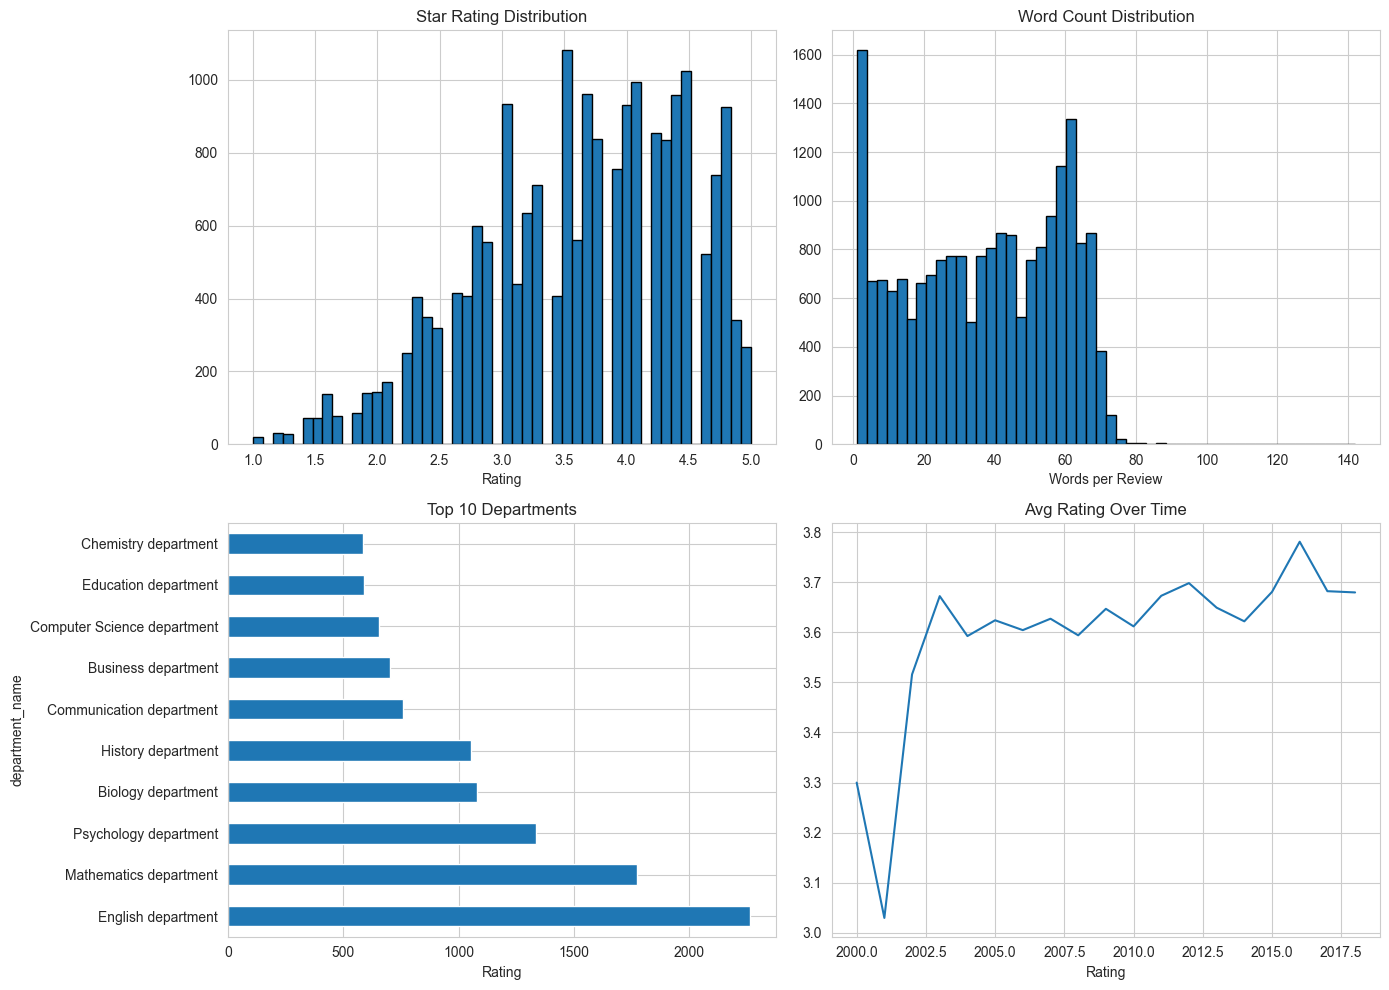

In [34]:
# 4. VISUALIZATIONS
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Rating distribution
df['star_rating'].hist(bins=50, ax=axes[0,0], edgecolor='black')
axes[0,0].set_title('Star Rating Distribution')
axes[0,0].set_xlabel('Rating')

# Word count distribution
df['word_count'].hist(bins=50, ax=axes[0,1], edgecolor='black')
axes[0,1].set_title('Word Count Distribution')
axes[0,1].set_xlabel('Words per Review')

# Rating by department (top 10)
top_depts = df['department_name'].value_counts().head(10)
top_depts.plot(kind='barh', ax=axes[1,0])
axes[1,0].set_title('Top 10 Departments')
axes[1,0].set_xlabel('Rating')

# Ratings over time
df['post_date'] = pd.to_datetime(df['post_date'])
df.groupby(df['post_date'].dt.year)['star_rating'].mean().plot(ax=axes[1,1])
axes[1,1].set_title('Avg Rating Over Time')
axes[1,1].set_xlabel('Rating')

plt.tight_layout()
plt.savefig('01_eda.png', dpi=150)
plt.show()

#

# Data Preprocessing with spaCy

## 1. Load Data

In [35]:
df = pd.read_csv("ratemyprofessors.csv")
print(f"Loaded dataset: {len(df):,} rows × {df.shape[1]} columns")

Loaded dataset: 20,000 rows × 51 columns


In [36]:
# Show first few rows
print("\nFirst 3 rows:")
print(df.head(3))


First 3 rows:
   professor_name                                 school_name  \
0  Leslie  Looney  University Of Illinois at Urbana-Champaign   
1  Leslie  Looney  University Of Illinois at Urbana-Champaign   
2  Leslie  Looney  University Of Illinois at Urbana-Champaign   

        department_name                    local_name state_name  \
0  Astronomy department   Champaign\xe2\x80\x93Urbana         IL   
1  Astronomy department   Champaign\xe2\x80\x93Urbana         IL   
2  Astronomy department   Champaign\xe2\x80\x93Urbana         IL   

   year_since_first_review  star_rating take_again  diff_index  \
0                     11.0          4.7        NaN         2.0   
1                     11.0          4.7        NaN         2.0   
2                     11.0          4.7        NaN         2.0   

                                       tag_professor  ...  lots_of_homework  \
0  Hilarious (2)  GROUP PROJECTS (2)  Gives good ...  ...                 0   
1  Hilarious (2)  GROUP PROJ

## 2. Load Relevant Columns

In [37]:
df = df[["student_star", "comments"]]

In [38]:
print(f" Kept columns: {list(df.columns)}")
print(f"   Shape: {df.shape}")

 Kept columns: ['student_star', 'comments']
   Shape: (20000, 2)


## 3. Handle Missing Values

In [39]:
print(f"Missing values before:")
print(df.isnull().sum())

Missing values before:
student_star    5
comments        7
dtype: int64


In [40]:
df = df.dropna(subset=["student_star", "comments"])
print(f"\n After removing nulls: {len(df):,} rows")


 After removing nulls: 19,993 rows


## 4. Create Binary Sentiment Labels

In [41]:
def map_sentiment(rating):
    if rating <= 2.0:
        return 0   # Negative
    elif rating >= 4.0:
        return 1   # Positive
    else:
        return None  # Neutral

In [42]:
# Apply sentiment mapping
df["sentiment"] = df["student_star"].apply(map_sentiment)

In [43]:
# Show distribution before filtering
print("\nSentiment distribution (before filtering):")
print(df["sentiment"].value_counts(dropna=False).sort_index())


Sentiment distribution (before filtering):
sentiment
0.0     4764
1.0    11814
NaN     3415
Name: count, dtype: int64


In [44]:
# Drop neutral rows
df = df.dropna(subset=["sentiment"])
df["sentiment"] = df["sentiment"].astype(int)
print(f"After removing neutral ratings: {len(df):,} rows")

After removing neutral ratings: 16,578 rows


In [45]:
# Show final distribution
print(df["sentiment"].value_counts().sort_index())
print("\nIn Percentages:")
sentiment_pct = df["sentiment"].value_counts(normalize=True) * 100
print(sentiment_pct)

sentiment
0     4764
1    11814
Name: count, dtype: int64

In Percentages:
sentiment
1    71.26312
0    28.73688
Name: proportion, dtype: float64


In [46]:
# Calculate imbalance ratio
neg_count = (df["sentiment"] == 0).sum()
pos_count = (df["sentiment"] == 1).sum()
imbalance_ratio = max(neg_count, pos_count) / min(neg_count, pos_count)
print(f"Class Imbalance Ratio: {imbalance_ratio:.2f}:1")

Class Imbalance Ratio: 2.48:1


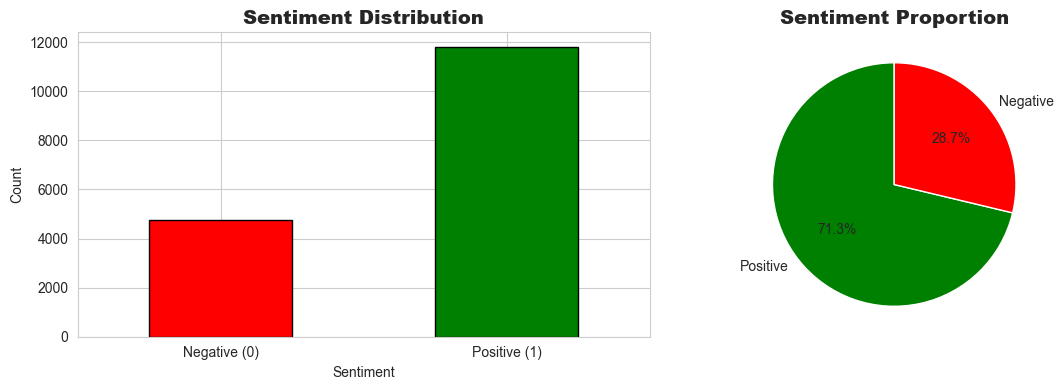

In [47]:
# Visualize distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Bar plot
df["sentiment"].value_counts().sort_index().plot(
    kind='bar', 
    ax=axes[0], 
    color=['red', 'green'],
    edgecolor='black'
)
axes[0].set_title('Sentiment Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Sentiment')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Negative (0)', 'Positive (1)'], rotation=0)

# Pie chart
df["sentiment"].value_counts().plot(
    kind='pie',
    ax=axes[1],
    labels=['Positive', 'Negative'],
    colors=['green', 'red'],
    autopct='%1.1f%%',
    startangle=90
)
axes[1].set_title('Sentiment Proportion', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.savefig('01_sentiment_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Text Preprocessing with Spacy

In [48]:
# Load SpaCy English Small Model
nlp = spacy.load("en_core_web_sm")

In [49]:
def clean_text_lemmatize(text):
    # Lowercase
    text = text.lower()

    # Remove punctuation and special characters
    text = re.sub(r"[^a-z0-9\s]", " ", text)

    # Collapse multiple spaces
    text = re.sub(r"\s+", " ", text).strip()

    # Process with spaCy
    doc = nlp(text)

    # Lemmatize and remove stopwords
    tokens = [
        token.lemma_
        for token in doc
        if not token.is_stop           # Remove stopwords
        and token.lemma_.strip() != "" # Remove empty tokens
        and len(token.lemma_) > 2      # Remove very short tokens (likely noise)
    ]
    
    return " ".join(tokens)

In [50]:
# Apply text cleaning
df["clean_comments"] = df["comments"].apply(clean_text_lemmatize)

## 6. Preprocessing Examples

In [51]:
# Show 5 random examples
sample_df = df.sample(5, random_state=42)

In [52]:
for i, (idx, row) in enumerate(sample_df.iterrows(), 1):
    print(f"\nExample {i}:")
    print(f"Rating: {row['student_star']:.1f} | Sentiment: {'Positive' if row['sentiment']==1 else 'Negative'}")
    print(f"ORIGINAL ({len(row['comments'])} chars):")
    print(f"   {row['comments'][:150]}{'...' if len(row['comments']) > 300 else ''}")
    print(f"CLEANED ({len(row['clean_comments'])} chars):")
    print(f"   {row['clean_comments'][:150]}{'...' if len(row['clean_comments']) > 300 else ''}")


Example 1:
Rating: 4.5 | Sentiment: Positive
ORIGINAL (346 chars):
   Very good teacher. Professor Walker is extremely knowledgeable on the subject. He makes you feel free to ask questions and offers clear explanations. ...
CLEANED (218 chars):
   good teacher professor walker extremely knowledgeable subject make feel free ask question offer clear explanation say material fairly tough question t

Example 2:
Rating: 1.0 | Sentiment: Negative
ORIGINAL (11 chars):
   No Comments
CLEANED (7 chars):
   comment

Example 3:
Rating: 1.0 | Sentiment: Negative
ORIGINAL (25 chars):
   she has a bad personality
CLEANED (15 chars):
   bad personality

Example 4:
Rating: 4.0 | Sentiment: Positive
ORIGINAL (283 chars):
   She\'s hard to understand at first but after being in her class a couple of days you start to translate well. She\'s always really helpful if you ask!
CLEANED (129 chars):
   hard understand class couple day start translate helpful ask expect apply call people class laugh answer wr

## 7. Text Statistics

In [53]:
df['word_count_original'] = df['comments'].str.split().str.len()
df['word_count_cleaned'] = df['clean_comments'].str.split().str.len()
df['char_count_original'] = df['comments'].str.len()
df['char_count_cleaned'] = df['clean_comments'].str.len()

print("\n Original Text:")
print(f"   Average words: {df['word_count_original'].mean():.1f}")
print(f"   Median words:  {df['word_count_original'].median():.1f}")
print(f"   Average chars: {df['char_count_original'].mean():.1f}")

print("\n Cleaned Text:")
print(f"   Average words: {df['word_count_cleaned'].mean():.1f}")
print(f"   Median words:  {df['word_count_cleaned'].median():.1f}")
print(f"   Average chars: {df['char_count_cleaned'].mean():.1f}")

reduction_words = (1 - df['word_count_cleaned'].mean() / df['word_count_original'].mean()) * 100
print(f"   Reduction: {reduction_words:.1f}% fewer words after preprocessing")


 Original Text:
   Average words: 36.3
   Median words:  37.0
   Average chars: 197.4

 Cleaned Text:
   Average words: 15.1
   Median words:  15.0
   Average chars: 100.4
   Reduction: 58.3% fewer words after preprocessing


In [54]:
# Check for empty texts after cleaning
# HAHHAHAHA nadelete ko agad pero meron
empty_count = (df['clean_comments'].str.len() == 0).sum()
if empty_count > 0:
    print(f"\nWarning: {empty_count} reviews became empty after preprocessing")
    df = df[df['clean_comments'].str.len() > 0].copy()
print(f"Final size: {len(df):,} rows from 16,578 rows") # 16,578 rows after removing neutral sentiments


Final size: 16,549 rows from 16,578 rows


## 8. Train/Validation/Test Split

In [55]:
# Prepare features and labels
X = df["clean_comments"]
y = df["sentiment"]

In [56]:
print(f"Total samples: {len(X):,}")

Total samples: 16,549


In [57]:
# First split: Train (70%) vs Temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, 
    test_size=0.3,        # 30% for temp (will be split into val + test)
    stratify=y,           # Maintain class distribution
    random_state=42       # Reproducibility
)

# Second split: Val (15%) vs Test (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,        # 50% of temp = 15% of total
    stratify=y_temp,      # Maintain class distribution
    random_state=42
)

In [58]:
print(f"Train: {len(X_train):,} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"Val:   {len(X_val):,} samples ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test:  {len(X_test):,} samples ({len(X_test)/len(X)*100:.1f}%)")
print(f"Total: {len(X):,} samples (100.0%)")

Train: 11,584 samples (70.0%)
Val:   2,482 samples (15.0%)
Test:  2,483 samples (15.0%)
Total: 16,549 samples (100.0%)


In [59]:
# Check class balance in each split
for split_name, split_y in [('Train', y_train), ('Val', y_val), ('Test', y_test)]:
    neg = (split_y == 0).sum()
    pos = (split_y == 1).sum()
    neg_pct = neg / len(split_y) * 100
    pos_pct = pos / len(split_y) * 100
    
    print(f"{split_name:6s}: Negative={neg:,} ({neg_pct:.1f}%) | "
          f"Positive={pos:,} ({pos_pct:.1f}%)")

Train : Negative=3,320 (28.7%) | Positive=8,264 (71.3%)
Val   : Negative=711 (28.6%) | Positive=1,771 (71.4%)
Test  : Negative=712 (28.7%) | Positive=1,771 (71.3%)


## 9. Save Processed Data

In [60]:
# Create DataFrames for each split
train_df = pd.DataFrame({
    'clean_comments': X_train,
    'sentiment': y_train
})

val_df = pd.DataFrame({
    'clean_comments': X_val,
    'sentiment': y_val
})

test_df = pd.DataFrame({
    'clean_comments': X_test,
    'sentiment': y_test
})

In [61]:
# Save to CSV
train_df.to_csv('train.csv', index=False)
val_df.to_csv('val.csv', index=False)
test_df.to_csv('test.csv', index=False)

In [62]:
# Also save the full processed dataset (optional and can be used for reference)
df_processed = pd.DataFrame({
    'student_star': df['student_star'],
    'comments': df['comments'],
    'clean_comments': df['clean_comments'],
    'sentiment': df['sentiment']
})
df_processed.to_csv('processed_full.csv', index=False)

## 10. Summary

In [63]:
print(f"""
   Data Loading:
   - Original dataset: 20,000 rows
   - After cleaning: {len(df):,} rows
   
   Sentiment Labels:
   - Positive (≥4.0): {(df['sentiment']==1).sum():,} ({(df['sentiment']==1).sum()/len(df)*100:.1f}%)
   - Negative (≤2.0): {(df['sentiment']==0).sum():,} ({(df['sentiment']==0).sum()/len(df)*100:.1f}%)
   - Imbalance ratio: {imbalance_ratio:.2f}:1
   - Average word count: {df['word_count_cleaned'].mean():.1f} words
   
   Data Splits:
   - Train: {len(X_train):,} samples (70%)
   - Val:   {len(X_val):,} samples (15%)
   - Test:  {len(X_test):,} samples (15%)

   Files Created:
   - train.csv
   - val.csv
   - test.csv
   - processed_full.csv
   - 01_sentiment_distribution.png
""")


   Data Loading:
   - Original dataset: 20,000 rows
   - After cleaning: 16,549 rows
   
   Sentiment Labels:
   - Positive (≥4.0): 11,806 (71.3%)
   - Negative (≤2.0): 4,743 (28.7%)
   - Imbalance ratio: 2.48:1
   - Average word count: 15.2 words
   
   Data Splits:
   - Train: 11,584 samples (70%)
   - Val:   2,482 samples (15%)
   - Test:  2,483 samples (15%)

   Files Created:
   - train.csv
   - val.csv
   - test.csv
   - processed_full.csv
   - 01_sentiment_distribution.png



# Model 1: TF-IDF + Logistic Regression (Baseline) without HPO

## 1. Load Preprocessed Data

In [78]:
# Load the splits
train_df = pd.read_csv('train.csv')
val_df = pd.read_csv('val.csv')
test_df = pd.read_csv('test.csv')

print(f"Train set: {len(train_df):,} samples")
print(f"Val set:   {len(val_df):,} samples")
print(f"Test set:  {len(test_df):,} samples")

Train set: 11,584 samples
Val set:   2,482 samples
Test set:  2,483 samples


In [79]:
# Prepare features and labels
X_train = train_df["clean_comments"]
y_train = train_df["sentiment"]

X_val = val_df["clean_comments"]
y_val = val_df["sentiment"]

X_test = test_df["clean_comments"]
y_test = test_df["sentiment"]

In [80]:
# Show class distribution
print(f"Train: {y_train.value_counts().sort_index().to_dict()}")
print(f"Val:   {y_val.value_counts().sort_index().to_dict()}")
print(f"Test:  {y_test.value_counts().sort_index().to_dict()}")

Train: {0: 3320, 1: 8264}
Val:   {0: 711, 1: 1771}
Test:  {0: 712, 1: 1771}


## 2. Baseline Model Pipeline

In [81]:
baseline_clf = Pipeline([
    ("tfidf", TfidfVectorizer(
        stop_words="english",      # Remove common English stopwords
        ngram_range=(1, 2),        # Unigrams + bigrams
        max_df=0.95,               # Ignore terms in >95% of documents
        min_df=2,                  # Ignore terms in <2 documents
        max_features=5000,         # Limit vocabulary size
        sublinear_tf=True          # Use log scaling for term frequency
    )),
    ("lr", LogisticRegression(
        max_iter=1000,             # Increase for convergence (was 200)
        class_weight='balanced',   # Handle class imbalance! ✅
        solver='saga',             # Fast solver for large datasets
        random_state=42,           # Reproducibility
        n_jobs=-1                  # Use all CPU cores
    ))
])

## 3. Model Training

In [82]:
baseline_clf.fit(X_train, y_train)

,steps,"[('tfidf', ...), ('lr', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [83]:
# Show TF-IDF vocabulary size
tfidf = baseline_clf.named_steps['tfidf']
print(f"TF-IDF Statistics:")
print(f"   Vocabulary size: {len(tfidf.vocabulary_):,} features")
print(f"   Feature names example: {list(tfidf.get_feature_names_out()[:5])}")

TF-IDF Statistics:
   Vocabulary size: 5,000 features
   Feature names example: ['100', '100 level', '100 point', '101', '102']


## 4. Evaluation Function

In [84]:
def evaluate_model(model, X, y, set_name, save_cm=True):

    # Predictions
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]  # Probability of positive class
    
    # Calculate metrics
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, zero_division=0)
    recall = recall_score(y, y_pred, zero_division=0)
    f1 = f1_score(y, y_pred, zero_division=0)
    
    # ROC AUC (if both classes present)
    if len(np.unique(y)) > 1:
        roc_auc = roc_auc_score(y, y_prob)
    else:
        roc_auc = None
    
    # Print results
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f} (of predicted positives, how many are correct)")
    print(f"Recall:    {recall:.4f} (of actual positives, how many we found)")
    print(f"F1-Score:  {f1:.4f} (harmonic mean of precision & recall)")
    if roc_auc:
        print(f"ROC AUC:   {roc_auc:.4f}")
    
    print(f"\n{set_name} Classification Report:")
    print(classification_report(
        y, y_pred, 
        target_names=['Negative (0)', 'Positive (1)'],
        digits=4
    ))
    
    # Confusion Matrix
    cm = confusion_matrix(y, y_pred)
    
    if save_cm:
        fig, ax = plt.subplots(figsize=(7, 6))
        
        sns.heatmap(
            cm, 
            annot=True, 
            fmt='d', 
            cmap="Blues",
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"],
            cbar_kws={'label': 'Count'},
            ax=ax,
            annot_kws={'size': 14}
        )
        
        ax.set_xlabel("Predicted", fontsize=12)
        ax.set_ylabel("Actual", fontsize=12)
        ax.set_title(f"Confusion Matrix - {set_name} Set", 
                     fontsize=14, pad=20)
        
        # Add accuracy text
        ax.text(1, -0.3, f'Accuracy: {accuracy:.4f}', 
                ha='center', fontsize=11, transform=ax.transAxes)
        
        plt.tight_layout()
        filename = f'02_confusion_matrix_{set_name.lower()}.png'
        plt.savefig(filename, dpi=150, bbox_inches='tight')
        print(f"\n Saved confusion matrix: {filename}")
        plt.show()
    
    return {
        'accuracy': float(accuracy),
        'precision': float(precision),
        'recall': float(recall),
        'f1': float(f1),
        'roc_auc': float(roc_auc) if roc_auc else None,
        'confusion_matrix': cm.tolist(),
        'y_pred': y_pred,
        'y_prob': y_prob
    }

## 5. Evaluate on All Splits

Accuracy:  0.8980
Precision: 0.9733 (of predicted positives, how many are correct)
Recall:    0.8812 (of actual positives, how many we found)
F1-Score:  0.9249 (harmonic mean of precision & recall)
ROC AUC:   0.9688

TRAIN Classification Report:
              precision    recall  f1-score   support

Negative (0)     0.7606    0.9398    0.8407      3320
Positive (1)     0.9733    0.8812    0.9249      8264

    accuracy                         0.8980     11584
   macro avg     0.8669    0.9105    0.8828     11584
weighted avg     0.9123    0.8980    0.9008     11584


 Saved confusion matrix: 02_confusion_matrix_train.png


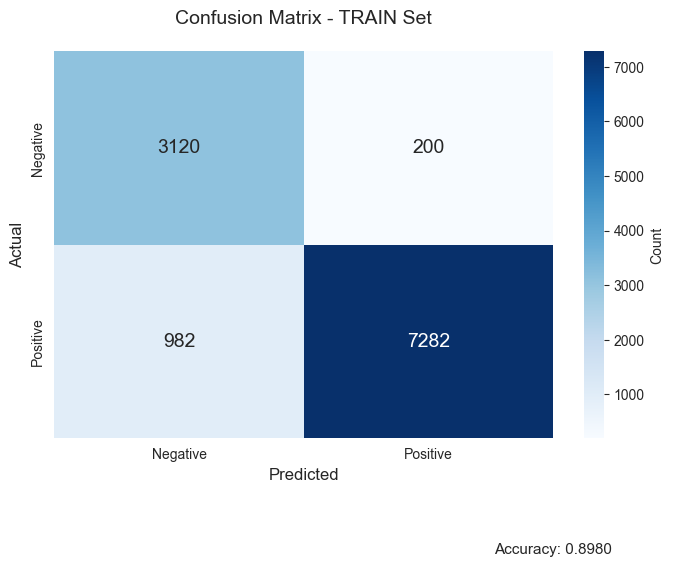

In [85]:
# Evaluate on train set
train_results = evaluate_model(baseline_clf, X_train, y_train, "TRAIN", save_cm=True)

Accuracy:  0.8674
Precision: 0.9462 (of predicted positives, how many are correct)
Recall:    0.8634 (of actual positives, how many we found)
F1-Score:  0.9029 (harmonic mean of precision & recall)
ROC AUC:   0.9440

VALIDATION Classification Report:
              precision    recall  f1-score   support

Negative (0)     0.7206    0.8776    0.7914       711
Positive (1)     0.9462    0.8634    0.9029      1771

    accuracy                         0.8674      2482
   macro avg     0.8334    0.8705    0.8471      2482
weighted avg     0.8815    0.8674    0.8709      2482


 Saved confusion matrix: 02_confusion_matrix_validation.png


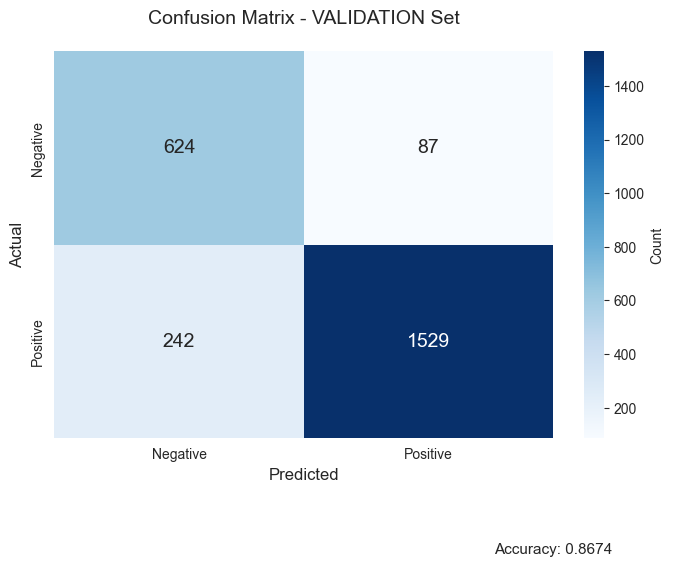

In [86]:
# Evaluate on validation set
val_results = evaluate_model(baseline_clf, X_val, y_val, "VALIDATION", save_cm=True)

Accuracy:  0.8635
Precision: 0.9515 (of predicted positives, how many are correct)
Recall:    0.8521 (of actual positives, how many we found)
F1-Score:  0.8990 (harmonic mean of precision & recall)
ROC AUC:   0.9437

TEST Classification Report:
              precision    recall  f1-score   support

Negative (0)     0.7079    0.8919    0.7893       712
Positive (1)     0.9515    0.8521    0.8990      1771

    accuracy                         0.8635      2483
   macro avg     0.8297    0.8720    0.8442      2483
weighted avg     0.8816    0.8635    0.8676      2483


 Saved confusion matrix: 02_confusion_matrix_test.png


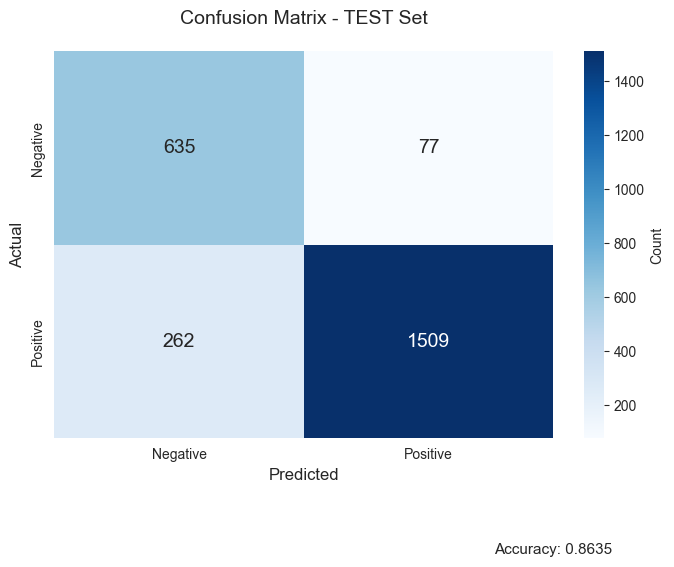

In [87]:
# Evaluate on test set
test_results = evaluate_model(baseline_clf, X_test, y_test, "TEST", save_cm=True)

## 6. Model Comparison

In [88]:
# Create comparison dataframe
metrics_df = pd.DataFrame({
    'Split': ['Train', 'Validation', 'Test'],
    'Accuracy': [train_results['accuracy'], val_results['accuracy'], test_results['accuracy']],
    'Precision': [train_results['precision'], val_results['precision'], test_results['precision']],
    'Recall': [train_results['recall'], val_results['recall'], test_results['recall']],
    'F1-Score': [train_results['f1'], val_results['f1'], test_results['f1']]
})

In [89]:
print(metrics_df.to_string(index=False))

     Split  Accuracy  Precision   Recall  F1-Score
     Train  0.897963   0.973269 0.881171  0.924933
Validation  0.867446   0.946163 0.863354  0.902864
      Test  0.863472   0.951450 0.852061  0.899017


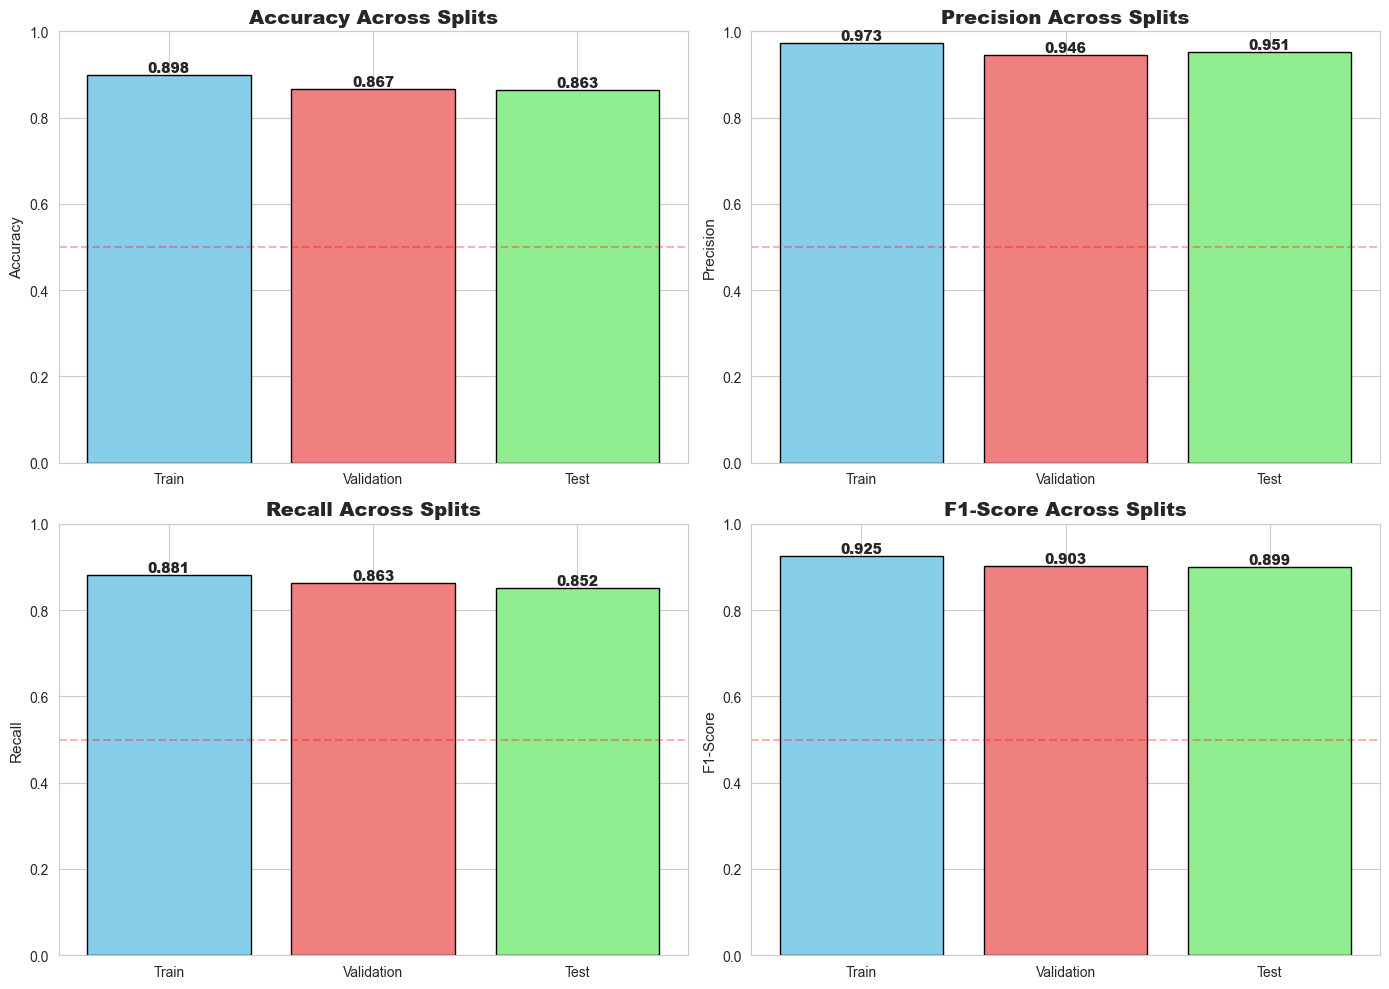

In [90]:
# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['skyblue', 'lightcoral', 'lightgreen']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    
    bars = ax.bar(metrics_df['Split'], metrics_df[metric], color=colors, edgecolor='black')
    ax.set_title(f'{metric} Across Splits', fontsize=14, fontweight='bold')
    ax.set_ylabel(metric, fontsize=11)
    ax.set_ylim([0, 1])
    ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.3)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('02_metrics_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. What are the Top Predictive Words? (Feature Importance)

In [91]:
# Get feature names and coefficients
lr = baseline_clf.named_steps['lr']
feature_names = tfidf.get_feature_names_out()
coefficients = lr.coef_[0]

# Sort by coefficient value
sorted_idx = np.argsort(coefficients)

# Top 15 most positive words (predict positive sentiment)
top_positive_idx = sorted_idx[-15:][::-1]
top_positive_words = [(feature_names[i], coefficients[i]) for i in top_positive_idx]

# Top 15 most negative words (predict negative sentiment)
top_negative_idx = sorted_idx[:15]
top_negative_words = [(feature_names[i], coefficients[i]) for i in top_negative_idx]

In [92]:
print("Top 15 words Predicting Positive Sentiment:")
for i, (word, coef) in enumerate(top_positive_words, 1):
    print(f"{i:2d}. {word:25s} {coef:+.4f}")

print("\nTop 15 words Predicting Negative Sentiment:")
for i, (word, coef) in enumerate(top_negative_words, 1):
    print(f"{i:2d}. {word:25s} {coef:+.4f}")

Top 15 words Predicting Positive Sentiment:
 1. great                     +7.3337
 2. awesome                   +5.8846
 3. easy                      +5.2485
 4. love                      +4.8529
 5. amazing                   +4.3520
 6. fun                       +3.8576
 7. excellent                 +3.8569
 8. wonderful                 +3.7692
 9. funny                     +3.7542
10. good professor            +3.4557
11. good                      +3.2213
12. willing                   +3.1197
13. interesting               +3.1161
14. cool                      +2.8533
15. great teacher             +2.8507

Top 15 words Predicting Negative Sentiment:
 1. horrible                  -4.6349
 2. avoid                     -4.3066
 3. rude                      -4.1650
 4. terrible                  -3.8034
 5. unclear                   -3.8018
 6. bad teacher               -3.6273
 7. awful                     -3.6023
 8. bad                       -3.5289
 9. doesn                     -3.5136

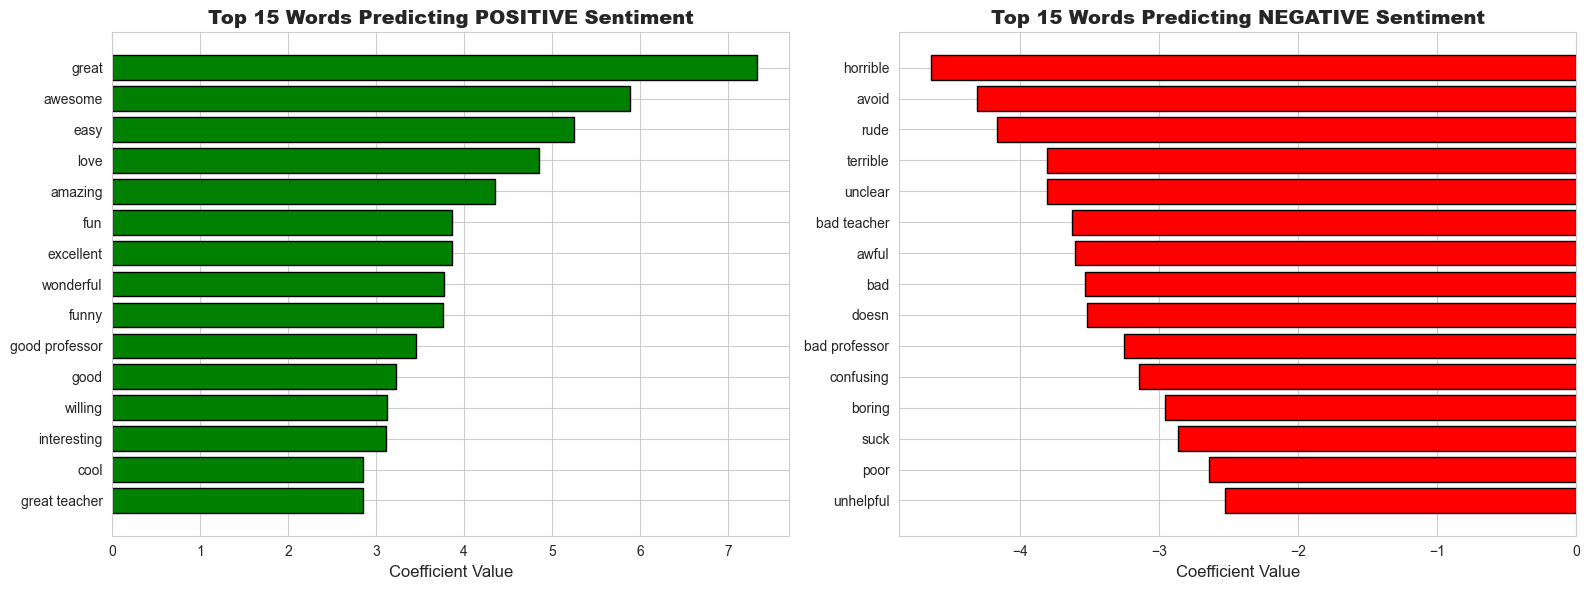

In [93]:
# Visualize top features
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Positive words
pos_words, pos_coefs = zip(*top_positive_words[:15])
axes[0].barh(range(15), pos_coefs, color='green', edgecolor='black')
axes[0].set_yticks(range(15))
axes[0].set_yticklabels(pos_words)
axes[0].set_xlabel('Coefficient Value', fontsize=12)
axes[0].set_title('Top 15 Words Predicting POSITIVE Sentiment', 
                  fontsize=14, fontweight='bold')
axes[0].invert_yaxis()

# Negative words
neg_words, neg_coefs = zip(*top_negative_words[:15])
axes[1].barh(range(15), neg_coefs, color='red', edgecolor='black')
axes[1].set_yticks(range(15))
axes[1].set_yticklabels(neg_words)
axes[1].set_xlabel('Coefficient Value', fontsize=12)
axes[1].set_title('Top 15 Words Predicting NEGATIVE Sentiment', 
                  fontsize=14, fontweight='bold')
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig('02_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Error Analysis

In [94]:
# Analyze validation set errors
val_df_copy = val_df.copy()
val_df_copy['predicted'] = val_results['y_pred']
val_df_copy['probability'] = val_results['y_prob']
val_df_copy['correct'] = val_df_copy['sentiment'] == val_df_copy['predicted']

# False Positives (predicted positive, actually negative)
false_positives = val_df_copy[(val_df_copy['sentiment'] == 0) & 
                               (val_df_copy['predicted'] == 1)]

# False Negatives (predicted negative, actually positive)
false_negatives = val_df_copy[(val_df_copy['sentiment'] == 1) & 
                               (val_df_copy['predicted'] == 0)]

print(f"\nError Analysis on Validation Set:")
print(f"   Total samples: {len(val_df_copy)}")
print(f"   Correct predictions: {val_df_copy['correct'].sum()} ({val_df_copy['correct'].mean()*100:.1f}%)")
print(f"   Incorrect predictions: {(~val_df_copy['correct']).sum()} ({(~val_df_copy['correct']).mean()*100:.1f}%)")
print(f"\n   False Positives: {len(false_positives)} (predicted positive, actually negative)")
print(f"   False Negatives: {len(false_negatives)} (predicted negative, actually positive)")


Error Analysis on Validation Set:
   Total samples: 2482
   Correct predictions: 2153 (86.7%)
   Incorrect predictions: 329 (13.3%)

   False Positives: 87 (predicted positive, actually negative)
   False Negatives: 242 (predicted negative, actually positive)


In [95]:
# Show examples of errors
if len(false_positives) > 0:
    print(f"Example FALSE POSITIVES:")
    for i, (idx, row) in enumerate(false_positives.head(3).iterrows(), 1):
        print(f"\n   {i}. Predicted: Positive | Actual: Negative | Confidence: {row['probability']:.2%}")
        print(f"      Text: {row['clean_comments'][:300]}")

if len(false_negatives) > 0:
    print(f"\nExample FALSE NEGATIVES:")
    for i, (idx, row) in enumerate(false_negatives.head(3).iterrows(), 1):
        print(f"\n   {i}. Predicted: Negative | Actual: Positive | Confidence: {1-row['probability']:.2%}")
        print(f"      Text: {row['clean_comments'][:300]}")

Example FALSE POSITIVES:

   1. Predicted: Positive | Actual: Negative | Confidence: 52.18%
      Text: don know find helpful challenging light teacher high school challenge spend minute talk story write like paper waste rest time talk class easy lazy people

   2. Predicted: Positive | Actual: Negative | Confidence: 75.68%
      Text: good teacher come kind jerk

   3. Predicted: Positive | Actual: Negative | Confidence: 52.57%
      Text: test extremely hard know stuff

Example FALSE NEGATIVES:

   1. Predicted: Negative | Actual: Positive | Confidence: 73.27%
      Text: take maleki cna tough want nurse want excellent nurse pick favorite snap blend don stand learn pass

   2. Predicted: Negative | Actual: Positive | Confidence: 50.83%
      Text: personal favorite

   3. Predicted: Negative | Actual: Positive | Confidence: 53.93%
      Text: crockett hilarious professor retire soon trust matter major regret take class


### 8A. Calibration Analysis

In [96]:
# Get predicted probabilities for test set
y_prob_test = test_results['y_prob']

# Calculate calibration curve
prob_true, prob_pred = calibration_curve(y_test, y_prob_test, n_bins=10, strategy='uniform')

# Calculate Expected Calibration Error (ECE)
ece = np.mean(np.abs(prob_true - prob_pred))

if ece < 0.05:
    print("Status: Excellent calibration")
elif ece < 0.10:
    print("Status: Good calibration")
elif ece < 0.15:
    print("Status: Moderate calibration")
else:
    print("Status: Poor calibration - consider recalibration")

Status: Moderate calibration



Saved calibration plot: 02_calibration_analysis.png


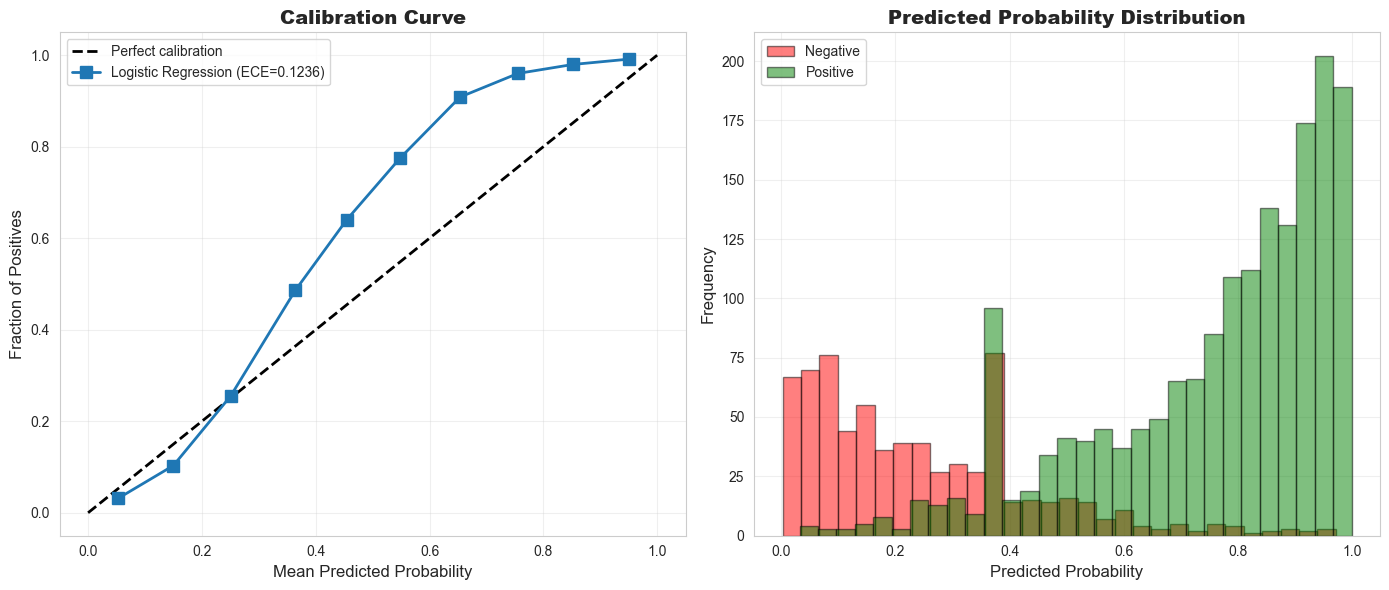

In [97]:
# Plot calibration curve
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Calibration curve
axes[0].plot([0, 1], [0, 1], 'k--', label='Perfect calibration', linewidth=2)
axes[0].plot(prob_pred, prob_true, 's-', label=f'Logistic Regression (ECE={ece:.4f})', 
             linewidth=2, markersize=8)
axes[0].set_xlabel('Mean Predicted Probability', fontsize=12)
axes[0].set_ylabel('Fraction of Positives', fontsize=12)
axes[0].set_title('Calibration Curve', fontsize=14, fontweight='bold')
axes[0].legend(loc='upper left')
axes[0].grid(True, alpha=0.3)

# Distribution of predicted probabilities
axes[1].hist(y_prob_test[y_test == 0], bins=30, alpha=0.5, label='Negative', 
             color='red', edgecolor='black')
axes[1].hist(y_prob_test[y_test == 1], bins=30, alpha=0.5, label='Positive', 
             color='green', edgecolor='black')
axes[1].set_xlabel('Predicted Probability', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Predicted Probability Distribution', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('02_calibration_analysis.png', dpi=150, bbox_inches='tight')
print("\nSaved calibration plot: 02_calibration_analysis.png")
plt.show()

### 8B. SHAP Analysis

In [98]:
# Create a wrapper function for SHAP to get probability predictions
def model_predict_proba(texts):
    return baseline_clf.predict_proba(texts)

In [99]:
n_samples_shap = 100000 

# Sample from validation set
val_sample_indices = np.random.RandomState(42).choice(
    len(X_val), 
    size=min(n_samples_shap, len(X_val)), 
    replace=False
)
X_val_sample = X_val.iloc[val_sample_indices]
y_val_sample = y_val.iloc[val_sample_indices]

In [100]:
# Transform to TF-IDF features
X_val_tfidf = baseline_clf.named_steps['tfidf'].transform(X_val_sample)

In [101]:
# Create SHAP explainer
explainer = shap.LinearExplainer(
    baseline_clf.named_steps['lr'],
    X_val_tfidf,
    feature_perturbation="interventional"
)

# Calculate SHAP values
shap_values = explainer.shap_values(X_val_tfidf)

# Get feature names
feature_names_array = baseline_clf.named_steps['tfidf'].get_feature_names_out()

### 8C. SHAP Visualizations

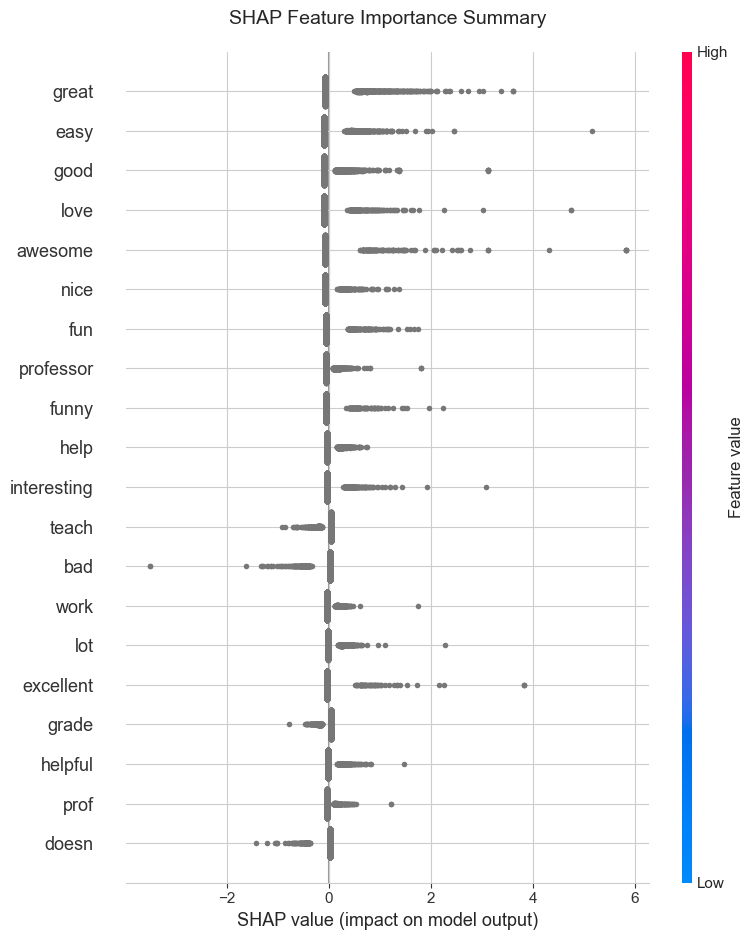

In [102]:
# 1. SHAP Summary Plot (Feature Importance)
fig, ax = plt.subplots(figsize=(10, 8))
shap.summary_plot(
    shap_values, 
    X_val_tfidf,
    feature_names=feature_names_array,
    max_display=20,
    show=False
)
plt.title('SHAP Feature Importance Summary', fontsize=14, pad=20)
plt.tight_layout()
plt.savefig('02_shap_summary.png', dpi=150, bbox_inches='tight')
plt.show()

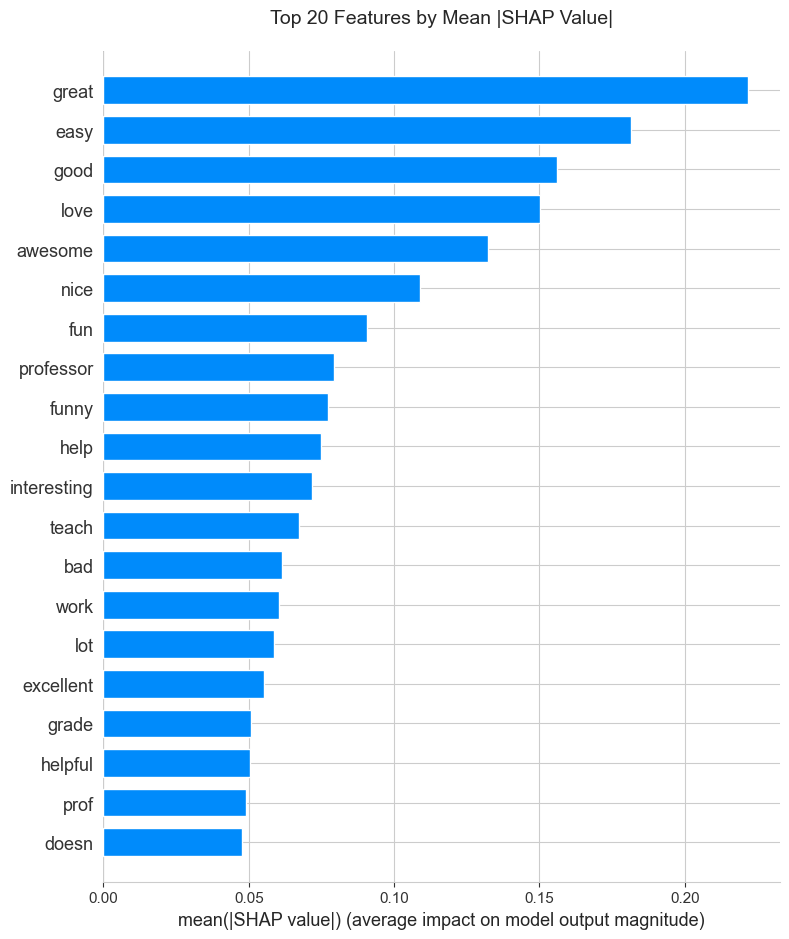

In [103]:
# 2. SHAP Bar Plot (Mean Absolute SHAP Values)
fig, ax = plt.subplots(figsize=(10, 8))
shap.summary_plot(
    shap_values,
    X_val_tfidf,
    feature_names=feature_names_array,
    plot_type="bar",
    max_display=20,
    show=False
)
plt.title('Top 20 Features by Mean |SHAP Value|', fontsize=14, pad=20)
plt.tight_layout()
plt.savefig('02_shap_bar.png', dpi=150, bbox_inches='tight')
plt.show()

In [104]:
# 3. Get global feature importance from SHAP
mean_abs_shap = np.abs(shap_values).mean(axis=0)
shap_importance_df = pd.DataFrame({
    'feature': feature_names_array,
    'mean_abs_shap': mean_abs_shap
}).sort_values('mean_abs_shap', ascending=False)

print("\nTop 30 Features by SHAP Importance:")
print(shap_importance_df.head(30).to_string(index=False))


Top 30 Features by SHAP Importance:
      feature  mean_abs_shap
        great       0.221667
         easy       0.181581
         good       0.156185
         love       0.150346
      awesome       0.132191
         nice       0.108948
          fun       0.090724
    professor       0.079351
        funny       0.077290
         help       0.074749
  interesting       0.071802
        teach       0.067293
          bad       0.061547
         work       0.060345
          lot       0.058636
    excellent       0.055173
        grade       0.050691
      helpful       0.050364
         prof       0.049025
        doesn       0.047672
         cool       0.046463
      amazing       0.045044
 good teacher       0.044459
      teacher       0.044188
        avoid       0.043039
    wonderful       0.042836
      willing       0.041124
         hard       0.040947
great teacher       0.039782
     horrible       0.038785


### 8D. Instance-level SHAP examples

In [105]:
def explain_with_shap(sample_idx, X_data, y_data, shap_vals, original_texts):
    # Get prediction
    pred = baseline_clf.predict([X_data.iloc[sample_idx]])[0]
    prob = baseline_clf.predict_proba([X_data.iloc[sample_idx]])[0]
    true_label = y_data.iloc[sample_idx]
    
    print(f"\nSample Index: {sample_idx}")
    print(f"True Label: {'POSITIVE' if true_label == 1 else 'NEGATIVE'}")
    print(f"Predicted: {'POSITIVE' if pred == 1 else 'NEGATIVE'}")
    print(f"Confidence: {prob[pred]:.2%}")
    print(f"Probabilities: Negative={prob[0]:.2%}, Positive={prob[1]:.2%}")
    
    # Get text
    text = original_texts.iloc[sample_idx]
    print(f"\nText: {text[:200]}...")
    
    # Get SHAP values for this instance
    instance_shap = shap_vals[sample_idx]
    
    # Get non-zero features
    X_tfidf_instance = baseline_clf.named_steps['tfidf'].transform([text])
    feature_indices = X_tfidf_instance.nonzero()[1]
    
    # Create feature contributions
    contributions = []
    for idx in feature_indices:
        word = feature_names_array[idx]
        shap_value = instance_shap[idx]
        contributions.append((word, shap_value))
    
    # Sort by absolute SHAP value
    contributions.sort(key=lambda x: abs(x[1]), reverse=True)
    
    print(f"\nTop 10 Contributing Features (by SHAP value):")
    for i, (word, shap_val) in enumerate(contributions[:10], 1):
        direction = "-> Positive" if shap_val > 0 else "-> Negative"
        print(f"  {i:2d}. {word:20s} SHAP={shap_val:+.4f} {direction}")
    
    return contributions

# Explain specific examples
print("\nExample 1: Correctly Predicted POSITIVE")
pos_correct_idx = np.where((y_val_sample == 1) & 
                           (baseline_clf.predict(X_val_sample) == 1))[0]
if len(pos_correct_idx) > 0:
    explain_with_shap(pos_correct_idx[0], X_val_sample, y_val_sample, 
                     shap_values, X_val_sample)

print("\nExample 2: Correctly Predicted NEGATIVE")
neg_correct_idx = np.where((y_val_sample == 0) & 
                           (baseline_clf.predict(X_val_sample) == 0))[0]
if len(neg_correct_idx) > 0:
    explain_with_shap(neg_correct_idx[0], X_val_sample, y_val_sample,
                     shap_values, X_val_sample)

print("\nExample 3: MISCLASSIFIED - False Positive")
fp_idx = np.where((y_val_sample == 0) & 
                  (baseline_clf.predict(X_val_sample) == 1))[0]
if len(fp_idx) > 0:
    explain_with_shap(fp_idx[0], X_val_sample, y_val_sample,
                     shap_values, X_val_sample)

print("\nExample 4: MISCLASSIFIED - False Negative")
fn_idx = np.where((y_val_sample == 1) & 
                  (baseline_clf.predict(X_val_sample) == 0))[0]
if len(fn_idx) > 0:
    explain_with_shap(fn_idx[0], X_val_sample, y_val_sample,
                     shap_values, X_val_sample)


Example 1: Correctly Predicted POSITIVE

Sample Index: 3
True Label: POSITIVE
Predicted: POSITIVE
Confidence: 66.19%
Probabilities: Negative=33.81%, Positive=66.19%

Text: like guy helpful want student succeed tell want follow post slide online classmate get read chapter read skim country help midterm final paper take attendance everyday...

Top 10 Contributing Features (by SHAP value):
   1. succeed              SHAP=+0.2552 -> Positive
   2. helpful              SHAP=+0.1858 -> Positive
   3. help                 SHAP=+0.1780 -> Positive
   4. want student         SHAP=+0.1673 -> Positive
   5. guy helpful          SHAP=-0.1607 -> Negative
   6. tell                 SHAP=-0.1341 -> Negative
   7. everyday             SHAP=-0.1275 -> Negative
   8. helpful want         SHAP=+0.1256 -> Positive
   9. read                 SHAP=+0.1139 -> Positive
  10. read chapter         SHAP=+0.1039 -> Positive

Example 2: Correctly Predicted NEGATIVE

Sample Index: 1
True Label: NEGATIVE
Predicted:

### 8E. SHAP Interesting Examples


Force plot for positive prediction (index 3):


findfont: Font family ['DejaVu Sans Display'] not found. Falling back to DejaVu Sans.


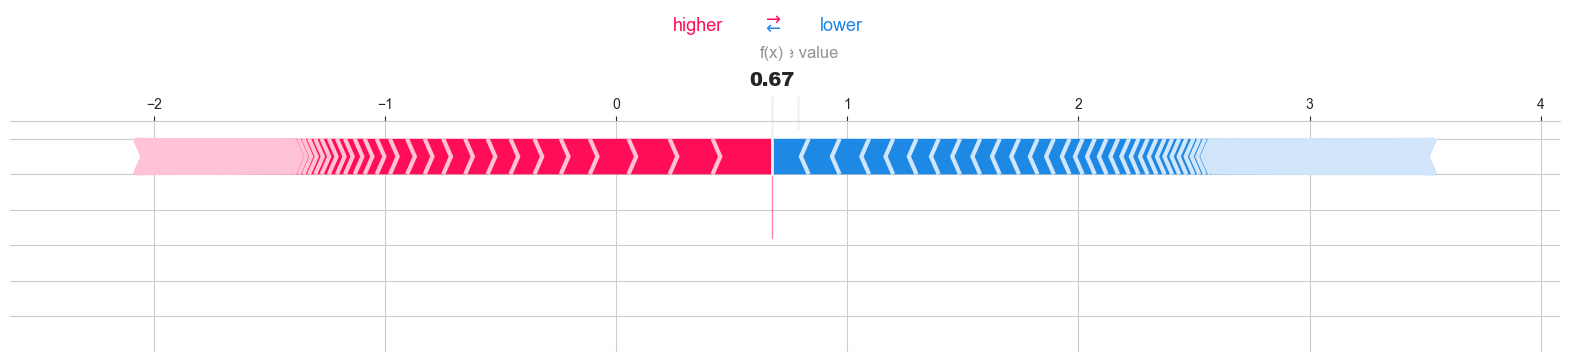

In [106]:
# Initialize JavaScript for SHAP visualizations
shap.initjs()

# Select interesting examples
# Example 1: High confidence positive prediction
high_conf_pos_idx = np.where((y_val_sample == 1) & 
                              (baseline_clf.predict(X_val_sample) == 1))[0]
if len(high_conf_pos_idx) > 0:
    idx = high_conf_pos_idx[0]
    
    # Create force plot
    print(f"\nForce plot for positive prediction (index {idx}):")
    force_plot = shap.force_plot(
        explainer.expected_value,
        shap_values[idx],
        feature_names=feature_names_array,
        matplotlib=True,
        show=False
    )
    plt.savefig('02_shap_force_positive.png', dpi=150, bbox_inches='tight')
    plt.show()


Force plot for negative prediction (index 1):


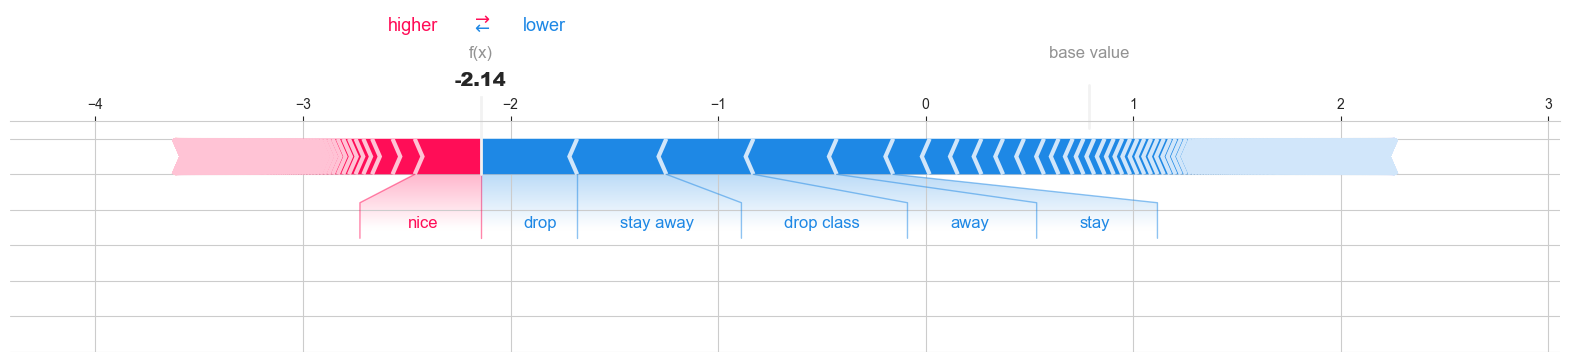

In [107]:
# Example 2: High confidence negative prediction
high_conf_neg_idx = np.where((y_val_sample == 0) & 
                              (baseline_clf.predict(X_val_sample) == 0))[0]
if len(high_conf_neg_idx) > 0:
    idx = high_conf_neg_idx[0]
    
    print(f"\nForce plot for negative prediction (index {idx}):")
    force_plot = shap.force_plot(
        explainer.expected_value,
        shap_values[idx],
        feature_names=feature_names_array,
        matplotlib=True,
        show=False
    )
    plt.savefig('02_shap_force_negative.png', dpi=150, bbox_inches='tight')
    plt.show()

### 8E. SHAP Waterfall Plot


Generating waterfall plot for sample 3...


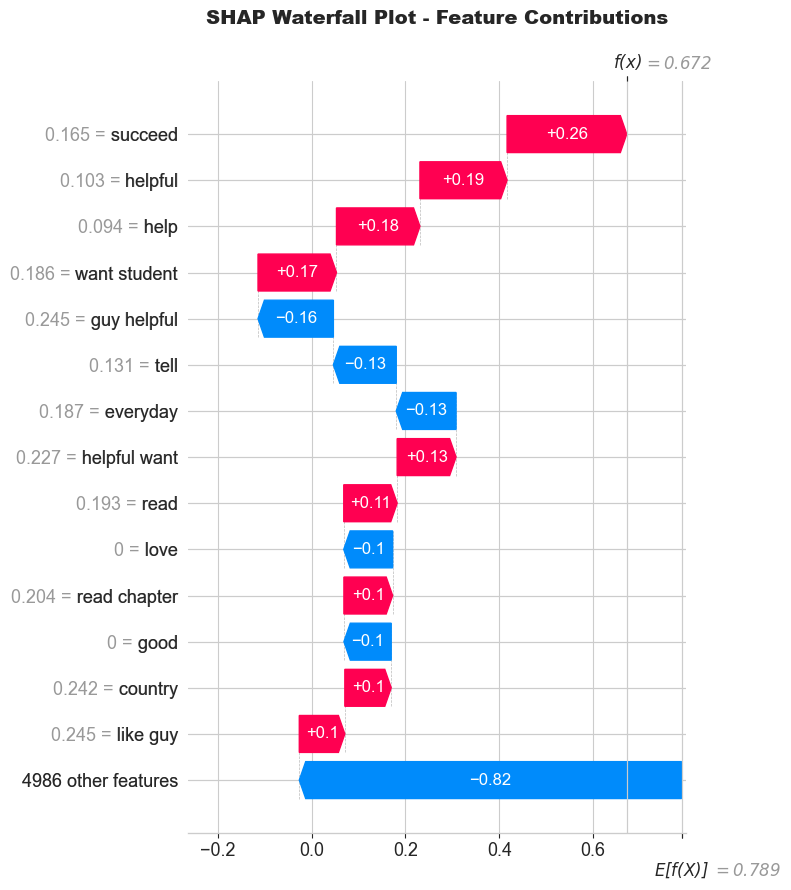

In [108]:
# Select an example for waterfall plot
if len(pos_correct_idx) > 0:
    idx = pos_correct_idx[0]
    
    print(f"\nGenerating waterfall plot for sample {idx}...")
    
    # Create SHAP Explanation object
    shap_explanation = shap.Explanation(
        values=shap_values[idx],
        base_values=explainer.expected_value,
        data=X_val_tfidf[idx].toarray()[0],
        feature_names=feature_names_array
    )
    
    # Generate waterfall plot
    fig, ax = plt.subplots(figsize=(10, 8))
    shap.plots.waterfall(shap_explanation, max_display=15, show=False)
    plt.title('SHAP Waterfall Plot - Feature Contributions', 
              fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.savefig('02_shap_waterfall.png', dpi=150, bbox_inches='tight')
    plt.show()

### 8G. SHAP Decision Plot

Saved: 02_shap_decision.png


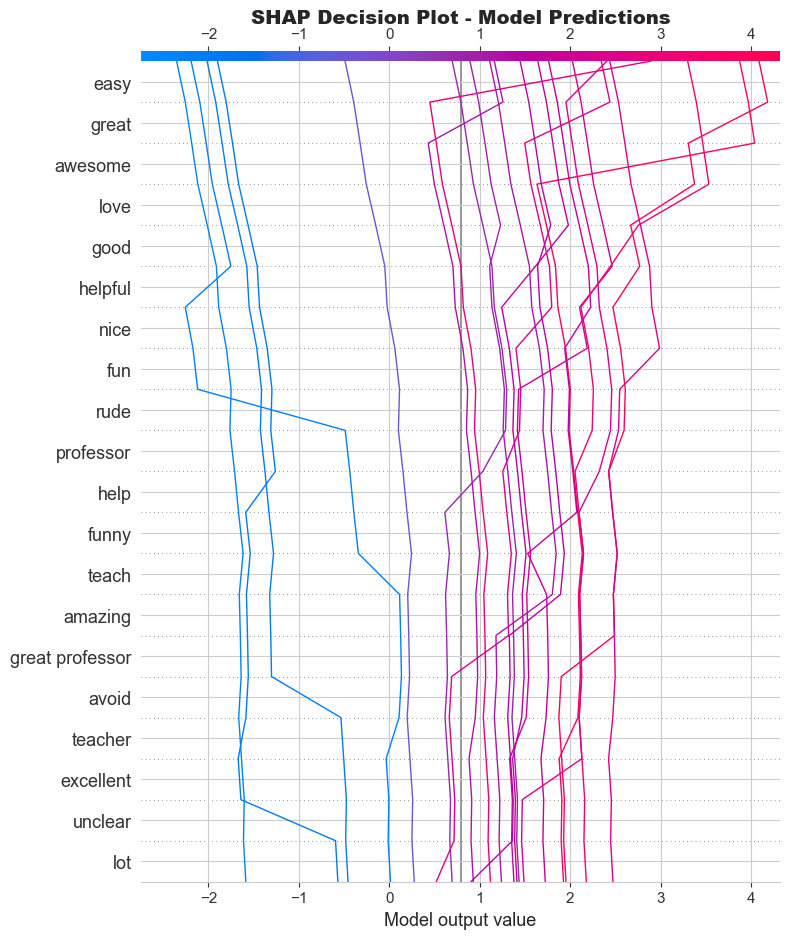

In [109]:
# Select a subset for decision plot
n_decision_samples = min(20, len(X_val_sample))
decision_indices = np.random.RandomState(42).choice(
    len(X_val_sample), 
    size=n_decision_samples, 
    replace=False
)

fig, ax = plt.subplots(figsize=(12, 8))
shap.decision_plot(
    explainer.expected_value,
    shap_values[decision_indices],
    feature_names=feature_names_array,
    feature_display_range=slice(None, -21, -1),  # Top 20 features
    show=False
)
plt.title('SHAP Decision Plot - Model Predictions', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('02_shap_decision.png', dpi=150, bbox_inches='tight')
print("Saved: 02_shap_decision.png")
plt.show()

### 8H. Compare SHAP with Coefficient Importance

In [110]:
# Get coefficients
lr_model = baseline_clf.named_steps['lr']
coefficients = lr_model.coef_[0]

# Create comparison dataframe
coef_importance = pd.DataFrame({
    'feature': feature_names_array,
    'coefficient': coefficients,
    'abs_coefficient': np.abs(coefficients)
})

shap_importance = pd.DataFrame({
    'feature': feature_names_array,
    'mean_abs_shap': mean_abs_shap
})

# Merge
importance_comparison = coef_importance.merge(shap_importance, on='feature')
importance_comparison['coef_rank'] = importance_comparison['abs_coefficient'].rank(ascending=False)
importance_comparison['shap_rank'] = importance_comparison['mean_abs_shap'].rank(ascending=False)
importance_comparison['rank_diff'] = np.abs(
    importance_comparison['coef_rank'] - importance_comparison['shap_rank']
)

In [111]:
# Show top features by both methods
print("Top 20 Features - Coefficient Method:")
print(importance_comparison.nlargest(20, 'abs_coefficient')[
    ['feature', 'abs_coefficient', 'coef_rank']
].to_string(index=False))

Top 20 Features - Coefficient Method:
       feature  abs_coefficient  coef_rank
         great         7.333676        1.0
       awesome         5.884599        2.0
          easy         5.248507        3.0
          love         4.852916        4.0
      horrible         4.634897        5.0
       amazing         4.351967        6.0
         avoid         4.306607        7.0
          rude         4.164998        8.0
           fun         3.857637        9.0
     excellent         3.856934       10.0
      terrible         3.803407       11.0
       unclear         3.801772       12.0
     wonderful         3.769215       13.0
         funny         3.754184       14.0
   bad teacher         3.627255       15.0
         awful         3.602300       16.0
           bad         3.528911       17.0
         doesn         3.513615       18.0
good professor         3.455703       19.0
 bad professor         3.246894       20.0


In [112]:
print("\nTop 20 Features - SHAP Method:")
print(importance_comparison.nlargest(20, 'mean_abs_shap')[
    ['feature', 'mean_abs_shap', 'shap_rank']
].to_string(index=False))


Top 20 Features - SHAP Method:
    feature  mean_abs_shap  shap_rank
      great       0.221667        1.0
       easy       0.181581        2.0
       good       0.156185        3.0
       love       0.150346        4.0
    awesome       0.132191        5.0
       nice       0.108948        6.0
        fun       0.090724        7.0
  professor       0.079351        8.0
      funny       0.077290        9.0
       help       0.074749       10.0
interesting       0.071802       11.0
      teach       0.067293       12.0
        bad       0.061547       13.0
       work       0.060345       14.0
        lot       0.058636       15.0
  excellent       0.055173       16.0
      grade       0.050691       17.0
    helpful       0.050364       18.0
       prof       0.049025       19.0
      doesn       0.047672       20.0


In [113]:
print("\nFeatures with Largest Rank Disagreement:")
print(importance_comparison.nlargest(10, 'rank_diff')[
    ['feature', 'coef_rank', 'shap_rank', 'rank_diff']
].to_string(index=False))


Features with Largest Rank Disagreement:
         feature  coef_rank  shap_rank  rank_diff
       worthless      133.0     4613.0     4480.0
     egotistical      226.0     4613.0     4387.0
       topic lot      239.0     4613.0     4374.0
     fun student      258.0     4613.0     4355.0
     smart teach      259.0     4613.0     4354.0
  scatterbrained      305.0     4613.0     4308.0
   guy professor      322.0     4613.0     4291.0
doesn understand      323.0     4613.0     4290.0
       don learn      332.0     4613.0     4281.0
             esl      365.0     4613.0     4248.0



Correlation between Coefficient and SHAP importance: 0.6552


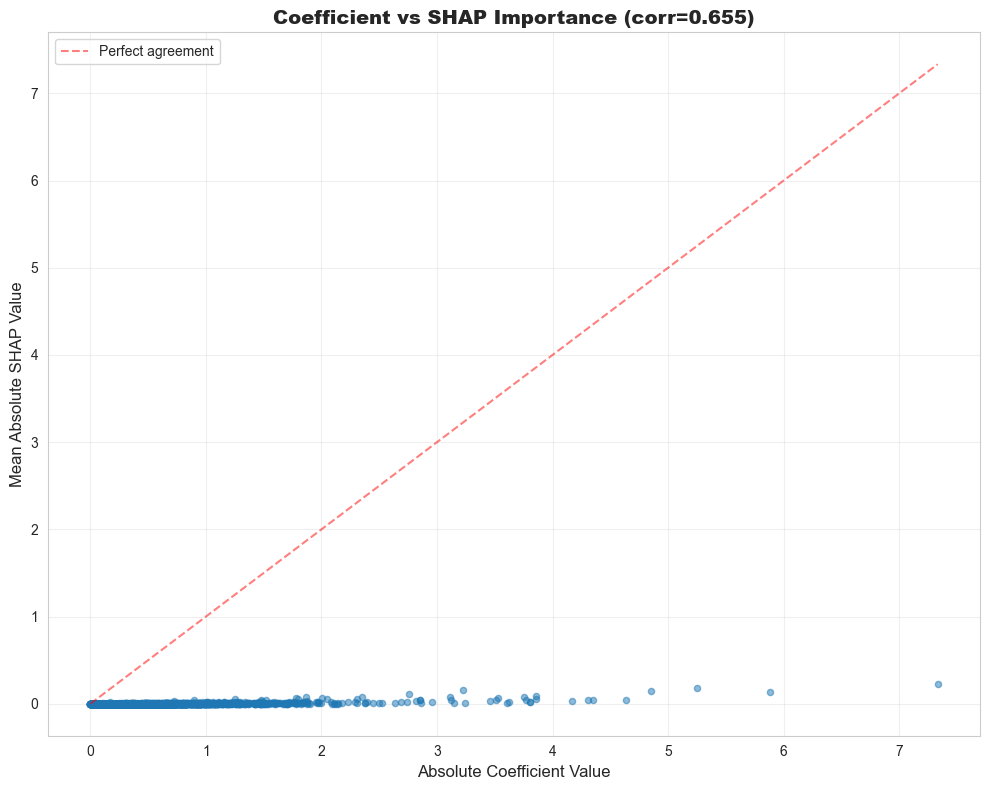

In [114]:
# Correlation between methods
correlation = importance_comparison['abs_coefficient'].corr(
    importance_comparison['mean_abs_shap']
)
print(f"\nCorrelation between Coefficient and SHAP importance: {correlation:.4f}")

# Visualize comparison
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(importance_comparison['abs_coefficient'], 
           importance_comparison['mean_abs_shap'],
           alpha=0.5, s=20)
ax.set_xlabel('Absolute Coefficient Value', fontsize=12)
ax.set_ylabel('Mean Absolute SHAP Value', fontsize=12)
ax.set_title(f'Coefficient vs SHAP Importance (corr={correlation:.3f})', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Add diagonal line
max_val = max(importance_comparison['abs_coefficient'].max(),
              importance_comparison['mean_abs_shap'].max())
ax.plot([0, max_val], [0, max_val], 'r--', alpha=0.5, label='Perfect agreement')
ax.legend()

plt.tight_layout()
plt.savefig('02_shap_coef_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

### 8I. ROC Curve and Confidence Analysis

In [115]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_test)
roc_auc = roc_auc_score(y_test, y_prob_test)

# Find optimal threshold
j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"\nROC AUC Score: {roc_auc:.4f}")
print(f"Optimal Threshold: {optimal_threshold:.4f}")
print(f"Current Threshold: 0.5000")

# Confidence analysis
test_df_analysis = pd.DataFrame({
    'true_label': y_test,
    'predicted_label': test_results['y_pred'],
    'probability': y_prob_test,
    'correct': y_test == test_results['y_pred']
})

test_df_analysis['confidence'] = np.where(
    test_results['y_pred'] == 1,
    y_prob_test,
    1 - y_prob_test
)


ROC AUC Score: 0.9437
Optimal Threshold: 0.4928
Current Threshold: 0.5000


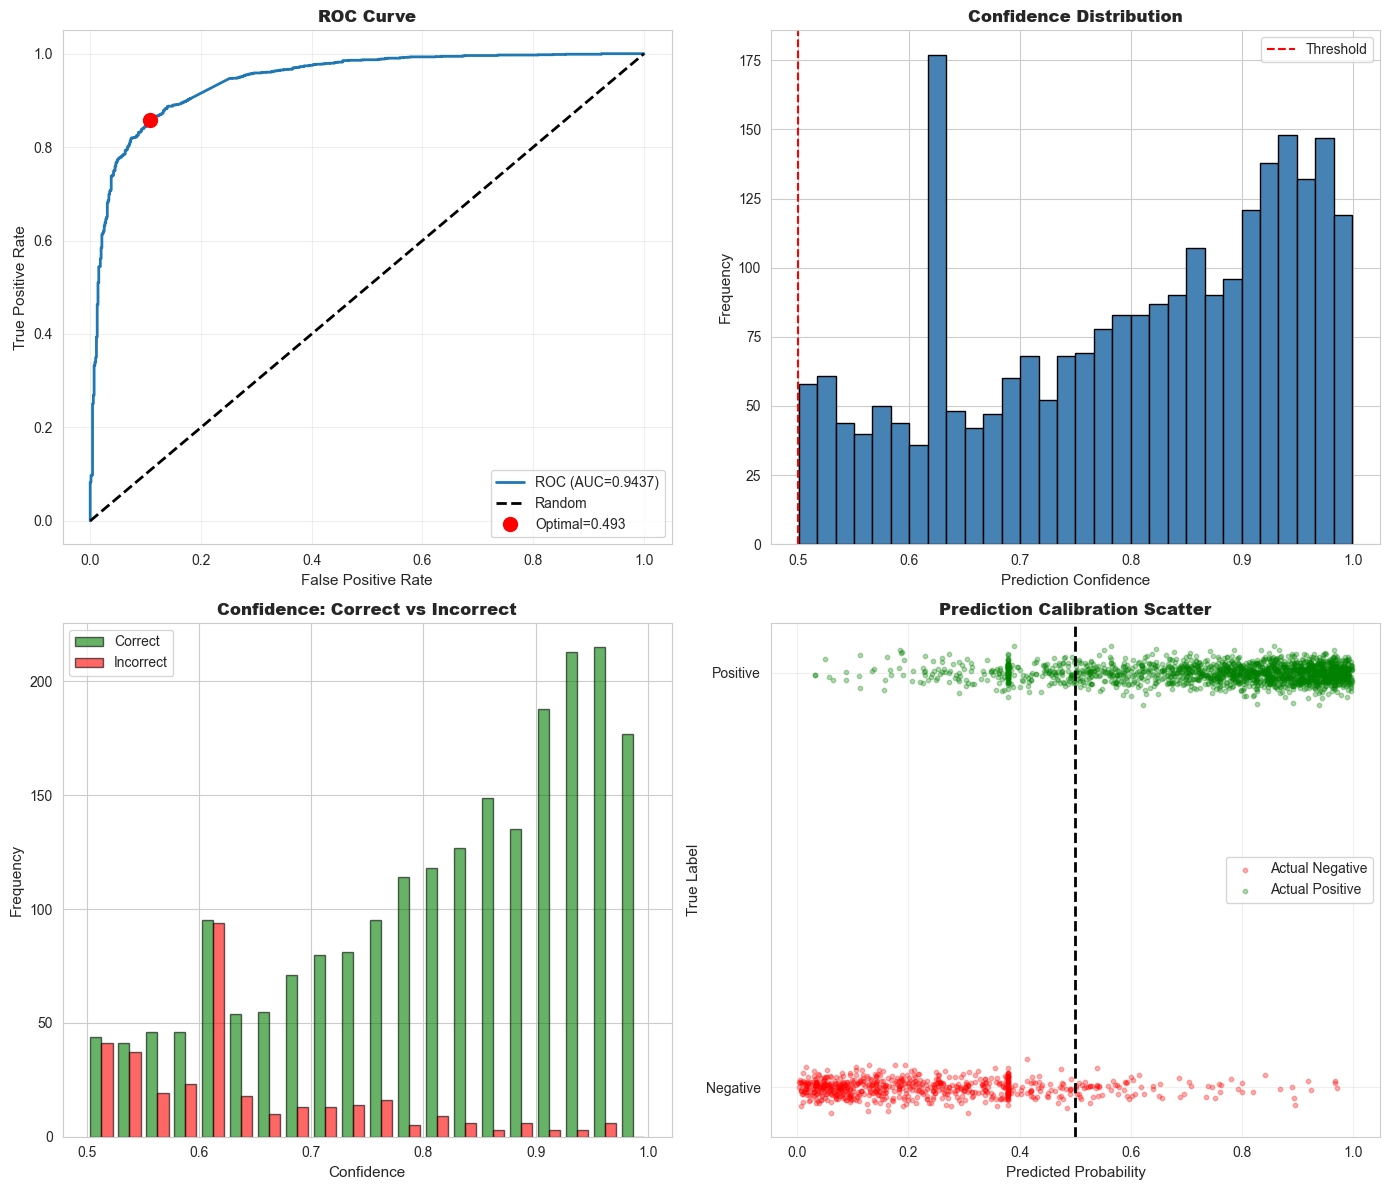

In [116]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# ROC Curve
axes[0, 0].plot(fpr, tpr, linewidth=2, label=f'ROC (AUC={roc_auc:.4f})')
axes[0, 0].plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random')
axes[0, 0].plot(fpr[optimal_idx], tpr[optimal_idx], 'ro', markersize=10,
                label=f'Optimal={optimal_threshold:.3f}')
axes[0, 0].set_xlabel('False Positive Rate', fontsize=11)
axes[0, 0].set_ylabel('True Positive Rate', fontsize=11)
axes[0, 0].set_title('ROC Curve', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Confidence distribution
axes[0, 1].hist(test_df_analysis['confidence'], bins=30, 
                color='steelblue', edgecolor='black')
axes[0, 1].set_xlabel('Prediction Confidence', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].set_title('Confidence Distribution', fontsize=12, fontweight='bold')
axes[0, 1].axvline(x=0.5, color='red', linestyle='--', label='Threshold')
axes[0, 1].legend()

# Confidence by correctness
correct_conf = test_df_analysis[test_df_analysis['correct']]['confidence']
incorrect_conf = test_df_analysis[~test_df_analysis['correct']]['confidence']
axes[1, 0].hist([correct_conf, incorrect_conf], bins=20, 
                label=['Correct', 'Incorrect'],
                color=['green', 'red'], alpha=0.6, edgecolor='black')
axes[1, 0].set_xlabel('Confidence', fontsize=11)
axes[1, 0].set_ylabel('Frequency', fontsize=11)
axes[1, 0].set_title('Confidence: Correct vs Incorrect', fontsize=12, fontweight='bold')
axes[1, 0].legend()

# Probability calibration scatter
axes[1, 1].scatter(y_prob_test[y_test == 0], 
                   np.zeros(sum(y_test == 0)) + np.random.normal(0, 0.02, sum(y_test == 0)),
                   alpha=0.3, s=10, c='red', label='Actual Negative')
axes[1, 1].scatter(y_prob_test[y_test == 1],
                   np.ones(sum(y_test == 1)) + np.random.normal(0, 0.02, sum(y_test == 1)),
                   alpha=0.3, s=10, c='green', label='Actual Positive')
axes[1, 1].axvline(x=0.5, color='black', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Predicted Probability', fontsize=11)
axes[1, 1].set_ylabel('True Label', fontsize=11)
axes[1, 1].set_title('Prediction Calibration Scatter', fontsize=12, fontweight='bold')
axes[1, 1].set_yticks([0, 1])
axes[1, 1].set_yticklabels(['Negative', 'Positive'])
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('02_roc_confidence_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Save Model and Results

In [117]:
# Save the trained model
joblib.dump(baseline_clf, 'baseline_model.pkl')

# Save metrics as JSON
results_dict = {
    'model_name': 'TF-IDF + Logistic Regression (Baseline)',
    'model_params': {
        'tfidf': {
            'max_features': 5000,
            'ngram_range': (1, 2),
            'max_df': 0.95,
            'min_df': 2
        },
        'logistic_regression': {
            'max_iter': 1000,
            'class_weight': 'balanced',
            'solver': 'saga'
        }
    },
    'train': {
        'accuracy': train_results['accuracy'],
        'precision': train_results['precision'],
        'recall': train_results['recall'],
        'f1': train_results['f1'],
        'roc_auc': train_results['roc_auc']
    },
    'validation': {
        'accuracy': val_results['accuracy'],
        'precision': val_results['precision'],
        'recall': val_results['recall'],
        'f1': val_results['f1'],
        'roc_auc': val_results['roc_auc']
    },
    'test': {
        'accuracy': test_results['accuracy'],
        'precision': test_results['precision'],
        'recall': test_results['recall'],
        'f1': test_results['f1'],
        'roc_auc': test_results['roc_auc']
    },
    'feature_importance': {
        'top_positive_words': top_positive_words[:10],
        'top_negative_words': top_negative_words[:10]
    }
}

with open('baseline_results.json', 'w') as f:
    json.dump(results_dict, f, indent=2)

## Summary

In [118]:
print(f"""
   Model: TF-IDF + Logistic Regression
   Training Data:
   - Train samples: {len(X_train):,}
   - Val samples: {len(X_val):,}
   - Test samples: {len(X_test):,}

   Model Configuration:
   - Vocabulary size: {len(tfidf.vocabulary_):,} features
   - N-grams: unigrams + bigrams
   - Class weight: balanced 

   Performance (Test Set):
   - Accuracy:  {test_results['accuracy']:.4f}
   - Precision: {test_results['precision']:.4f}
   - Recall:    {test_results['recall']:.4f}
   - F1-Score:  {test_results['f1']:.4f}
   - ROC AUC:   {test_results['roc_auc']:.4f}
""")


   Model: TF-IDF + Logistic Regression
   Training Data:
   - Train samples: 11,584
   - Val samples: 2,482
   - Test samples: 2,483

   Model Configuration:
   - Vocabulary size: 5,000 features
   - N-grams: unigrams + bigrams
   - Class weight: balanced 

   Performance (Test Set):
   - Accuracy:  0.8635
   - Precision: 0.9515
   - Recall:    0.8521
   - F1-Score:  0.8990
   - ROC AUC:   0.9437



# Model 2: MLP Model (TF-IDF Vectorized Embeddings) without HPO

## 1. Load Processed Data

In [119]:
# Load the train/val/test splits
train_df = pd.read_csv('train.csv')
val_df = pd.read_csv('val.csv')
test_df = pd.read_csv('test.csv')

In [120]:
print(f"Dataset Sizes:")
print(f"  Train set: {len(train_df):,} samples")
print(f"  Val set:   {len(val_df):,} samples")
print(f"  Test set:  {len(test_df):,} samples")
print(f"  Total:     {len(train_df) + len(val_df) + len(test_df):,} samples")

Dataset Sizes:
  Train set: 11,584 samples
  Val set:   2,482 samples
  Test set:  2,483 samples
  Total:     16,549 samples


In [121]:
# Extract features and labels
X_train = train_df["clean_comments"]
y_train = train_df["sentiment"].values

X_val = val_df["clean_comments"]
y_val = val_df["sentiment"].values

X_test = test_df["clean_comments"]
y_test = test_df["sentiment"].values

print(f"Class distribution:")
print(f"Train: {np.bincount(y_train)}")
print(f"Val:   {np.bincount(y_val)}")
print(f"Test:  {np.bincount(y_test)}")

Class distribution:
Train: [3320 8264]
Val:   [ 711 1771]
Test:  [ 712 1771]


## 2. Create TF-IDF Vectors

In [122]:
# Initialize TF-IDF vectorizer
vectorizer = TfidfVectorizer(
    max_features=3000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95
)

In [123]:
# Fit on training data and transform all sets
X_train_tfidf = vectorizer.fit_transform(X_train).toarray()
X_val_tfidf = vectorizer.transform(X_val).toarray()
X_test_tfidf = vectorizer.transform(X_test).toarray()

In [124]:
# Show feature statistics
vocab_size = len(vectorizer.vocabulary_)
print(f"TF-IDF Statistics:")
print(f"  Vocabulary size: {vocab_size:,} features")
print(f"  Feature matrix shape: {X_train_tfidf.shape}")
print(f"  Memory usage: {X_train_tfidf.nbytes / 1e6:.2f} MB")
print(f"  Sparsity: {(X_train_tfidf == 0).sum() / X_train_tfidf.size * 100:.1f}%")

TF-IDF Statistics:
  Vocabulary size: 3,000 features
  Feature matrix shape: (11584, 3000)
  Memory usage: 278.02 MB
  Sparsity: 99.5%


In [125]:
# Show example features
print(f"Example features (first 20):")
feature_names = vectorizer.get_feature_names_out()
for i in range(20):
    print(f"  {i+1:2d}. {feature_names[i]}")

Example features (first 20):
   1. 100
   2. 101
   3. 102
   4. 1st
   5. 200
   6. 2nd
   7. 300
   8. 3rd
   9. ability
  10. able
  11. absent
  12. absolute
  13. absolute bad
  14. absolutely
  15. absolutely amazing
  16. absolutely love
  17. academic
  18. accent
  19. accept
  20. accessible


## 3. Create PyTorch Dataset

In [129]:
class ReviewDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.FloatTensor(features)
        self.labels = torch.LongTensor(labels)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [130]:
# Create datasets
train_dataset = ReviewDataset(X_train_tfidf, y_train)
val_dataset = ReviewDataset(X_val_tfidf, y_val)
test_dataset = ReviewDataset(X_test_tfidf, y_test)

print(f"  Train dataset: {len(train_dataset):,} samples")
print(f"  Val dataset:   {len(val_dataset):,} samples")
print(f"  Test dataset:  {len(test_dataset):,} samples")

  Train dataset: 11,584 samples
  Val dataset:   2,482 samples
  Test dataset:  2,483 samples


In [131]:
# Create dataloaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Batch size: {batch_size}")
print(f"Batches - Train: {len(train_loader)}, Val: {len(val_loader)}, Test: {len(test_loader)}")

Batch size: 64
Batches - Train: 181, Val: 39, Test: 39


In [132]:
# Show example batch
example_features, example_labels = next(iter(train_loader))
print(f"Example batch:")
print(f"  Features shape: {example_features.shape}")
print(f"  Labels shape: {example_labels.shape}")
print(f"  Labels in batch: {example_labels[:10].tolist()}")

Example batch:
  Features shape: torch.Size([64, 3000])
  Labels shape: torch.Size([64])
  Labels in batch: [1, 1, 1, 0, 0, 1, 1, 0, 1, 0]


## 4. Define MLP Model

In [133]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dims=[512, 256, 128], num_classes=2, dropout=0.4):
        super(MLPClassifier, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev_dim = hidden_dim
        
        layers.append(nn.Linear(prev_dim, num_classes))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

In [134]:
# Create model
input_dim = X_train_tfidf.shape[1]
hidden_dims = [512, 256, 128]
dropout_rate = 0.4

model = MLPClassifier(
    input_dim=input_dim,
    hidden_dims=hidden_dims,
    num_classes=2,
    dropout=dropout_rate
).to(device)

In [135]:
# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model Architecture:")
print(model)

print(f"Parameter Count:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Model size: {total_params * 4 / 1e6:.2f} MB (float32)")

Model Architecture:
MLPClassifier(
  (network): Sequential(
    (0): Linear(in_features=3000, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.4, inplace=False)
    (12): Linear(in_features=128, out_features=2, bias=True)
  )
)
Parameter Count:
  Total parameters: 1,702,786
  Trainable parameters: 1,702,786
  Model size: 6.81 MB (float32)


## 5. Setup Training

In [136]:
# Calculate class weights for imbalanced data
class_counts = np.bincount(y_train)
class_weights = torch.FloatTensor([1.0 / c for c in class_counts]).to(device)

# Normalize weights so they sum to num_classes
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=3, verbose=True
)

print(f"Class Imbalance Handling:")
print(f"  Class counts: Negative={class_counts[0]:,}, Positive={class_counts[1]:,}")
print(f"  Class weights: {class_weights.tolist()}")

Class Imbalance Handling:
  Class counts: Negative=3,320, Positive=8,264
  Class weights: [0.0003012048255186528, 0.0001210067784995772]


In [137]:
# Loss function
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [138]:
# Optimizer
learning_rate = 0.001
weight_decay = 1e-5
optimizer = optim.Adam(
    model.parameters(), 
    lr=learning_rate, 
    weight_decay=weight_decay
)

In [139]:
# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='max',        # Maximize validation F1
    factor=0.5,        # Reduce LR by half
    patience=3,        # Wait 3 epochs before reducing
    verbose=True,
    min_lr=1e-6
)

## 6. Training Functions

In [140]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()  # Set model to training mode
    
    total_loss = 0
    correct = 0
    total = 0
    
    for features, labels in loader:
        # Move data to device
        features = features.to(device)
        labels = labels.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(features)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        # Statistics
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    avg_loss = total_loss / len(loader)
    accuracy = correct / total
    
    return avg_loss, accuracy

In [141]:
def evaluate(model, loader, criterion, device):
    model.eval()  # Set model to evaluation mode
    
    total_loss = 0
    all_preds = []
    all_probs = []
    all_labels = []
    
    with torch.no_grad():  # Disable gradient computation
        for features, labels in loader:
            features = features.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(features)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            
            # Get predictions and probabilities
            probs = torch.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)
            
            # Store results (convert to Python lists to avoid numpy issue)
            all_preds.extend(predicted.cpu().tolist())
            all_probs.extend(probs[:, 1].cpu().tolist())
            all_labels.extend(labels.cpu().tolist())
    
    # Convert to numpy arrays for sklearn metrics
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)
    
    # Calculate metrics
    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    
    return avg_loss, accuracy, precision, recall, f1, all_preds, all_probs

## 7. Train Model

In [142]:
# Training hyperparameters
num_epochs = 30
early_stop_patience = 7
best_val_f1 = 0
patience_counter = 0

In [143]:
# Initialize history tracking
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'val_precision': [],
    'val_recall': [],
    'val_f1': [],
    'learning_rates': []
}

In [144]:
# Training loop
for epoch in range(num_epochs):
    # Train for one epoch
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Evaluate on validation set
    val_loss, val_acc, val_prec, val_rec, val_f1, _, _ = evaluate(
        model, val_loader, criterion, device
    )
    
    # Update learning rate based on validation F1
    scheduler.step(val_f1)
    current_lr = optimizer.param_groups[0]['lr']
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_precision'].append(val_prec)
    history['val_recall'].append(val_rec)
    history['val_f1'].append(val_f1)
    history['learning_rates'].append(current_lr)
    
    # Print progress
    status = ""
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), 'mlp_best_model.pth')
        status = "BEST MODEL ✓"
        patience_counter = 0
    else:
        patience_counter += 1
        status = f"Patience: {patience_counter}/{early_stop_patience}"
    
    print(f"{epoch+1:6d} | {train_loss:11.4f} {train_acc:10.4f} | "
          f"{val_loss:9.4f} {val_acc:8.4f} {val_f1:7.4f} | {status:>15}")
    
    # Early stopping check
    if patience_counter >= early_stop_patience:
        print(f"\n{'='*80}")
        print(f"Early stopping triggered at epoch {epoch+1}")
        print(f"Best validation F1: {best_val_f1:.4f}")
        print(f"{'='*80}")
        break

if patience_counter < early_stop_patience:
    print(f"\n{'='*80}")
    print(f"Training completed all {num_epochs} epochs")
    print(f"Best validation F1: {best_val_f1:.4f}")
    print(f"{'='*80}")

     1 |      0.3988     0.8020 |    0.3042   0.8558  0.8931 |    BEST MODEL ✓
     2 |      0.2329     0.8929 |    0.3206   0.8582  0.8954 |    BEST MODEL ✓
     3 |      0.1692     0.9174 |    0.4169   0.8554  0.8941 |   Patience: 1/7
     4 |      0.1451     0.9264 |    0.4598   0.8650  0.9029 |    BEST MODEL ✓
     5 |      0.1194     0.9375 |    0.5228   0.8646  0.9033 |    BEST MODEL ✓
     6 |      0.1147     0.9386 |    0.5234   0.8618  0.9008 |   Patience: 1/7
     7 |      0.1022     0.9450 |    0.5171   0.8558  0.8949 |   Patience: 2/7
     8 |      0.0881     0.9498 |    0.6310   0.8634  0.9017 |   Patience: 3/7
Epoch 00009: reducing learning rate of group 0 to 5.0000e-04.
     9 |      0.0953     0.9485 |    0.6250   0.8646  0.9025 |   Patience: 4/7
    10 |      0.0785     0.9554 |    0.5807   0.8574  0.8965 |   Patience: 5/7
    11 |      0.0629     0.9601 |    0.6503   0.8602  0.8991 |   Patience: 6/7
    12 |      0.0635     0.9604 |    0.6589   0.8525  0.8923 |   Pati

## 8. Plot Training History


Saved: 03_mlp_training_history.png


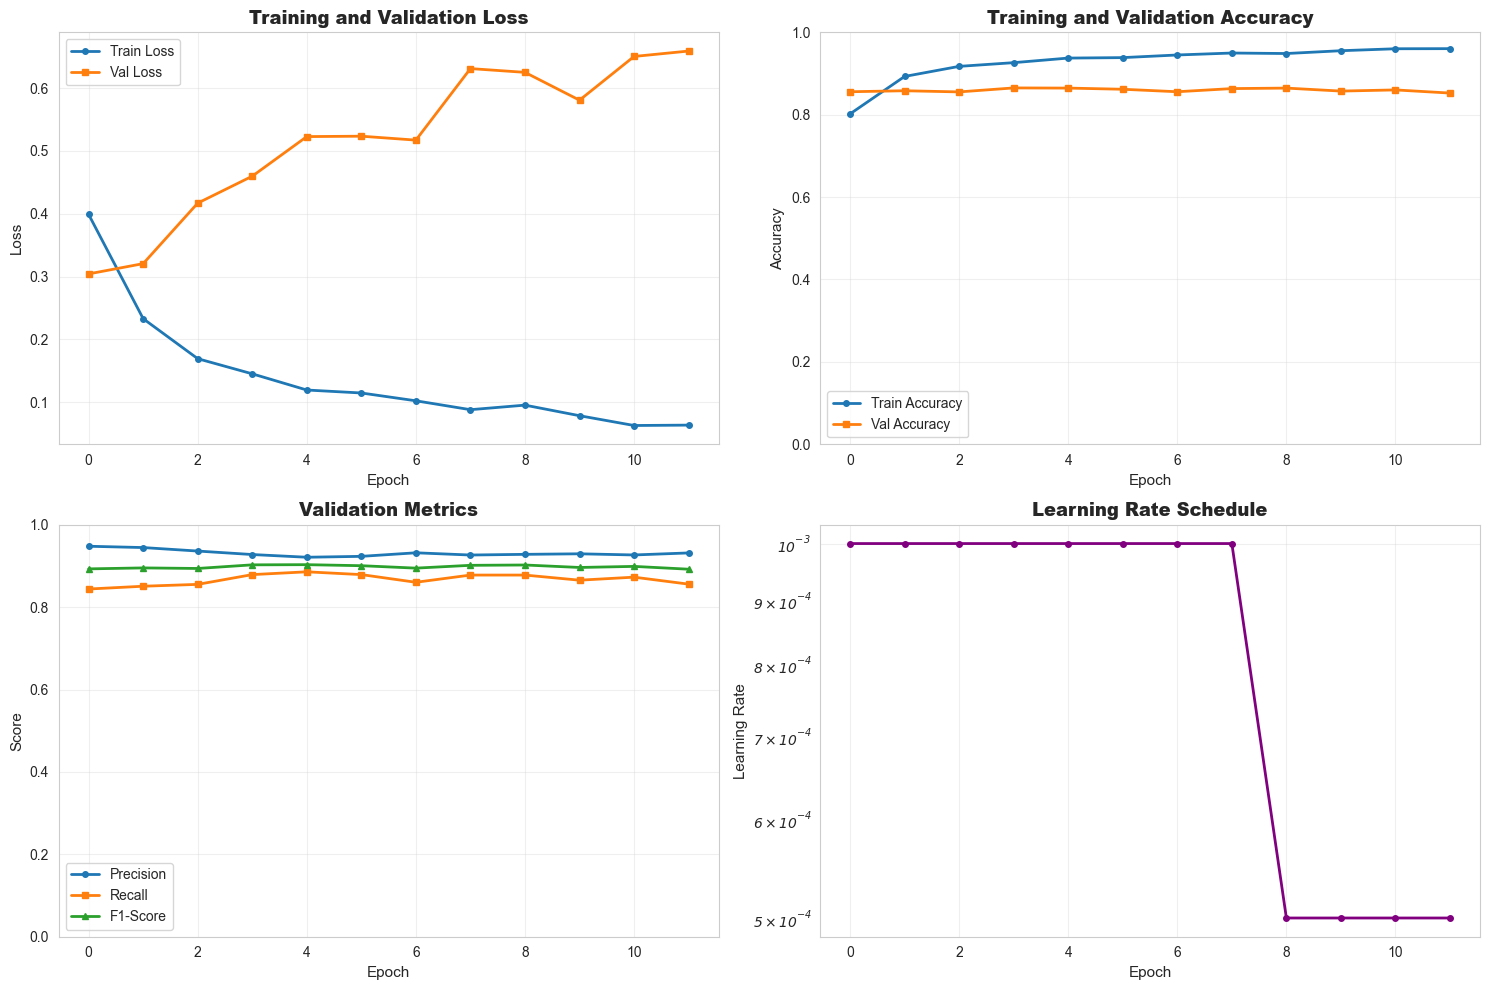

In [145]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Loss curves
axes[0, 0].plot(history['train_loss'], label='Train Loss', linewidth=2, marker='o', markersize=4)
axes[0, 0].plot(history['val_loss'], label='Val Loss', linewidth=2, marker='s', markersize=4)
axes[0, 0].set_xlabel('Epoch', fontsize=11)
axes[0, 0].set_ylabel('Loss', fontsize=11)
axes[0, 0].set_title('Training and Validation Loss', fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Accuracy curves
axes[0, 1].plot(history['train_acc'], label='Train Accuracy', linewidth=2, marker='o', markersize=4)
axes[0, 1].plot(history['val_acc'], label='Val Accuracy', linewidth=2, marker='s', markersize=4)
axes[0, 1].set_xlabel('Epoch', fontsize=11)
axes[0, 1].set_ylabel('Accuracy', fontsize=11)
axes[0, 1].set_title('Training and Validation Accuracy', fontsize=13, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_ylim([0, 1])

# Plot 3: Validation metrics (Precision, Recall, F1)
axes[1, 0].plot(history['val_precision'], label='Precision', linewidth=2, marker='o', markersize=4)
axes[1, 0].plot(history['val_recall'], label='Recall', linewidth=2, marker='s', markersize=4)
axes[1, 0].plot(history['val_f1'], label='F1-Score', linewidth=2, marker='^', markersize=4)
axes[1, 0].set_xlabel('Epoch', fontsize=11)
axes[1, 0].set_ylabel('Score', fontsize=11)
axes[1, 0].set_title('Validation Metrics', fontsize=13, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_ylim([0, 1])

# Plot 4: Learning rate schedule
axes[1, 1].plot(history['learning_rates'], linewidth=2, marker='o', markersize=4, color='purple')
axes[1, 1].set_xlabel('Epoch', fontsize=11)
axes[1, 1].set_ylabel('Learning Rate', fontsize=11)
axes[1, 1].set_title('Learning Rate Schedule', fontsize=13, fontweight='bold')
axes[1, 1].set_yscale('log')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('03_mlp_training_history.png', dpi=150, bbox_inches='tight')
print("\nSaved: 03_mlp_training_history.png")
plt.show()

In [146]:
# Print training summary
print(f"Training Summary:")
print(f"  Total epochs trained: {len(history['train_loss'])}")
print(f"  Best validation F1: {best_val_f1:.4f}")
print(f"  Final learning rate: {history['learning_rates'][-1]:.2e}")
print(f"  Final train accuracy: {history['train_acc'][-1]:.4f}")
print(f"  Final val accuracy: {history['val_acc'][-1]:.4f}")

Training Summary:
  Total epochs trained: 12
  Best validation F1: 0.9033
  Final learning rate: 5.00e-04
  Final train accuracy: 0.9604
  Final val accuracy: 0.8525


In [147]:
# Check for overfitting
train_val_gap = history['train_acc'][-1] - history['val_acc'][-1]
print(f"Overfitting Check:")
print(f"  Train-Val accuracy gap: {train_val_gap:.4f}")
if train_val_gap < 0.05:
    print(f"  Status: No significant overfitting detected")
elif train_val_gap < 0.10:
    print(f"  Status: Mild overfitting")
else:
    print(f"  Status: Significant overfitting detected")

Overfitting Check:
  Train-Val accuracy gap: 0.1078
  Status: Significant overfitting detected


## 9. Load Best Model and Evaluate on All Splits

In [148]:
# Load best model
model.load_state_dict(torch.load('mlp_best_model.pth'))

<All keys matched successfully>

In [149]:
def full_evaluation(model, loader, set_name, y_true):
    """
    Comprehensive evaluation with metrics and visualizations.
    """
    _, acc, prec, rec, f1, preds, probs = evaluate(model, loader, criterion, device)
    
    # Calculate ROC AUC
    roc_auc = None
    if len(np.unique(y_true)) > 1:
        roc_auc = roc_auc_score(y_true, probs)
    
    # Print metrics
    print(f"\n{'='*80}")
    print(f"{set_name} SET RESULTS")
    print(f"{'='*80}")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f} (of predicted positives, how many are correct)")
    print(f"Recall:    {rec:.4f} (of actual positives, how many we found)")
    print(f"F1-Score:  {f1:.4f} (harmonic mean of precision & recall)")
    if roc_auc:
        print(f"ROC AUC:   {roc_auc:.4f}")
    
    # Classification report
    print(f"\n{set_name} Classification Report:")
    print(classification_report(
        y_true, preds,
        target_names=['Negative (0)', 'Positive (1)'],
        digits=4
    ))
    
    # Confusion matrix
    cm = confusion_matrix(y_true, preds)
    
    fig, ax = plt.subplots(figsize=(8, 7))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap="Blues",
        xticklabels=["Negative", "Positive"],
        yticklabels=["Negative", "Positive"],
        cbar_kws={'label': 'Count'},
        ax=ax,
        annot_kws={'size': 14, 'weight': 'bold'}
    )
    
    ax.set_xlabel("Predicted Label", fontsize=12, fontweight='bold')
    ax.set_ylabel("True Label", fontsize=12, fontweight='bold')
    ax.set_title(f"MLP Confusion Matrix - {set_name} Set",
                 fontsize=14, fontweight='bold', pad=20)
    
    # Add accuracy annotation
    ax.text(1, -0.3, f'Accuracy: {acc:.4f} | F1-Score: {f1:.4f}',
            ha='center', fontsize=11, transform=ax.transAxes)
    
    plt.tight_layout()
    filename = f'03_mlp_confusion_matrix_{set_name.lower()}.png'
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    print(f"\nSaved confusion matrix: {filename}")
    plt.show()
    
    return {
        'accuracy': float(acc),
        'precision': float(prec),
        'recall': float(rec),
        'f1': float(f1),
        'roc_auc': float(roc_auc) if roc_auc else None,
        'predictions': preds,
        'probabilities': probs
    }


TRAIN SET RESULTS
Accuracy:  0.9574
Precision: 0.9952 (of predicted positives, how many are correct)
Recall:    0.9449 (of actual positives, how many we found)
F1-Score:  0.9694 (harmonic mean of precision & recall)
ROC AUC:   0.5050

TRAIN Classification Report:
              precision    recall  f1-score   support

Negative (0)     0.2882    0.3244    0.3052      3320
Positive (1)     0.7142    0.6781    0.6957      8264

    accuracy                         0.5767     11584
   macro avg     0.5012    0.5013    0.5005     11584
weighted avg     0.5921    0.5767    0.5838     11584


Saved confusion matrix: 03_mlp_confusion_matrix_train.png


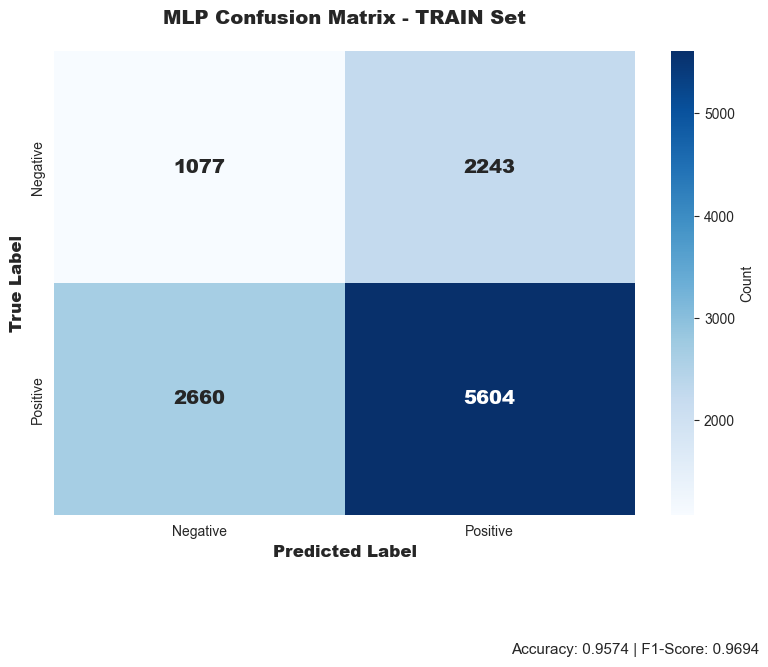

In [150]:
# Evaluate on all splits
train_results = full_evaluation(model, train_loader, "TRAIN", y_train)


VALIDATION SET RESULTS
Accuracy:  0.8646
Precision: 0.9213 (of predicted positives, how many are correct)
Recall:    0.8859 (of actual positives, how many we found)
F1-Score:  0.9033 (harmonic mean of precision & recall)
ROC AUC:   0.9322

VALIDATION Classification Report:
              precision    recall  f1-score   support

Negative (0)     0.7407    0.8115    0.7745       711
Positive (1)     0.9213    0.8859    0.9033      1771

    accuracy                         0.8646      2482
   macro avg     0.8310    0.8487    0.8389      2482
weighted avg     0.8696    0.8646    0.8664      2482


Saved confusion matrix: 03_mlp_confusion_matrix_validation.png


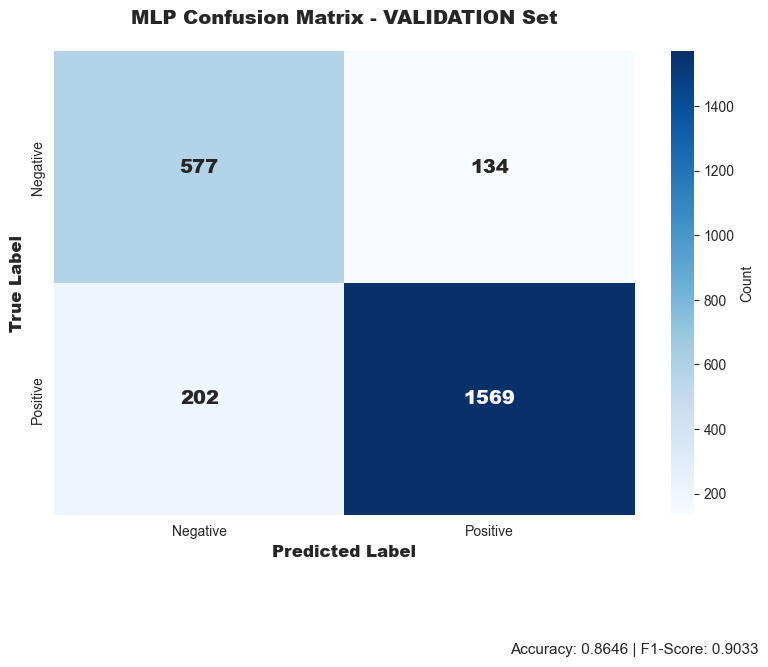

In [151]:
val_results = full_evaluation(model, val_loader, "VALIDATION", y_val)


TEST SET RESULTS
Accuracy:  0.8514
Precision: 0.9285 (of predicted positives, how many are correct)
Recall:    0.8577 (of actual positives, how many we found)
F1-Score:  0.8917 (harmonic mean of precision & recall)
ROC AUC:   0.9227

TEST Classification Report:
              precision    recall  f1-score   support

Negative (0)     0.7025    0.8357    0.7633       712
Positive (1)     0.9285    0.8577    0.8917      1771

    accuracy                         0.8514      2483
   macro avg     0.8155    0.8467    0.8275      2483
weighted avg     0.8637    0.8514    0.8549      2483


Saved confusion matrix: 03_mlp_confusion_matrix_test.png


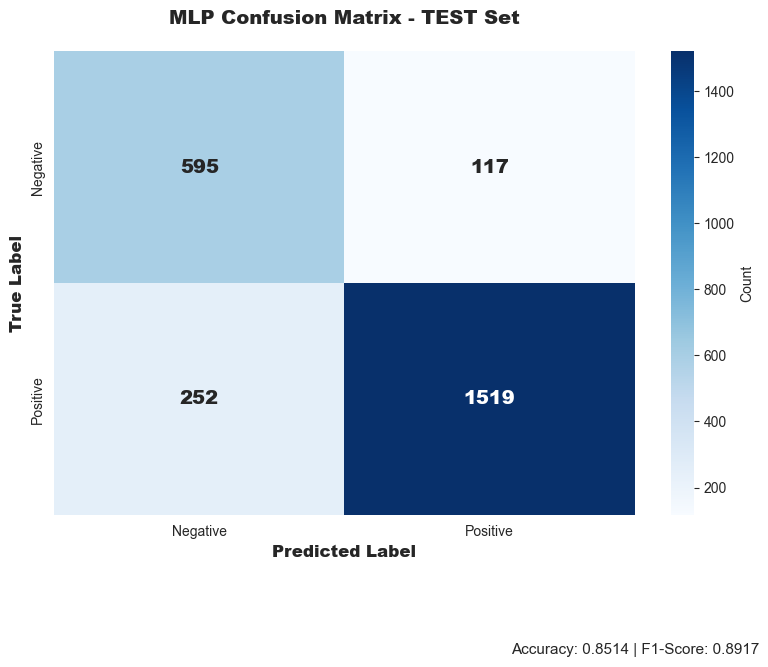

In [152]:
test_results = full_evaluation(model, test_loader, "TEST", y_test)

## 10. Compare with Baseline Model

In [153]:
# Load baseline results
with open('baseline_results.json', 'r') as f:
    baseline = json.load(f)

# Create comparison dataframe
comparison = pd.DataFrame({
    'Model': ['Baseline (TF-IDF + LogReg)', 'MLP (TF-IDF + Deep NN)'],
    'Test Accuracy': [baseline['test']['accuracy'], test_results['accuracy']],
    'Test Precision': [baseline['test']['precision'], test_results['precision']],
    'Test Recall': [baseline['test']['recall'], test_results['recall']],
    'Test F1-Score': [baseline['test']['f1'], test_results['f1']]
})

print("\nModel Comparison - Test Set:")
print(comparison.to_string(index=False))


Model Comparison - Test Set:
                     Model  Test Accuracy  Test Precision  Test Recall  Test F1-Score
Baseline (TF-IDF + LogReg)       0.863472        0.951450     0.852061       0.899017
    MLP (TF-IDF + Deep NN)       0.851389        0.928484     0.857708       0.891694


In [154]:
# Calculate improvements
improvements = {
    'accuracy': test_results['accuracy'] - baseline['test']['accuracy'],
    'precision': test_results['precision'] - baseline['test']['precision'],
    'recall': test_results['recall'] - baseline['test']['recall'],
    'f1': test_results['f1'] - baseline['test']['f1']
}

print(f"\nImprovements over Baseline:")
for metric, improvement in improvements.items():
    sign = "+" if improvement >= 0 else ""
    pct = improvement * 100
    status = "BETTER" if improvement > 0 else ("WORSE" if improvement < 0 else "SAME")
    print(f"  {metric.capitalize():12s}: {sign}{improvement:.4f} ({sign}{pct:.2f}%) - {status}")


Improvements over Baseline:
  Accuracy    : -0.0121 (-1.21%) - WORSE
  Precision   : -0.0230 (-2.30%) - WORSE
  Recall      : +0.0056 (+0.56%) - BETTER
  F1          : -0.0073 (-0.73%) - WORSE



Saved: 03_mlp_baseline_comparison.png


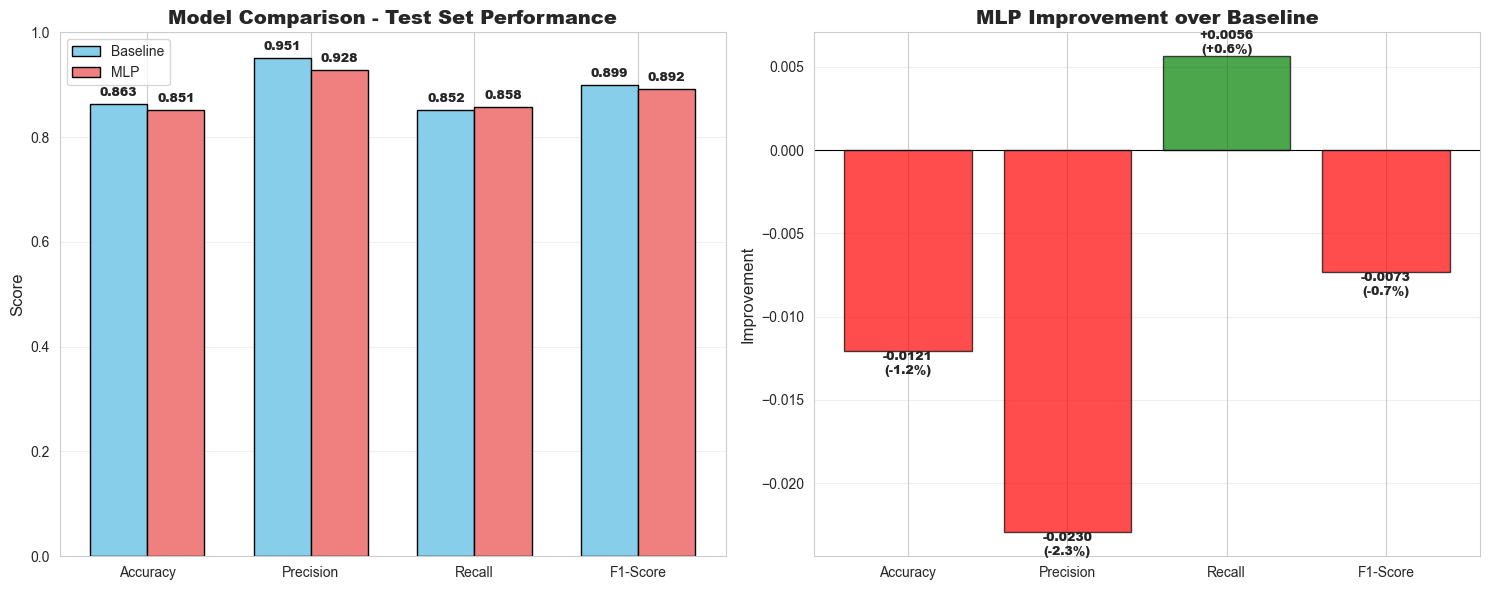


Overall Assessment:
  MLP performs similarly to baseline (avg: -0.92%)


In [155]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Bar chart comparison
x = np.arange(4)
width = 0.35

baseline_vals = [
    baseline['test']['accuracy'],
    baseline['test']['precision'],
    baseline['test']['recall'],
    baseline['test']['f1']
]
mlp_vals = [
    test_results['accuracy'],
    test_results['precision'],
    test_results['recall'],
    test_results['f1']
]

bars1 = axes[0].bar(x - width/2, baseline_vals, width, label='Baseline',
                    color='skyblue', edgecolor='black')
bars2 = axes[0].bar(x + width/2, mlp_vals, width, label='MLP',
                    color='lightcoral', edgecolor='black')

axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Model Comparison - Test Set Performance',
                  fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(['Accuracy', 'Precision', 'Recall', 'F1-Score'])
axes[0].legend()
axes[0].set_ylim([0, 1])
axes[0].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (b_val, m_val) in enumerate(zip(baseline_vals, mlp_vals)):
    axes[0].text(i - width/2, b_val + 0.01, f'{b_val:.3f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')
    axes[0].text(i + width/2, m_val + 0.01, f'{m_val:.3f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

# Improvement bars
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
improvement_vals = [improvements['accuracy'], improvements['precision'],
                   improvements['recall'], improvements['f1']]
colors = ['green' if v > 0 else 'red' for v in improvement_vals]

bars = axes[1].bar(metrics, improvement_vals, color=colors, edgecolor='black', alpha=0.7)
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
axes[1].set_ylabel('Improvement', fontsize=12)
axes[1].set_title('MLP Improvement over Baseline',
                 fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, val in zip(bars, improvement_vals):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{val:+.4f}\n({val*100:+.1f}%)',
                ha='center', va='bottom' if height > 0 else 'top',
                fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('03_mlp_baseline_comparison.png', dpi=150, bbox_inches='tight')
print("\nSaved: 03_mlp_baseline_comparison.png")
plt.show()

# Overall assessment
print(f"\nOverall Assessment:")
avg_improvement = np.mean(list(improvements.values()))
if avg_improvement > 0.01:
    print(f"  MLP shows significant improvement (avg: +{avg_improvement*100:.2f}%)")
elif avg_improvement > 0:
    print(f"  MLP shows slight improvement (avg: +{avg_improvement*100:.2f}%)")
elif avg_improvement > -0.01:
    print(f"  MLP performs similarly to baseline (avg: {avg_improvement*100:.2f}%)")
else:
    print(f"  Baseline performs better (avg: {avg_improvement*100:.2f}%)")

## 11. Additional Analysis

Saved: 03_mlp_roc_curve.png


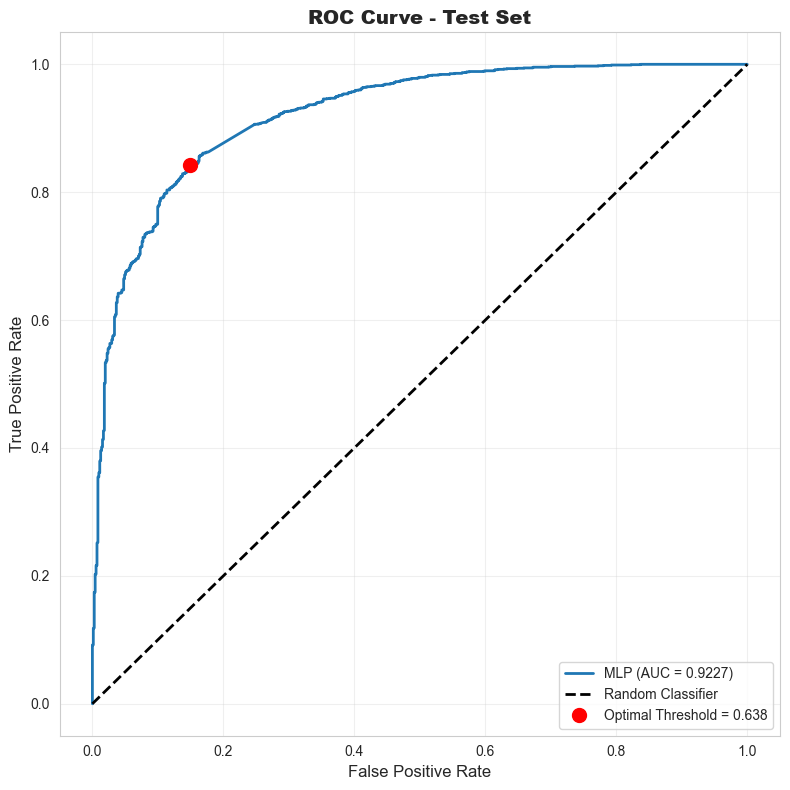

In [156]:
# ROC Curve
if test_results['roc_auc']:
    fpr, tpr, thresholds = roc_curve(y_test, test_results['probabilities'])
    
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(fpr, tpr, linewidth=2, label=f'MLP (AUC = {test_results["roc_auc"]:.4f})')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')
    
    # Find optimal threshold (Youden's J)
    j_scores = tpr - fpr
    optimal_idx = np.argmax(j_scores)
    optimal_threshold = thresholds[optimal_idx]
    ax.plot(fpr[optimal_idx], tpr[optimal_idx], 'ro', markersize=10,
            label=f'Optimal Threshold = {optimal_threshold:.3f}')
    
    ax.set_xlabel('False Positive Rate', fontsize=12)
    ax.set_ylabel('True Positive Rate', fontsize=12)
    ax.set_title('ROC Curve - Test Set', fontsize=14, fontweight='bold')
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('03_mlp_roc_curve.png', dpi=150, bbox_inches='tight')
    print("Saved: 03_mlp_roc_curve.png")
    plt.show()

In [157]:
# Error analysis
test_df_analysis = pd.DataFrame({
    'text': X_test.values,
    'true_label': y_test,
    'predicted_label': test_results['predictions'],
    'probability': test_results['probabilities'],
    'correct': y_test == test_results['predictions']
})

false_positives = test_df_analysis[
    (test_df_analysis['true_label'] == 0) &
    (test_df_analysis['predicted_label'] == 1)
]

false_negatives = test_df_analysis[
    (test_df_analysis['true_label'] == 1) &
    (test_df_analysis['predicted_label'] == 0)
]

print(f"Error Statistics:")
print(f"  Total predictions: {len(test_df_analysis):,}")
print(f"  Correct: {test_df_analysis['correct'].sum():,} ({test_df_analysis['correct'].mean()*100:.1f}%)")
print(f"  Incorrect: {(~test_df_analysis['correct']).sum():,} ({(~test_df_analysis['correct']).mean()*100:.1f}%)")
print(f"    False Positives: {len(false_positives):,} (predicted positive, actually negative)")
print(f"    False Negatives: {len(false_negatives):,} (predicted negative, actually positive)")

Error Statistics:
  Total predictions: 2,483
  Correct: 2,114 (85.1%)
  Incorrect: 369 (14.9%)
    False Positives: 117 (predicted positive, actually negative)
    False Negatives: 252 (predicted negative, actually positive)


In [158]:
# Show example errors
if len(false_positives) > 0:
    print(f"\nExample FALSE POSITIVES (model too optimistic):")
    for i, row in false_positives.head(2).iterrows():
        print(f"\n  Confidence: {row['probability']:.2%}")
        print(f"  Text: {row['text'][:300]}")

if len(false_negatives) > 0:
    print(f"\nExample FALSE NEGATIVES (model too pessimistic):")
    for i, row in false_negatives.head(2).iterrows():
        print(f"\n  Confidence: {1-row['probability']:.2%}")
        print(f"  Text: {row['text'][:300]}")


Example FALSE POSITIVES (model too optimistic):

  Confidence: 99.12%
  Text: mcauliffe mean man good scholar ineffective teacher fatal penchant unintereste tangent love ero class poorly plan conduct slack disorient style get class seek guidance great reading

  Confidence: 89.15%
  Text: enjoy bizarre book choice ton work class way reading outside class shy weary want lot class participation

Example FALSE NEGATIVES (model too pessimistic):

  Confidence: 95.57%
  Text: take online class easy answer wrong test show say book quickly change grade reopen test want well grade meet recommend

  Confidence: 89.66%
  Text: fail class blame ton memorization astronomy expect test textbook mention class story corny joke easy stay awake night class


## 12. Save Results

In [159]:
# Save vectorizer
joblib.dump(vectorizer, 'mlp_vectorizer.pkl')

# Save training history
with open('mlp_training_history.json', 'w') as f:
    json.dump(history, f, indent=2)

In [160]:
# Save final results
mlp_results = {
    'model_name': 'Multi-Layer Perceptron with TF-IDF Features',
    'architecture': {
        'input_dim': input_dim,
        'hidden_dims': hidden_dims,
        'dropout': dropout_rate,
        'total_parameters': total_params,
        'trainable_parameters': trainable_params
    },
    'training': {
        'epochs_trained': len(history['train_loss']),
        'best_val_f1': float(best_val_f1),
        'optimizer': 'Adam',
        'learning_rate': learning_rate,
        'weight_decay': weight_decay,
        'batch_size': batch_size,
        'early_stopping': early_stop_patience
    },
    'train': train_results,
    'validation': val_results,
    'test': test_results
}

In [161]:
# Remove predictions and probabilities (too large)
for split in ['train', 'validation', 'test']:
    if 'predictions' in mlp_results[split]:
        del mlp_results[split]['predictions']
    if 'probabilities' in mlp_results[split]:
        del mlp_results[split]['probabilities']

with open('mlp_results.json', 'w') as f:
    json.dump(mlp_results, f, indent=2)

In [162]:
# Save full model info
torch.save({
    'model_state_dict': model.state_dict(),
    'input_dim': input_dim,
    'hidden_dims': hidden_dims,
    'dropout': dropout_rate,
    'optimizer_state_dict': optimizer.state_dict(),
    'best_val_f1': best_val_f1,
    'epoch': len(history['train_loss'])
}, 'mlp_full_checkpoint.pth')

## 13. Summary

In [163]:
# Build summary string without nested f-string
hidden_layers_str = ' -> '.join(map(str, hidden_dims))
roc_auc_str = f"{test_results['roc_auc']:.4f}" if test_results['roc_auc'] else 'N/A'

print(f"""
Model: Multi-Layer Perceptron with TF-IDF Features

Architecture:
  Input: {input_dim:,} TF-IDF features
  Hidden layers: {hidden_layers_str} neurons
  Dropout: {dropout_rate}
  Output: 2 classes (binary sentiment)
  Total parameters: {total_params:,}

Training:
  Epochs trained: {len(history['train_loss'])}
  Best validation F1: {best_val_f1:.4f}
  Final learning rate: {history['learning_rates'][-1]:.2e}

Performance (Test Set):
  Accuracy:  {test_results['accuracy']:.4f}
  Precision: {test_results['precision']:.4f}
  Recall:    {test_results['recall']:.4f}
  F1-Score:  {test_results['f1']:.4f}
  ROC AUC:   {roc_auc_str}

Files Created:
  Models:
    - mlp_best_model.pth (best model weights)
    - mlp_full_checkpoint.pth (full checkpoint)
    - mlp_vectorizer.pkl (TF-IDF vectorizer)
  
  Results:
    - mlp_results.json (all metrics)
    - mlp_training_history.json (training logs)
  
  Visualizations:
    - 03_mlp_training_history.png (4 training plots)
    - 03_mlp_confusion_matrix_train.png
    - 03_mlp_confusion_matrix_validation.png
    - 03_mlp_confusion_matrix_test.png
    - 03_mlp_baseline_comparison.png
    - 03_mlp_roc_curve.png
""")


Model: Multi-Layer Perceptron with TF-IDF Features

Architecture:
  Input: 3,000 TF-IDF features
  Hidden layers: 512 -> 256 -> 128 neurons
  Dropout: 0.4
  Output: 2 classes (binary sentiment)
  Total parameters: 1,702,786

Training:
  Epochs trained: 12
  Best validation F1: 0.9033
  Final learning rate: 5.00e-04

Performance (Test Set):
  Accuracy:  0.8514
  Precision: 0.9285
  Recall:    0.8577
  F1-Score:  0.8917
  ROC AUC:   0.9227

Files Created:
  Models:
    - mlp_best_model.pth (best model weights)
    - mlp_full_checkpoint.pth (full checkpoint)
    - mlp_vectorizer.pkl (TF-IDF vectorizer)
  
  Results:
    - mlp_results.json (all metrics)
    - mlp_training_history.json (training logs)
  
  Visualizations:
    - 03_mlp_training_history.png (4 training plots)
    - 03_mlp_confusion_matrix_train.png
    - 03_mlp_confusion_matrix_validation.png
    - 03_mlp_confusion_matrix_test.png
    - 03_mlp_baseline_comparison.png
    - 03_mlp_roc_curve.png



# Model 3: MLP Model (GloVe Embeddings) without HPO

## 1. Load Preprocessed Data

In [164]:
# Load the train/val/test splits
train_df = pd.read_csv('train.csv')
val_df = pd.read_csv('val.csv')
test_df = pd.read_csv('test.csv')

In [165]:
print(f"Dataset Sizes:")
print(f"  Train set: {len(train_df):,} samples")
print(f"  Val set:   {len(val_df):,} samples")
print(f"  Test set:  {len(test_df):,} samples")
print(f"  Total:     {len(train_df) + len(val_df) + len(test_df):,} samples")

Dataset Sizes:
  Train set: 11,584 samples
  Val set:   2,482 samples
  Test set:  2,483 samples
  Total:     16,549 samples


In [166]:
# Extract features and labels
X_train = train_df["clean_comments"]
y_train = train_df["sentiment"].values

X_val = val_df["clean_comments"]
y_val = val_df["sentiment"].values

X_test = test_df["clean_comments"]
y_test = test_df["sentiment"].values

print(f"Class distribution:")
print(f"Train: {np.bincount(y_train)}")
print(f"Val:   {np.bincount(y_val)}")
print(f"Test:  {np.bincount(y_test)}")

Class distribution:
Train: [3320 8264]
Val:   [ 711 1771]
Test:  [ 712 1771]


In [170]:
# Calculate class counts
train_counts = np.bincount(y_train)
val_counts = np.bincount(y_val)
test_counts = np.bincount(y_test)

for split_name, counts in [('Train', train_counts), ('Val', val_counts), ('Test', test_counts)]:
    neg, pos = counts[0], counts[1]
    print(f"  {split_name}: Negative={neg:,} ({neg/(neg+pos)*100:.1f}%), "
          f"Positive={pos:,} ({pos/(neg+pos)*100:.1f}%)")

  Train: Negative=3,320 (28.7%), Positive=8,264 (71.3%)
  Val: Negative=711 (28.6%), Positive=1,771 (71.4%)
  Test: Negative=712 (28.7%), Positive=1,771 (71.3%)


## 2. Load Glove Embbeddings

In [171]:
glove_file = "glove.6B.100d.txt"
glove_zip = "glove.6B.zip"
embedding_dim = 100

In [172]:
glove_url = "http://nlp.stanford.edu/data/glove.6B.zip"

In [173]:
def download_progress(count, block_size, total_size):
    percent = int(count * block_size * 100 / total_size)
    print(f"\rProgress: {percent}%", end='')

urllib.request.urlretrieve(glove_url, glove_zip, download_progress)

Progress: 100%

('glove.6B.zip', <http.client.HTTPMessage at 0x1e804807bb0>)

In [174]:
with zipfile.ZipFile(glove_zip, 'r') as zip_ref:
    zip_ref.extractall(".")

print(f"Extracted {glove_file}")

# Clean up zip file
os.remove(glove_zip)

Extracted glove.6B.100d.txt


In [175]:
embeddings_index = {}
with open(glove_file, encoding='utf-8') as f:
    for line in tqdm(f, desc="Loading vectors"):
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
            if len(coefs) == embedding_dim:
                embeddings_index[word] = coefs
        except:
            continue

Loading vectors: 400000it [00:13, 28659.66it/s]


In [176]:
print(f"GloVe Statistics:")
print(f"  Loaded: {len(embeddings_index):,} word vectors")
print(f"  Embedding dimension: {embedding_dim}")
print(f"  Memory usage: {len(embeddings_index) * embedding_dim * 4 / 1e6:.2f} MB")

GloVe Statistics:
  Loaded: 400,000 word vectors
  Embedding dimension: 100
  Memory usage: 160.00 MB


In [177]:
# Show example embeddings
print(f"\nExample words in GloVe:")
example_words = ['good', 'bad', 'excellent', 'terrible', 'professor']
for word in example_words:
    if word in embeddings_index:
        print(f"  '{word}': vector length = {len(embeddings_index[word])}")


Example words in GloVe:
  'good': vector length = 100
  'bad': vector length = 100
  'excellent': vector length = 100
  'terrible': vector length = 100
  'professor': vector length = 100


In [178]:
# Save embeddings for future use
with open('glove_embeddings_index.pkl', 'wb') as f:
    pickle.dump(embeddings_index, f)

## 3. Convert Texts to Document Embeddings

In [179]:
def text_to_embedding(text, embedding_index, embedding_dim):
    words = text.split()
    vectors = []
    
    for word in words:
        if word in embedding_index:
            vectors.append(embedding_index[word])
    
    # Return zero vector if no words found
    if len(vectors) == 0:
        return np.zeros(embedding_dim)
    
    # Return average of word vectors
    return np.mean(vectors, axis=0)

X_train_emb = np.array([text_to_embedding(text, embeddings_index, embedding_dim) 
                        for text in tqdm(X_train, desc="Train")])
X_val_emb = np.array([text_to_embedding(text, embeddings_index, embedding_dim) 
                      for text in tqdm(X_val, desc="Val")])
X_test_emb = np.array([text_to_embedding(text, embeddings_index, embedding_dim) 
                       for text in tqdm(X_test, desc="Test")])

print(f"\nEmbedding Shapes:")
print(f"  Train: {X_train_emb.shape}")
print(f"  Val:   {X_val_emb.shape}")
print(f"  Test:  {X_test_emb.shape}")

Test: 100%|█████████████████████████████████████████████████████████████████████| 2483/2483 [00:00<00:00, 26550.36it/s]


Embedding Shapes:
  Train: (11584, 100)
  Val:   (2482, 100)
  Test:  (2483, 100)


In [180]:
# Check coverage
def calculate_coverage(texts, embedding_index):
    """Calculate what percentage of words are in GloVe"""
    total_words = 0
    found_words = 0
    
    for text in texts:
        words = text.split()
        total_words += len(words)
        found_words += sum(1 for word in words if word in embedding_index)
    
    return found_words / total_words if total_words > 0 else 0

train_coverage = calculate_coverage(X_train, embeddings_index)
print(f"GloVe Coverage:")
print(f"  Train: {train_coverage*100:.2f}% of words found in GloVe")

GloVe Coverage:
  Train: 98.46% of words found in GloVe


In [181]:
# Check for zero vectors
zero_vectors_train = np.sum(np.all(X_train_emb == 0, axis=1))
zero_vectors_val = np.sum(np.all(X_val_emb == 0, axis=1))
zero_vectors_test = np.sum(np.all(X_test_emb == 0, axis=1))

print(f"Zero Vectors (reviews with no GloVe words):")
print(f"  Train: {zero_vectors_train} ({zero_vectors_train/len(X_train_emb)*100:.2f}%)")
print(f"  Val:   {zero_vectors_val} ({zero_vectors_val/len(X_val_emb)*100:.2f}%)")
print(f"  Test:  {zero_vectors_test} ({zero_vectors_test/len(X_test_emb)*100:.2f}%)")

Zero Vectors (reviews with no GloVe words):
  Train: 9 (0.08%)
  Val:   3 (0.12%)
  Test:  0 (0.00%)


## 4. Create PyTorch Datasets

In [182]:
class ReviewDataset(Dataset):
    
    def __init__(self, embeddings, labels):
        self.embeddings = torch.FloatTensor(embeddings)
        self.labels = torch.LongTensor(labels)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]

train_dataset = ReviewDataset(X_train_emb, y_train)
val_dataset = ReviewDataset(X_val_emb, y_val)
test_dataset = ReviewDataset(X_test_emb, y_test)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\nDataLoaders created:")
print(f"  Batch size: {batch_size}")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches:   {len(val_loader)}")
print(f"  Test batches:  {len(test_loader)}")


DataLoaders created:
  Batch size: 64
  Train batches: 181
  Val batches:   39
  Test batches:  39


## 5. Define MLP Model

In [183]:
class MLPClassifier(nn.Module):    
    def __init__(self, input_dim=100, hidden_dims=[128, 64], num_classes=2, dropout=0.3):
        super(MLPClassifier, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev_dim = hidden_dim
        
        layers.append(nn.Linear(prev_dim, num_classes))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

In [184]:
# Create model
hidden_dims = [128, 64]
dropout_rate = 0.3

print(f"Model Configuration:")
print(f"  Input: {embedding_dim} (GloVe embedding dimension)")
print(f"  Hidden layers: {hidden_dims}")
print(f"  Dropout: {dropout_rate}")
print(f"  Output: 2 classes")

model = MLPClassifier(
    input_dim=embedding_dim,
    hidden_dims=hidden_dims,
    num_classes=2,
    dropout=dropout_rate
).to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

Model Configuration:
  Input: 100 (GloVe embedding dimension)
  Hidden layers: [128, 64]
  Dropout: 0.3
  Output: 2 classes


In [185]:
print(f"Model Architecture:")
print(model)

print(f"Parameter Count:")
print(f"  Total: {total_params:,}")
print(f"  Trainable: {trainable_params:,}")
print(f"  Model size: {total_params * 4 / 1e6:.2f} MB")

Model Architecture:
MLPClassifier(
  (network): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=64, out_features=2, bias=True)
  )
)
Parameter Count:
  Total: 21,698
  Trainable: 21,698
  Model size: 0.09 MB


## 6. Training Setup

In [186]:
# Class weights
class_counts = np.bincount(y_train)
class_weights = torch.FloatTensor([1.0 / c for c in class_counts]).to(device)
class_weights = class_weights * len(class_weights) / class_weights.sum()

print(f"Class Weights: {class_weights.tolist()}")

Class Weights: [1.4267956018447876, 0.5732044577598572]


In [187]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=3, verbose=True
)

## 7. Training Functions

In [188]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for features, labels in loader:
        features, labels = features.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    return total_loss / len(loader), correct / total

In [189]:
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        for features, labels in loader:
            features, labels = features.to(device), labels.to(device)
            
            outputs = model(features)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            probs = torch.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)
            
            all_preds.extend(predicted.cpu().tolist())
            all_probs.extend(probs[:, 1].cpu().tolist())
            all_labels.extend(labels.cpu().tolist())
    
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)
    
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, zero_division=0)
    rec = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    
    return total_loss / len(loader), acc, prec, rec, f1, all_preds, all_probs

## 8. Train Model 

In [190]:
num_epochs = 30
early_stop_patience = 7
best_val_f1 = 0
patience_counter = 0

history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': [], 'val_precision': [],
    'val_recall': [], 'val_f1': [], 'learning_rates': []
}

print(f"\nTraining for up to {num_epochs} epochs...")
print(f"Early stopping patience: {early_stop_patience}")

print(f"{'Epoch':>6} | {'Train Loss':>11} {'Train Acc':>10} | "
      f"{'Val Loss':>9} {'Val Acc':>8} {'Val F1':>7} | {'Status':>15}")
print(f"{'-'*80}")

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, val_prec, val_rec, val_f1, _, _ = evaluate(
        model, val_loader, criterion, device
    )
    
    scheduler.step(val_f1)
    current_lr = optimizer.param_groups[0]['lr']
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_precision'].append(val_prec)
    history['val_recall'].append(val_rec)
    history['val_f1'].append(val_f1)
    history['learning_rates'].append(current_lr)
    
    status = ""
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), 'mlp_glove_best_model.pth')
        status = "BEST MODEL"
        patience_counter = 0
    else:
        patience_counter += 1
        status = f"Patience: {patience_counter}/{early_stop_patience}"
    
    print(f"{epoch+1:6d} | {train_loss:11.4f} {train_acc:10.4f} | "
          f"{val_loss:9.4f} {val_acc:8.4f} {val_f1:7.4f} | {status:>15}")
    
    if patience_counter >= early_stop_patience:
        print(f"\nEarly stopping at epoch {epoch+1}")
        break

print(f"Best validation F1: {best_val_f1:.4f}")


Training for up to 30 epochs...
Early stopping patience: 7
 Epoch |  Train Loss  Train Acc |  Val Loss  Val Acc  Val F1 |          Status
--------------------------------------------------------------------------------
     1 |      0.4970     0.7565 |    0.4054   0.8106  0.8621 |      BEST MODEL
     2 |      0.4315     0.7987 |    0.3942   0.8094  0.8559 |   Patience: 1/7
     3 |      0.4134     0.7989 |    0.3865   0.8215  0.8673 |      BEST MODEL
     4 |      0.4030     0.8065 |    0.3868   0.8094  0.8552 |   Patience: 1/7
     5 |      0.3976     0.8082 |    0.3938   0.8380  0.8832 |      BEST MODEL
     6 |      0.3890     0.8109 |    0.3815   0.8094  0.8549 |   Patience: 1/7
     7 |      0.3899     0.8091 |    0.4156   0.8409  0.8874 |      BEST MODEL
     8 |      0.3751     0.8185 |    0.3831   0.8332  0.8782 |   Patience: 1/7
     9 |      0.3735     0.8180 |    0.3785   0.8026  0.8486 |   Patience: 2/7
    10 |      0.3677     0.8224 |    0.3963   0.7853  0.8312 |   Pati

## 9. Visualize Training

Saved: 04_mlp_glove_training_history.png


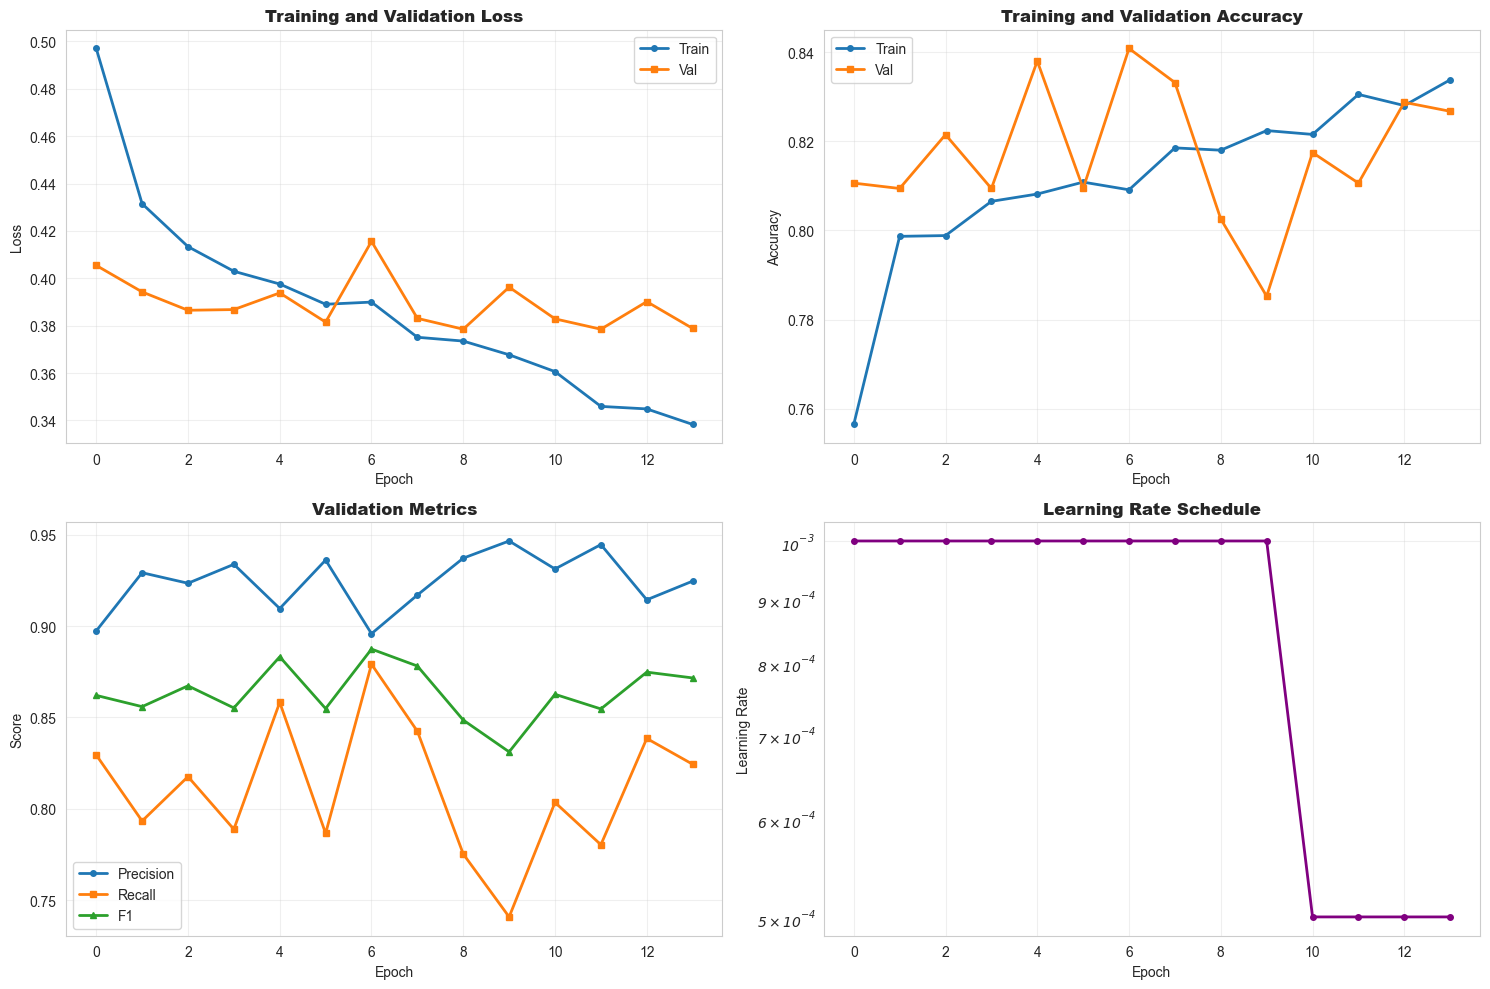

In [191]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss
axes[0, 0].plot(history['train_loss'], label='Train', linewidth=2, marker='o', markersize=4)
axes[0, 0].plot(history['val_loss'], label='Val', linewidth=2, marker='s', markersize=4)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Validation Loss', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy
axes[0, 1].plot(history['train_acc'], label='Train', linewidth=2, marker='o', markersize=4)
axes[0, 1].plot(history['val_acc'], label='Val', linewidth=2, marker='s', markersize=4)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_title('Training and Validation Accuracy', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Validation metrics
axes[1, 0].plot(history['val_precision'], label='Precision', linewidth=2, marker='o', markersize=4)
axes[1, 0].plot(history['val_recall'], label='Recall', linewidth=2, marker='s', markersize=4)
axes[1, 0].plot(history['val_f1'], label='F1', linewidth=2, marker='^', markersize=4)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_title('Validation Metrics', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Learning rate
axes[1, 1].plot(history['learning_rates'], linewidth=2, marker='o', markersize=4, color='purple')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Learning Rate')
axes[1, 1].set_title('Learning Rate Schedule', fontweight='bold')
axes[1, 1].set_yscale('log')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('04_mlp_glove_training_history.png', dpi=150, bbox_inches='tight')
print("Saved: 04_mlp_glove_training_history.png")
plt.show()

## 10. Evaluate on All Splits

In [192]:
model.load_state_dict(torch.load('mlp_glove_best_model.pth'))

def full_evaluation(model, loader, set_name, y_true):
    _, acc, prec, rec, f1, preds, probs = evaluate(model, loader, criterion, device)
    
    roc_auc = roc_auc_score(y_true, probs) if len(np.unique(y_true)) > 1 else None
    
    print(f"{set_name} SET RESULTS")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    if roc_auc:
        print(f"ROC AUC:   {roc_auc:.4f}")
    
    print(f"\n{set_name} Classification Report:")
    print(classification_report(y_true, preds,
                                target_names=['Negative', 'Positive'], digits=4))
    
    # Confusion matrix
    cm = confusion_matrix(y_true, preds)
    fig, ax = plt.subplots(figsize=(8, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
                xticklabels=["Negative", "Positive"],
                yticklabels=["Negative", "Positive"],
                ax=ax, annot_kws={'size': 14, 'weight': 'bold'})
    ax.set_xlabel("Predicted", fontweight='bold')
    ax.set_ylabel("True", fontweight='bold')
    ax.set_title(f"MLP-GloVe Confusion Matrix - {set_name}",
                 fontweight='bold', pad=20)
    ax.text(1, -0.3, f'Accuracy: {acc:.4f} | F1: {f1:.4f}',
            ha='center', fontsize=11, transform=ax.transAxes)
    
    plt.tight_layout()
    filename = f'04_mlp_glove_cm_{set_name.lower()}.png'
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    print(f"Saved: {filename}")
    plt.show()
    
    return {
        'accuracy': float(acc), 'precision': float(prec),
        'recall': float(rec), 'f1': float(f1),
        'roc_auc': float(roc_auc) if roc_auc else None
    }

TRAIN SET RESULTS
Accuracy:  0.8507
Precision: 0.9048
Recall:    0.8837
F1-Score:  0.8942
ROC AUC:   0.4978

TRAIN Classification Report:
              precision    recall  f1-score   support

    Negative     0.2852    0.3018    0.2933      3320
    Positive     0.7128    0.6962    0.7044      8264

    accuracy                         0.5831     11584
   macro avg     0.4990    0.4990    0.4988     11584
weighted avg     0.5903    0.5831    0.5866     11584

Saved: 04_mlp_glove_cm_train.png


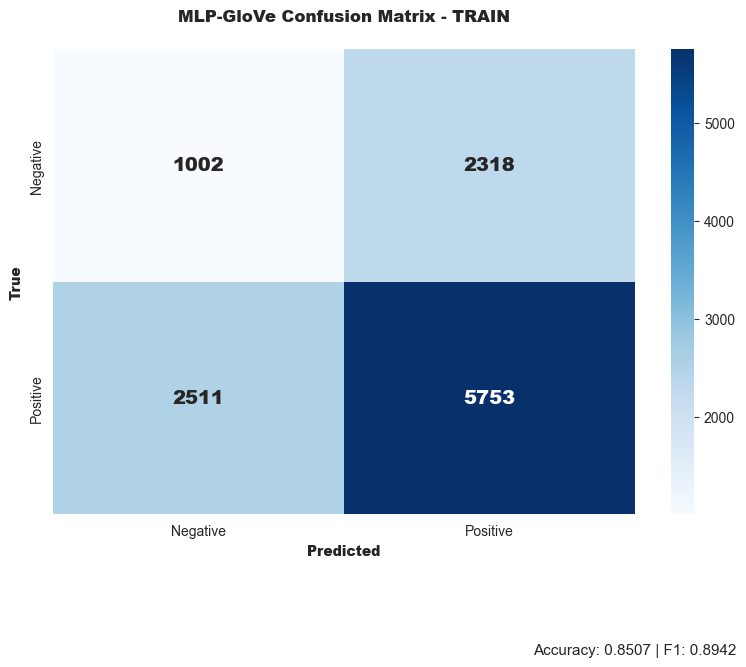

In [193]:
train_results = full_evaluation(model, train_loader, "TRAIN", y_train)

VALIDATION SET RESULTS
Accuracy:  0.8409
Precision: 0.8959
Recall:    0.8792
F1-Score:  0.8874
ROC AUC:   0.9095

VALIDATION Classification Report:
              precision    recall  f1-score   support

    Negative     0.7124    0.7454    0.7285       711
    Positive     0.8959    0.8792    0.8874      1771

    accuracy                         0.8409      2482
   macro avg     0.8041    0.8123    0.8080      2482
weighted avg     0.8433    0.8409    0.8419      2482

Saved: 04_mlp_glove_cm_validation.png


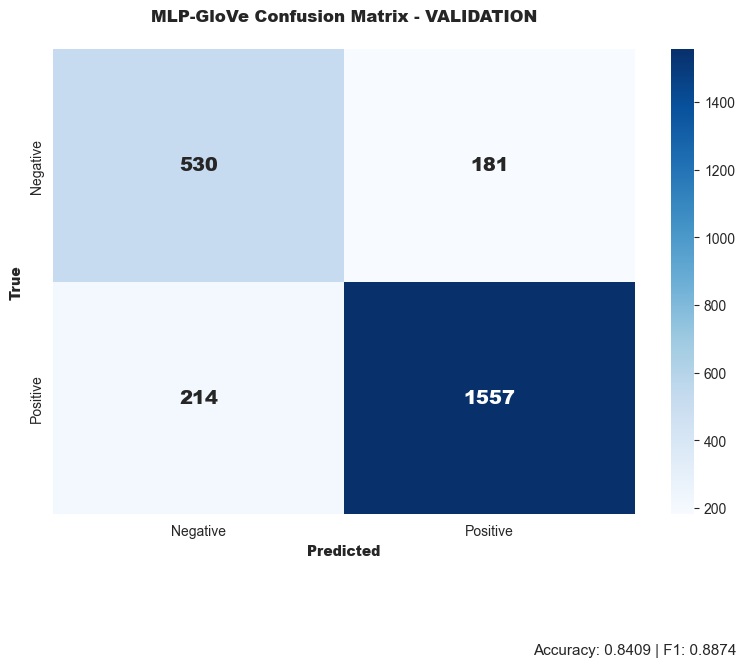

In [194]:
val_results = full_evaluation(model, val_loader, "VALIDATION", y_val)

TEST SET RESULTS
Accuracy:  0.8385
Precision: 0.9044
Recall:    0.8650
F1-Score:  0.8843
ROC AUC:   0.9103

TEST Classification Report:
              precision    recall  f1-score   support

    Negative     0.6971    0.7725    0.7328       712
    Positive     0.9044    0.8650    0.8843      1771

    accuracy                         0.8385      2483
   macro avg     0.8007    0.8188    0.8086      2483
weighted avg     0.8449    0.8385    0.8408      2483

Saved: 04_mlp_glove_cm_test.png


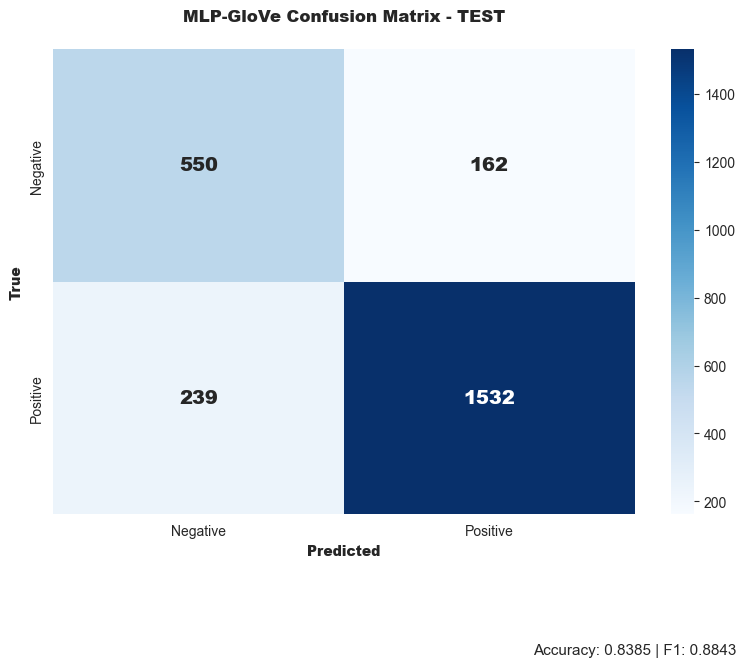

In [195]:
test_results = full_evaluation(model, test_loader, "TEST", y_test)

## 11. Compare with Baseline and MLP with TF-IDF Vectorization

In [196]:
# Load previous results
results_comparison = []

In [197]:
with open('baseline_results.json', 'r') as f:
    baseline = json.load(f)
results_comparison.append({
    'Model': 'Baseline (TF-IDF + LogReg)',
    'Accuracy': baseline['test']['accuracy'],
    'Precision': baseline['test']['precision'],
    'Recall': baseline['test']['recall'],
    'F1': baseline['test']['f1']
})

In [198]:
with open('mlp_results.json', 'r') as f:
    mlp_tfidf = json.load(f)
results_comparison.append({
    'Model': 'MLP (TF-IDF)',
    'Accuracy': mlp_tfidf['test']['accuracy'],
    'Precision': mlp_tfidf['test']['precision'],
    'Recall': mlp_tfidf['test']['recall'],
    'F1': mlp_tfidf['test']['f1']
})

In [199]:
results_comparison.append({
    'Model': 'MLP (GloVe)',
    'Accuracy': test_results['accuracy'],
    'Precision': test_results['precision'],
    'Recall': test_results['recall'],
    'F1': test_results['f1']
})

comparison_df = pd.DataFrame(results_comparison)

In [200]:
print("\nModel Comparison - Test Set:")
print(comparison_df.to_string(index=False))


Model Comparison - Test Set:
                     Model  Accuracy  Precision   Recall       F1
Baseline (TF-IDF + LogReg)  0.863472   0.951450 0.852061 0.899017
              MLP (TF-IDF)  0.851389   0.928484 0.857708 0.891694
               MLP (GloVe)  0.838502   0.904368 0.865048 0.884271



Saved: 04_all_models_comparison.png


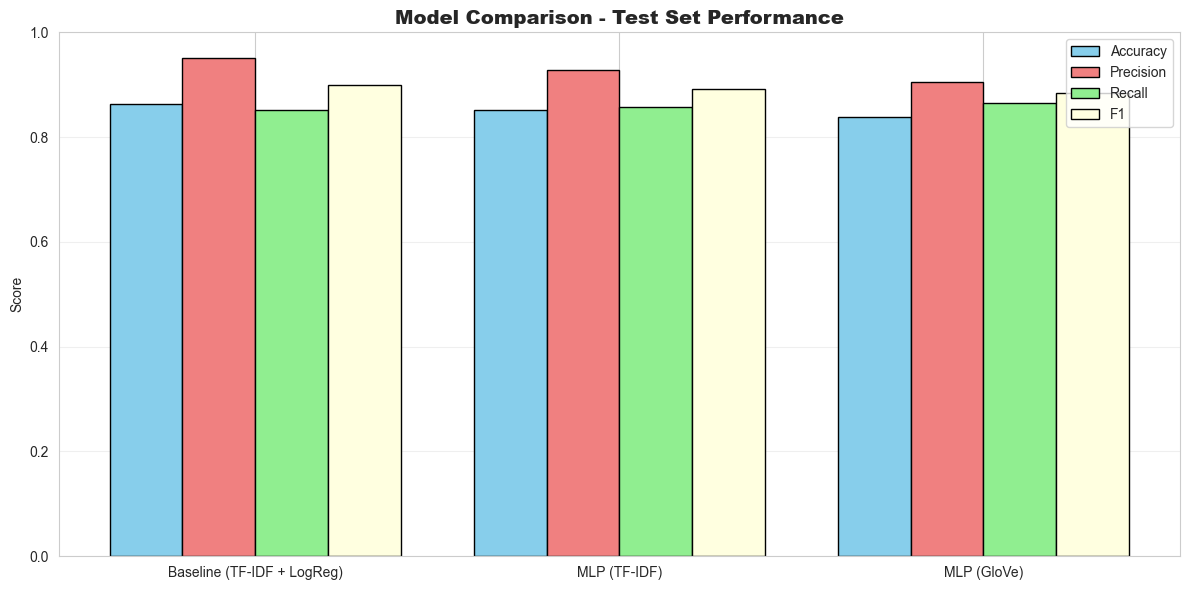

In [201]:
# Visualize comparison
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(comparison_df))
width = 0.2
metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
colors = ['skyblue', 'lightcoral', 'lightgreen', 'lightyellow']

for i, metric in enumerate(metrics):
    values = comparison_df[metric].values
    ax.bar(x + i*width, values, width, label=metric, color=colors[i], edgecolor='black')

ax.set_ylabel('Score')
ax.set_title('Model Comparison - Test Set Performance', fontweight='bold', fontsize=14)
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(comparison_df['Model'])
ax.legend()
ax.set_ylim([0, 1])
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('04_all_models_comparison.png', dpi=150, bbox_inches='tight')
print("\nSaved: 04_all_models_comparison.png")
plt.show()

In [202]:
# Detailed comparison with baseline
if len(results_comparison) >= 2:
    baseline_metrics = results_comparison[0]
    
    # Compare each model with baseline
    for i in range(1, len(results_comparison)):
        model_name = results_comparison[i]['Model']
        print(f"\n{model_name} vs Baseline:")
        
        for metric in ['Accuracy', 'Precision', 'Recall', 'F1']:
            baseline_val = baseline_metrics[metric]
            model_val = results_comparison[i][metric]
            diff = model_val - baseline_val
            pct_diff = diff * 100
            
            status = "BETTER" if diff > 0 else ("WORSE" if diff < 0 else "SAME")
            sign = "+" if diff >= 0 else ""
            
            print(f"  {metric:10s}: {model_val:.4f} vs {baseline_val:.4f} "
                  f"({sign}{diff:.4f}, {sign}{pct_diff:.2f}%) - {status}")


MLP (TF-IDF) vs Baseline:
  Accuracy  : 0.8514 vs 0.8635 (-0.0121, -1.21%) - WORSE
  Precision : 0.9285 vs 0.9515 (-0.0230, -2.30%) - WORSE
  Recall    : 0.8577 vs 0.8521 (+0.0056, +0.56%) - BETTER
  F1        : 0.8917 vs 0.8990 (-0.0073, -0.73%) - WORSE

MLP (GloVe) vs Baseline:
  Accuracy  : 0.8385 vs 0.8635 (-0.0250, -2.50%) - WORSE
  Precision : 0.9044 vs 0.9515 (-0.0471, -4.71%) - WORSE
  Recall    : 0.8650 vs 0.8521 (+0.0130, +1.30%) - BETTER
  F1        : 0.8843 vs 0.8990 (-0.0147, -1.47%) - WORSE


In [204]:
# Create ranked dataframe
comparison_ranked = comparison_df.sort_values('F1', ascending=False).reset_index(drop=True)
comparison_ranked.index = comparison_ranked.index + 1

print("1. Model Performance Ranking (by F1-Score):")
for i, row in comparison_ranked.iterrows():
    print(f"   {i}. {row['Model']:30s} F1 = {row['F1']:.4f}")

1. Model Performance Ranking (by F1-Score):
   1. Baseline (TF-IDF + LogReg)     F1 = 0.8990
   2. MLP (TF-IDF)                   F1 = 0.8917
   3. MLP (GloVe)                    F1 = 0.8843


In [205]:
print("2. Analysis:")
best_model = comparison_ranked.iloc[0]['Model']
best_f1 = comparison_ranked.iloc[0]['F1']
worst_model = comparison_ranked.iloc[-1]['Model']
worst_f1 = comparison_ranked.iloc[-1]['F1']
f1_range = best_f1 - worst_f1

print(f"   - Best model: {best_model} (F1 = {best_f1:.4f})")
print(f"   - Worst model: {worst_model} (F1 = {worst_f1:.4f})")
print(f"   - Performance range: {f1_range:.4f} ({f1_range*100:.2f}%)")

2. Analysis:
   - Best model: Baseline (TF-IDF + LogReg) (F1 = 0.8990)
   - Worst model: MLP (GloVe) (F1 = 0.8843)
   - Performance range: 0.0147 (1.47%)


## 12. Save Results

In [206]:
# Save training history
with open('mlp_glove_history.json', 'w') as f:
    json.dump(history, f, indent=2)
print("Saved: mlp_glove_history.json")

# Save results
glove_results = {
    'model_name': 'MLP with GloVe Embeddings',
    'architecture': {
        'embedding_type': 'GloVe 6B 100d',
        'input_dim': embedding_dim,
        'hidden_dims': hidden_dims,
        'dropout': dropout_rate,
        'total_parameters': total_params
    },
    'embeddings': {
        'glove_vocab_size': len(embeddings_index),
        'coverage': float(train_coverage),
        'zero_vectors': int(zero_vectors_train)
    },
    'training': {
        'epochs': len(history['train_loss']),
        'best_val_f1': float(best_val_f1)
    },
    'train': train_results,
    'validation': val_results,
    'test': test_results
}

with open('mlp_glove_results.json', 'w') as f:
    json.dump(glove_results, f, indent=2)
print("Saved: mlp_glove_results.json")

Saved: mlp_glove_history.json
Saved: mlp_glove_results.json


## 13. Summary

In [207]:
hidden_str = ' -> '.join(map(str, hidden_dims))
roc_str = f"{test_results['roc_auc']:.4f}" if test_results['roc_auc'] else 'N/A'

print(f"""
Model: MLP with GloVe Embeddings

Embeddings:
  Type: GloVe 6B (100-dimensional)
  Vocabulary: {len(embeddings_index):,} words
  Coverage: {train_coverage*100:.1f}% of training words

Architecture:
  Input: {embedding_dim} dimensions
  Hidden: {hidden_str}
  Parameters: {total_params:,}

Training:
  Epochs: {len(history['train_loss'])}
  Best Val F1: {best_val_f1:.4f}

Test Performance:
  Accuracy:  {test_results['accuracy']:.4f}
  Precision: {test_results['precision']:.4f}
  Recall:    {test_results['recall']:.4f}
  F1-Score:  {test_results['f1']:.4f}
  ROC AUC:   {roc_str}

Files Created:
  - mlp_glove_best_model.pth
  - mlp_glove_results.json
  - mlp_glove_history.json
  - glove_embeddings_index.pkl
  - 04_mlp_glove_training_history.png
  - 04_mlp_glove_cm_*.png
  - 04_all_models_comparison.png
""")


Model: MLP with GloVe Embeddings

Embeddings:
  Type: GloVe 6B (100-dimensional)
  Vocabulary: 400,000 words
  Coverage: 98.5% of training words

Architecture:
  Input: 100 dimensions
  Hidden: 128 -> 64
  Parameters: 21,698

Training:
  Epochs: 14
  Best Val F1: 0.8874

Test Performance:
  Accuracy:  0.8385
  Precision: 0.9044
  Recall:    0.8650
  F1-Score:  0.8843
  ROC AUC:   0.9103

Files Created:
  - mlp_glove_best_model.pth
  - mlp_glove_results.json
  - mlp_glove_history.json
  - glove_embeddings_index.pkl
  - 04_mlp_glove_training_history.png
  - 04_mlp_glove_cm_*.png
  - 04_all_models_comparison.png



# Same Models but with HPO using Optuna

## Load Preprocessed Data

In [208]:
train_df = pd.read_csv('train.csv')
val_df = pd.read_csv('val.csv')
test_df = pd.read_csv('test.csv')

X_train = train_df['clean_comments']
y_train = train_df['sentiment']
X_val = val_df['clean_comments']
y_val = val_df['sentiment']
X_test = test_df['clean_comments']
y_test = test_df['sentiment']

## Model 1A: Optuna for TF-IDF + Logistic Regression (Baseline)

In [209]:
def objective_baseline(trial):
    # TF-IDF hyperparameters
    max_features = trial.suggest_int('max_features', 3000, 10000, step=1000)
    ngram_max = trial.suggest_int('ngram_max', 1, 3)
    min_df = trial.suggest_int('min_df', 2, 5)
    max_df = trial.suggest_float('max_df', 0.85, 0.95, step=0.05)
    
    # Logistic Regression hyperparameters
    C = trial.suggest_float('C', 0.1, 10.0, log=True)
    max_iter = trial.suggest_categorical('max_iter', [500, 1000, 2000])
    
    # Create pipeline
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(
            max_features=max_features,
            ngram_range=(1, ngram_max),
            min_df=min_df,
            max_df=max_df,
            sublinear_tf=True,
            stop_words='english'
        )),
        ('lr', LogisticRegression(
            C=C,
            max_iter=max_iter,
            class_weight='balanced',
            solver='saga',
            random_state=42,
            n_jobs=-1
        ))
    ])
    
    # Train on training set
    pipeline.fit(X_train, y_train)
    
    # Evaluate on validation set
    y_pred = pipeline.predict(X_val)
    f1 = f1_score(y_val, y_pred)
    
    return f1

In [210]:
# Create and run study
study_baseline = optuna.create_study(
    direction='maximize',
    study_name='baseline_optuna',
    sampler=optuna.samplers.TPESampler(seed=42)
)

study_baseline.optimize(
    objective_baseline,
    n_trials=50,
    show_progress_bar=True
)

[I 2025-11-19 02:02:16,051] A new study created in memory with name: baseline_optuna


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-11-19 02:02:17,269] Trial 0 finished with value: 0.8910772903610863 and parameters: {'max_features': 5000, 'ngram_max': 3, 'min_df': 4, 'max_df': 0.9, 'C': 0.20513382630874505, 'max_iter': 2000}. Best is trial 0 with value: 0.8910772903610863.
[I 2025-11-19 02:02:18,445] Trial 1 finished with value: 0.9104172745841844 and parameters: {'max_features': 7000, 'ngram_max': 3, 'min_df': 2, 'max_df': 0.95, 'C': 4.622589001020832, 'max_iter': 500}. Best is trial 1 with value: 0.9104172745841844.
[I 2025-11-19 02:02:19,223] Trial 2 finished with value: 0.9062591830737584 and parameters: {'max_features': 5000, 'ngram_max': 2, 'min_df': 3, 'max_df': 0.85, 'C': 1.6738085788752133, 'max_iter': 2000}. Best is trial 1 with value: 0.9104172745841844.
[I 2025-11-19 02:02:20,491] Trial 3 finished with value: 0.9058823529411765 and parameters: {'max_features': 6000, 'ngram_max': 3, 'min_df': 2, 'max_df': 0.9, 'C': 1.5304852121831465, 'max_iter': 1000}. Best is trial 1 with value: 0.9104172745841

In [211]:
# Print results
print(f"Best Trial: #{study_baseline.best_trial.number}")
print(f"Best Validation F1: {study_baseline.best_trial.value:.4f}")
print(f"Best Hyperparameters:")
for key, value in study_baseline.best_params.items():
    print(f"  {key:15s}: {value}")

Best Trial: #11
Best Validation F1: 0.9135
Best Hyperparameters:
  max_features   : 10000
  ngram_max      : 3
  min_df         : 3
  max_df         : 0.9
  C              : 9.80777812086547
  max_iter       : 500


In [212]:
# Train final model with best parameters
baseline_optuna = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=study_baseline.best_params['max_features'],
        ngram_range=(1, study_baseline.best_params['ngram_max']),
        min_df=study_baseline.best_params['min_df'],
        max_df=study_baseline.best_params['max_df'],
        sublinear_tf=True,
        stop_words='english'
    )),
    ('lr', LogisticRegression(
        C=study_baseline.best_params['C'],
        max_iter=study_baseline.best_params['max_iter'],
        class_weight='balanced',
        solver='saga',
        random_state=42,
        n_jobs=-1
    ))
])

baseline_optuna.fit(X_train, y_train)

,steps,"[('tfidf', ...), ('lr', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [213]:
# Evaluate on all splits
def evaluate_model(model, X, y, set_name):
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]
    
    acc = accuracy_score(y, y_pred)
    prec = precision_score(y, y_pred, zero_division=0)
    rec = recall_score(y, y_pred, zero_division=0)
    f1 = f1_score(y, y_pred, zero_division=0)
    auc = roc_auc_score(y, y_prob) if len(np.unique(y)) > 1 else None
    
    print(f"{set_name} Set:")
    print(f"  Accuracy:  {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall:    {rec:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    if auc:
        print(f"  ROC AUC:   {auc:.4f}")
    
    return {
        'accuracy': float(acc),
        'precision': float(prec),
        'recall': float(rec),
        'f1': float(f1),
        'roc_auc': float(auc) if auc else None
    }

In [214]:
baseline_optuna_train = evaluate_model(baseline_optuna, X_train, y_train, "Train")

Train Set:
  Accuracy:  0.9535
  Precision: 0.9964
  Recall:    0.9382
  F1-Score:  0.9664
  ROC AUC:   0.9950


In [215]:
baseline_optuna_val = evaluate_model(baseline_optuna, X_val, y_val, "Validation")

Validation Set:
  Accuracy:  0.8795
  Precision: 0.9365
  Recall:    0.8916
  F1-Score:  0.9135
  ROC AUC:   0.9449


In [216]:
baseline_optuna_test = evaluate_model(baseline_optuna, X_test, y_test, "Test")

Test Set:
  Accuracy:  0.8711
  Precision: 0.9400
  Recall:    0.8752
  F1-Score:  0.9064
  ROC AUC:   0.9427


In [217]:
# Save results
baseline_optuna_results = {
    'model': 'Baseline (TF-IDF + LogReg) - Optuna Optimized',
    'best_params': study_baseline.best_params,
    'train': baseline_optuna_train,
    'validation': baseline_optuna_val,
    'test': baseline_optuna_test
}

with open('baseline_optuna_results.json', 'w') as f:
    json.dump(baseline_optuna_results, f, indent=2)

In [218]:
# Save model
joblib.dump(baseline_optuna, 'baseline_optuna_model.pkl')

['baseline_optuna_model.pkl']

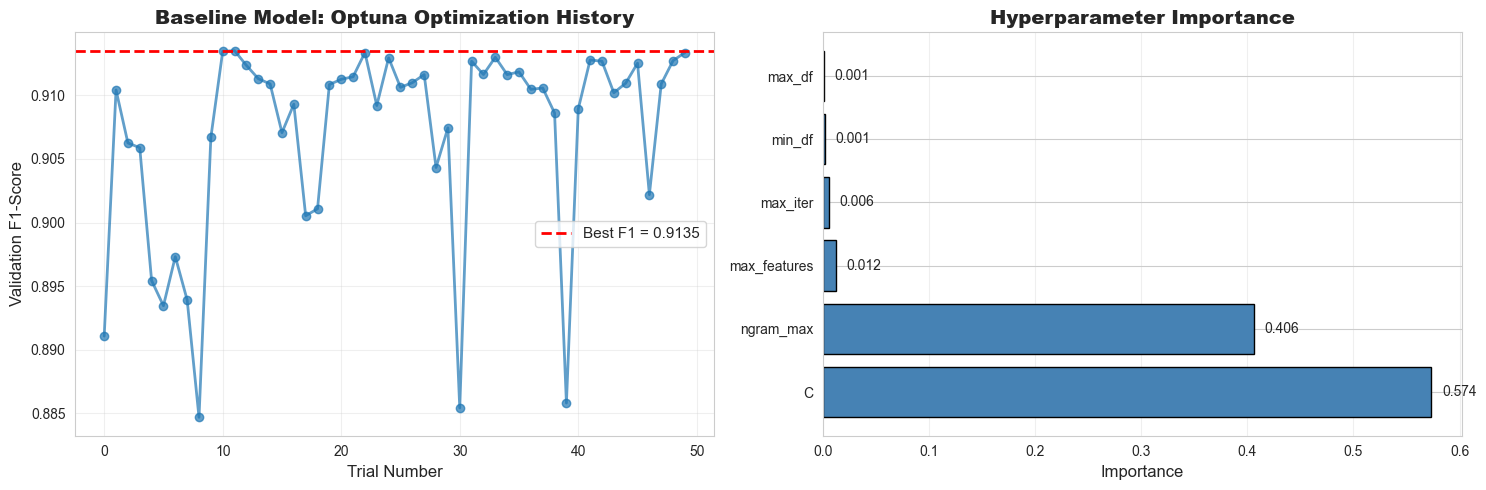

In [219]:
# Visualize optimization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Optimization history
trials_df = study_baseline.trials_dataframe()
axes[0].plot(trials_df['number'], trials_df['value'], marker='o', linewidth=2, alpha=0.7)
axes[0].axhline(y=study_baseline.best_trial.value, color='r', linestyle='--',
                linewidth=2, label=f'Best F1 = {study_baseline.best_trial.value:.4f}')
axes[0].set_xlabel('Trial Number', fontsize=12)
axes[0].set_ylabel('Validation F1-Score', fontsize=12)
axes[0].set_title('Baseline Model: Optuna Optimization History', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Parameter importance
param_importance = optuna.importance.get_param_importances(study_baseline)
params = list(param_importance.keys())
importances = list(param_importance.values())

axes[1].barh(params, importances, color='steelblue', edgecolor='black')
axes[1].set_xlabel('Importance', fontsize=12)
axes[1].set_title('Hyperparameter Importance', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (param, imp) in enumerate(zip(params, importances)):
    axes[1].text(imp + 0.01, i, f'{imp:.3f}', va='center', fontsize=10)

plt.tight_layout()
plt.savefig('07a_baseline_optuna.png', dpi=150, bbox_inches='tight')
plt.show()

## Model 2A: Optuna for MLP Model (TF-IDF Vectorized Embeddings)

In [220]:
# Same classifier in previous cells
class MLPClassifier(nn.Module):    
    def __init__(self, input_dim, hidden_dims=[512, 256, 128], num_classes=2, dropout=0.4):
        super(MLPClassifier, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev_dim = hidden_dim
        
        layers.append(nn.Linear(prev_dim, num_classes))
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

In [221]:
# Dataset class
class ReviewDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.FloatTensor(features)
        self.labels = torch.LongTensor(labels)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [222]:
def objective_mlp_tfidf(trial):
    # TF-IDF parameters
    max_features = trial.suggest_int('max_features', 2000, 5000, step=500)
    
    # MLP architecture parameters
    hidden_1 = trial.suggest_categorical('hidden_1', [256, 512, 768, 1024])
    hidden_2 = trial.suggest_categorical('hidden_2', [128, 256, 384, 512])
    hidden_3 = trial.suggest_categorical('hidden_3', [64, 128, 192, 256])
    dropout = trial.suggest_float('dropout', 0.2, 0.5, step=0.1)
    
    # Training parameters
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    
    # Create TF-IDF features
    vectorizer = TfidfVectorizer(
        max_features=max_features,
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.95,
        sublinear_tf=True
    )
    
    X_train_vec = vectorizer.fit_transform(X_train).toarray()
    X_val_vec = vectorizer.transform(X_val).toarray()
    
    # Create datasets and dataloaders
    train_dataset = ReviewDataset(X_train_vec, y_train)
    val_dataset = ReviewDataset(X_val_vec, y_val)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Create model
    model = MLPClassifier(
        input_dim=max_features,
        hidden_dims=[hidden_1, hidden_2, hidden_3],
        dropout=dropout
    ).to(device)
    
    # Loss and optimizer
    class_counts = np.bincount(y_train)
    class_weights = torch.FloatTensor([1.0 / c for c in class_counts]).to(device)
    class_weights = class_weights * len(class_weights) / class_weights.sum()
    
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    
    # Train for limited epochs (for speed)
    num_epochs = 10
    best_val_f1 = 0
    patience = 3
    patience_counter = 0
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        # Validation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for features, labels in val_loader:
                features, labels = features.to(device), labels.to(device)
                outputs = model(features)
                _, preds = outputs.max(1)
                all_preds.extend(preds.cpu().tolist())
                all_labels.extend(labels.cpu().tolist())
        
        val_f1 = f1_score(all_labels, all_preds)
        
        # Early stopping
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break
    
    return best_val_f1

In [223]:
# Run optimization
study_mlp_tfidf = optuna.create_study(
    direction='maximize',
    study_name='mlp_tfidf_optuna',
    sampler=optuna.samplers.TPESampler(seed=42)
)

study_mlp_tfidf.optimize(
    objective_mlp_tfidf,
    n_trials=30,
    show_progress_bar=True,
    n_jobs=1  # Don't parallelize to avoid GPU conflicts
)

[I 2025-11-19 02:08:19,205] A new study created in memory with name: mlp_tfidf_optuna


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-11-19 02:08:30,645] Trial 0 finished with value: 0.9033942558746736 and parameters: {'max_features': 3000, 'hidden_1': 256, 'hidden_2': 384, 'hidden_3': 192, 'dropout': 0.2, 'lr': 0.0002310201887845295, 'batch_size': 128}. Best is trial 0 with value: 0.9033942558746736.
[I 2025-11-19 02:08:45,545] Trial 1 finished with value: 0.9078756175530369 and parameters: {'max_features': 3500, 'hidden_1': 512, 'hidden_2': 384, 'hidden_3': 256, 'dropout': 0.2, 'lr': 0.00013492834268013249, 'batch_size': 64}. Best is trial 1 with value: 0.9078756175530369.
[I 2025-11-19 02:09:03,191] Trial 2 finished with value: 0.9043778801843319 and parameters: {'max_features': 3000, 'hidden_1': 512, 'hidden_2': 384, 'hidden_3': 64, 'dropout': 0.2, 'lr': 0.00869299151113955, 'batch_size': 64}. Best is trial 1 with value: 0.9078756175530369.
[I 2025-11-19 02:09:32,487] Trial 3 finished with value: 0.90002948982601 and parameters: {'max_features': 4000, 'hidden_1': 256, 'hidden_2': 512, 'hidden_3': 192, 'dr

In [224]:
# Print results
print(f"Best Trial: #{study_mlp_tfidf.best_trial.number}")
print(f"Best Validation F1: {study_mlp_tfidf.best_trial.value:.4f}")
print(f"Best Hyperparameters:")
for key, value in study_mlp_tfidf.best_params.items():
    print(f"  {key:15s}: {value}")

Best Trial: #18
Best Validation F1: 0.9080
Best Hyperparameters:
  max_features   : 3000
  hidden_1       : 768
  hidden_2       : 256
  hidden_3       : 64
  dropout        : 0.4
  lr             : 0.0004535633806196736
  batch_size     : 128


In [225]:

# Train final model with best parameters (full training)
# Create TF-IDF features with best params
vectorizer_mlp = TfidfVectorizer(
    max_features=study_mlp_tfidf.best_params['max_features'],
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95,
    sublinear_tf=True
)

X_train_vec = vectorizer_mlp.fit_transform(X_train).toarray()
X_val_vec = vectorizer_mlp.transform(X_val).toarray()
X_test_vec = vectorizer_mlp.transform(X_test).toarray()

# Create datasets
train_dataset = ReviewDataset(X_train_vec, y_train)
val_dataset = ReviewDataset(X_val_vec, y_val)
test_dataset = ReviewDataset(X_test_vec, y_test)

batch_size = study_mlp_tfidf.best_params['batch_size']
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [226]:
# Create model with best architecture
mlp_tfidf_optuna = MLPClassifier(
    input_dim=study_mlp_tfidf.best_params['max_features'],
    hidden_dims=[
        study_mlp_tfidf.best_params['hidden_1'],
        study_mlp_tfidf.best_params['hidden_2'],
        study_mlp_tfidf.best_params['hidden_3']
    ],
    dropout=study_mlp_tfidf.best_params['dropout']
).to(device)

In [227]:
# Loss and optimizer
class_counts = np.bincount(y_train)
class_weights = torch.FloatTensor([1.0 / c for c in class_counts]).to(device)
class_weights = class_weights * len(class_weights) / class_weights.sum()

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(
    mlp_tfidf_optuna.parameters(),
    lr=study_mlp_tfidf.best_params['lr'],
    weight_decay=1e-5
)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

In [228]:
# Training loop
num_epochs = 30
best_val_f1 = 0
patience = 7
patience_counter = 0

history = {'train_loss': [], 'val_f1': []}

for epoch in range(num_epochs):
    # Training
    mlp_tfidf_optuna.train()
    train_loss = 0
    
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = mlp_tfidf_optuna(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    
    # Validation
    mlp_tfidf_optuna.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for features, labels in val_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = mlp_tfidf_optuna(features)
            _, preds = outputs.max(1)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())
    
    val_f1 = f1_score(all_labels, all_preds)
    
    history['train_loss'].append(train_loss)
    history['val_f1'].append(val_f1)
    
    scheduler.step(val_f1)
    
    print(f"Epoch {epoch+1:2d}/{num_epochs} | Loss: {train_loss:.4f} | Val F1: {val_f1:.4f}")
    
    # Save best model
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(mlp_tfidf_optuna.state_dict(), 'mlp_tfidf_optuna_best.pth')
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break

Epoch  1/30 | Loss: 0.4673 | Val F1: 0.8814
Epoch  2/30 | Loss: 0.2464 | Val F1: 0.8965
Epoch  3/30 | Loss: 0.1639 | Val F1: 0.9039
Epoch  4/30 | Loss: 0.1145 | Val F1: 0.8993
Epoch  5/30 | Loss: 0.0882 | Val F1: 0.9067
Epoch  6/30 | Loss: 0.0813 | Val F1: 0.9016
Epoch  7/30 | Loss: 0.0726 | Val F1: 0.9022
Epoch  8/30 | Loss: 0.0669 | Val F1: 0.9001
Epoch  9/30 | Loss: 0.0715 | Val F1: 0.8990
Epoch 10/30 | Loss: 0.0668 | Val F1: 0.9001
Epoch 11/30 | Loss: 0.0562 | Val F1: 0.9028
Epoch 12/30 | Loss: 0.0553 | Val F1: 0.9008

Early stopping at epoch 12


In [229]:
# Load best model
mlp_tfidf_optuna.load_state_dict(torch.load('mlp_tfidf_optuna_best.pth'))
print(f"Best validation F1: {best_val_f1:.4f}")

Best validation F1: 0.9067


In [234]:
# Evaluate on test set
def evaluate_mlp(model, loader):
    model.eval()
    all_preds = []
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        for features, labels in loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            probs = torch.softmax(outputs, dim=1)
            _, preds = outputs.max(1)
            
            all_preds.extend(preds.cpu().tolist())
            all_probs.extend(probs[:, 1].cpu().tolist())
            all_labels.extend(labels.cpu().tolist())
    
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)
    
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, zero_division=0)
    rec = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    auc = roc_auc_score(all_labels, all_probs)
    
    return {
        'accuracy': float(acc),
        'precision': float(prec),
        'recall': float(rec),
        'f1': float(f1),
        'roc_auc': float(auc)
    }

mlp_tfidf_optuna_train = evaluate_mlp(mlp_tfidf_optuna, train_loader)
mlp_tfidf_optuna_val = evaluate_mlp(mlp_tfidf_optuna, val_loader)
mlp_tfidf_optuna_test = evaluate_mlp(mlp_tfidf_optuna, test_loader)

In [235]:
print(f"Train Set:")
print(f"  Accuracy: {mlp_tfidf_optuna_train['accuracy']:.4f}")
print(f"  F1-Score: {mlp_tfidf_optuna_train['f1']:.4f}")

Train Set:
  Accuracy: 0.9647
  F1-Score: 0.9747


In [236]:
print(f"Validation Set:")
print(f"  Accuracy: {mlp_tfidf_optuna_val['accuracy']:.4f}")
print(f"  F1-Score: {mlp_tfidf_optuna_val['f1']:.4f}")

Validation Set:
  Accuracy: 0.8699
  F1-Score: 0.9067


In [237]:
print(f"Test Set:")
print(f"  Accuracy: {mlp_tfidf_optuna_test['accuracy']:.4f}")
print(f"  F1-Score: {mlp_tfidf_optuna_test['f1']:.4f}")
print(f"  ROC AUC:  {mlp_tfidf_optuna_test['roc_auc']:.4f}")

Test Set:
  Accuracy: 0.8586
  F1-Score: 0.8966
  ROC AUC:  0.9304


In [238]:
# Save results
mlp_tfidf_optuna_results = {
    'model': 'MLP (TF-IDF) - Optuna Optimized',
    'best_params': study_mlp_tfidf.best_params,
    'train': mlp_tfidf_optuna_train,
    'validation': mlp_tfidf_optuna_val,
    'test': mlp_tfidf_optuna_test
}

with open('mlp_tfidf_optuna_results.json', 'w') as f:
    json.dump(mlp_tfidf_optuna_results, f, indent=2)

In [239]:
# Save model
torch.save({
    'model_state_dict': mlp_tfidf_optuna.state_dict(),
    'best_params': study_mlp_tfidf.best_params,
    'history': history
}, 'mlp_tfidf_optuna_full.pth')

In [240]:
# Save vectorizer
joblib.dump(vectorizer_mlp, 'mlp_tfidf_optuna_vectorizer.pkl')

['mlp_tfidf_optuna_vectorizer.pkl']

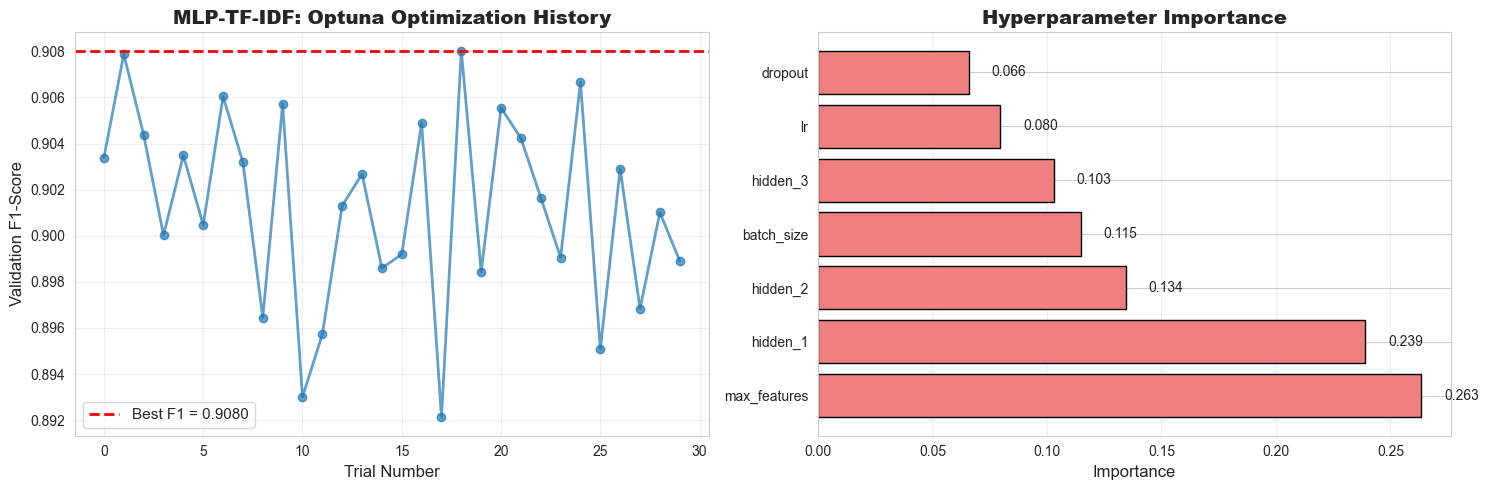

In [241]:
# Visualize optimization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Optimization history
trials_df_mlp = study_mlp_tfidf.trials_dataframe()
axes[0].plot(trials_df_mlp['number'], trials_df_mlp['value'], marker='o', linewidth=2, alpha=0.7)
axes[0].axhline(y=study_mlp_tfidf.best_trial.value, color='r', linestyle='--',
                linewidth=2, label=f'Best F1 = {study_mlp_tfidf.best_trial.value:.4f}')
axes[0].set_xlabel('Trial Number', fontsize=12)
axes[0].set_ylabel('Validation F1-Score', fontsize=12)
axes[0].set_title('MLP-TF-IDF: Optuna Optimization History', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Parameter importance
param_importance_mlp = optuna.importance.get_param_importances(study_mlp_tfidf)
params_mlp = list(param_importance_mlp.keys())
importances_mlp = list(param_importance_mlp.values())

axes[1].barh(params_mlp, importances_mlp, color='lightcoral', edgecolor='black')
axes[1].set_xlabel('Importance', fontsize=12)
axes[1].set_title('Hyperparameter Importance', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (param, imp) in enumerate(zip(params_mlp, importances_mlp)):
    axes[1].text(imp + 0.01, i, f'{imp:.3f}', va='center', fontsize=10)

plt.tight_layout()
plt.savefig('07b_mlp_tfidf_optuna.png', dpi=150, bbox_inches='tight')
plt.show()

## Model 3A: Optuna for MLP Model (GloVe Embeddings)

In [242]:
# Load GloVe embeddings
with open('glove_embeddings_index.pkl', 'rb') as f:
    embeddings_index = pickle.load(f)
print(f"Loaded {len(embeddings_index):,} word vectors")

Loaded 400,000 word vectors


In [243]:
# Function to convert text to embedding
def text_to_embedding(text, embedding_index, embedding_dim=100):
    words = text.split()
    vectors = []
    
    for word in words:
        if word in embedding_index:
            vectors.append(embedding_index[word])
    
    if len(vectors) == 0:
        return np.zeros(embedding_dim)
    
    return np.mean(vectors, axis=0)

In [244]:
def objective_mlp_glove(trial):
    # MLP architecture parameters
    # Smaller networks for 100-dim input
    hidden_1 = trial.suggest_categorical('hidden_1', [64, 128, 192, 256])
    hidden_2 = trial.suggest_categorical('hidden_2', [32, 64, 96, 128])
    dropout = trial.suggest_float('dropout', 0.2, 0.4, step=0.1)
    
    # Training parameters
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    
    # Create GloVe embeddings
    embedding_dim = 100
    X_train_emb = np.array([text_to_embedding(text, embeddings_index, embedding_dim)
                            for text in X_train])
    X_val_emb = np.array([text_to_embedding(text, embeddings_index, embedding_dim)
                          for text in X_val])
    
    # Create datasets and dataloaders
    train_dataset = ReviewDataset(X_train_emb, y_train)
    val_dataset = ReviewDataset(X_val_emb, y_val)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Create model
    model = MLPClassifier(
        input_dim=embedding_dim,
        hidden_dims=[hidden_1, hidden_2],  # 2 layers for smaller input
        dropout=dropout
    ).to(device)
    
    # Loss and optimizer
    class_counts = np.bincount(y_train)
    class_weights = torch.FloatTensor([1.0 / c for c in class_counts]).to(device)
    class_weights = class_weights * len(class_weights) / class_weights.sum()
    
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    
    # Train for limited epochs
    num_epochs = 10
    best_val_f1 = 0
    patience = 3
    patience_counter = 0
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        # Validation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for features, labels in val_loader:
                features, labels = features.to(device), labels.to(device)
                outputs = model(features)
                _, preds = outputs.max(1)
                all_preds.extend(preds.cpu().tolist())
                all_labels.extend(labels.cpu().tolist())
        
        val_f1 = f1_score(all_labels, all_preds)
        
        # Early stopping
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break
    
    return best_val_f1

In [245]:
# Run optimization
study_mlp_glove = optuna.create_study(
    direction='maximize',
    study_name='mlp_glove_optuna',
    sampler=optuna.samplers.TPESampler(seed=42)
)

study_mlp_glove.optimize(
    objective_mlp_glove,
    n_trials=30,
    show_progress_bar=True,
    n_jobs=1
)

[I 2025-11-19 02:22:40,062] A new study created in memory with name: mlp_glove_optuna


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-11-19 02:22:47,792] Trial 0 finished with value: 0.8782913984786425 and parameters: {'hidden_1': 128, 'hidden_2': 128, 'dropout': 0.30000000000000004, 'lr': 0.0026070247583707684, 'batch_size': 64}. Best is trial 0 with value: 0.8782913984786425.
[I 2025-11-19 02:22:50,425] Trial 1 finished with value: 0.8643364928909952 and parameters: {'hidden_1': 256, 'hidden_2': 128, 'dropout': 0.2, 'lr': 0.0003839629299804173, 'batch_size': 128}. Best is trial 0 with value: 0.8782913984786425.
[I 2025-11-19 02:22:53,276] Trial 2 finished with value: 0.833386025924755 and parameters: {'hidden_1': 192, 'hidden_2': 128, 'dropout': 0.4, 'lr': 0.004138040112561018, 'batch_size': 128}. Best is trial 0 with value: 0.8782913984786425.
[I 2025-11-19 02:22:58,206] Trial 3 finished with value: 0.8691756272401434 and parameters: {'hidden_1': 192, 'hidden_2': 32, 'dropout': 0.30000000000000004, 'lr': 0.0012399967836846098, 'batch_size': 64}. Best is trial 0 with value: 0.8782913984786425.
[I 2025-11-19

In [246]:
# Print results
print(f"Best Trial: #{study_mlp_glove.best_trial.number}")
print(f"Best Validation F1: {study_mlp_glove.best_trial.value:.4f}")
print(f"Best Hyperparameters:")
for key, value in study_mlp_glove.best_params.items():
    print(f"  {key:15s}: {value}")

Best Trial: #18
Best Validation F1: 0.8876
Best Hyperparameters:
  hidden_1       : 256
  hidden_2       : 96
  dropout        : 0.2
  lr             : 0.0027225822428756457
  batch_size     : 64


In [247]:
# Train final model with best parameters
# Create GloVe embeddings
embedding_dim = 100
X_train_emb = np.array([text_to_embedding(text, embeddings_index, embedding_dim)
                        for text in X_train])
X_val_emb = np.array([text_to_embedding(text, embeddings_index, embedding_dim)
                      for text in X_val])
X_test_emb = np.array([text_to_embedding(text, embeddings_index, embedding_dim)
                       for text in X_test])

In [248]:
# Create datasets
train_dataset = ReviewDataset(X_train_emb, y_train)
val_dataset = ReviewDataset(X_val_emb, y_val)
test_dataset = ReviewDataset(X_test_emb, y_test)

batch_size = study_mlp_glove.best_params['batch_size']
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [249]:
# Create model with best architecture
mlp_glove_optuna = MLPClassifier(
    input_dim=embedding_dim,
    hidden_dims=[
        study_mlp_glove.best_params['hidden_1'],
        study_mlp_glove.best_params['hidden_2']
    ],
    dropout=study_mlp_glove.best_params['dropout']
).to(device)

In [250]:
# Loss and optimizer
class_counts = np.bincount(y_train)
class_weights = torch.FloatTensor([1.0 / c for c in class_counts]).to(device)
class_weights = class_weights * len(class_weights) / class_weights.sum()

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(
    mlp_glove_optuna.parameters(),
    lr=study_mlp_glove.best_params['lr'],
    weight_decay=1e-5
)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

In [251]:
# Training loop
num_epochs = 30
best_val_f1 = 0
patience = 7
patience_counter = 0

history_glove = {'train_loss': [], 'val_f1': []}

for epoch in range(num_epochs):
    # Training
    mlp_glove_optuna.train()
    train_loss = 0
    
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = mlp_glove_optuna(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    
    # Validation
    mlp_glove_optuna.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for features, labels in val_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = mlp_glove_optuna(features)
            _, preds = outputs.max(1)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())
    
    val_f1 = f1_score(all_labels, all_preds)
    
    history_glove['train_loss'].append(train_loss)
    history_glove['val_f1'].append(val_f1)
    
    scheduler.step(val_f1)
    
    print(f"Epoch {epoch+1:2d}/{num_epochs} | Loss: {train_loss:.4f} | Val F1: {val_f1:.4f}")
    
    # Save best model
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(mlp_glove_optuna.state_dict(), 'mlp_glove_optuna_best.pth')
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break

Epoch  1/30 | Loss: 0.4553 | Val F1: 0.8131
Epoch  2/30 | Loss: 0.4034 | Val F1: 0.8468
Epoch  3/30 | Loss: 0.3977 | Val F1: 0.8579
Epoch  4/30 | Loss: 0.3845 | Val F1: 0.8319
Epoch  5/30 | Loss: 0.3744 | Val F1: 0.8852
Epoch  6/30 | Loss: 0.3703 | Val F1: 0.8597
Epoch  7/30 | Loss: 0.3605 | Val F1: 0.8666
Epoch  8/30 | Loss: 0.3486 | Val F1: 0.8597
Epoch  9/30 | Loss: 0.3420 | Val F1: 0.8807
Epoch 10/30 | Loss: 0.3142 | Val F1: 0.8888
Epoch 11/30 | Loss: 0.3040 | Val F1: 0.8675
Epoch 12/30 | Loss: 0.3015 | Val F1: 0.8853
Epoch 13/30 | Loss: 0.2868 | Val F1: 0.8699
Epoch 14/30 | Loss: 0.2884 | Val F1: 0.8818
Epoch 15/30 | Loss: 0.2598 | Val F1: 0.8578
Epoch 16/30 | Loss: 0.2512 | Val F1: 0.8745
Epoch 17/30 | Loss: 0.2478 | Val F1: 0.8637

Early stopping at epoch 17


In [252]:
# Load best model
mlp_glove_optuna.load_state_dict(torch.load('mlp_glove_optuna_best.pth'))
print(f"Best validation F1: {best_val_f1:.4f}")

# Evaluate on test set
mlp_glove_optuna_train = evaluate_mlp(mlp_glove_optuna, train_loader)
mlp_glove_optuna_val = evaluate_mlp(mlp_glove_optuna, val_loader)
mlp_glove_optuna_test = evaluate_mlp(mlp_glove_optuna, test_loader)

Best validation F1: 0.8888


In [253]:
print(f"Train Set:")
print(f"  Accuracy: {mlp_glove_optuna_train['accuracy']:.4f}")
print(f"  F1-Score: {mlp_glove_optuna_train['f1']:.4f}")

Train Set:
  Accuracy: 0.8823
  F1-Score: 0.9163


In [254]:
print(f"Validation Set:")
print(f"  Accuracy: {mlp_glove_optuna_val['accuracy']:.4f}")
print(f"  F1-Score: {mlp_glove_optuna_val['f1']:.4f}")

Validation Set:
  Accuracy: 0.8425
  F1-Score: 0.8888


In [255]:
print(f"Test Set:")
print(f"  Accuracy: {mlp_glove_optuna_test['accuracy']:.4f}")
print(f"  F1-Score: {mlp_glove_optuna_test['f1']:.4f}")
print(f"  ROC AUC:  {mlp_glove_optuna_test['roc_auc']:.4f}")

Test Set:
  Accuracy: 0.8361
  F1-Score: 0.8831
  ROC AUC:  0.9054


In [256]:
# Save results
mlp_glove_optuna_results = {
    'model': 'MLP (GloVe) - Optuna Optimized',
    'best_params': study_mlp_glove.best_params,
    'train': mlp_glove_optuna_train,
    'validation': mlp_glove_optuna_val,
    'test': mlp_glove_optuna_test
}

with open('mlp_glove_optuna_results.json', 'w') as f:
    json.dump(mlp_glove_optuna_results, f, indent=2)

In [257]:
# Save model
torch.save({
    'model_state_dict': mlp_glove_optuna.state_dict(),
    'best_params': study_mlp_glove.best_params,
    'history': history_glove
}, 'mlp_glove_optuna_full.pth')


Saved: 07c_mlp_glove_optuna.png


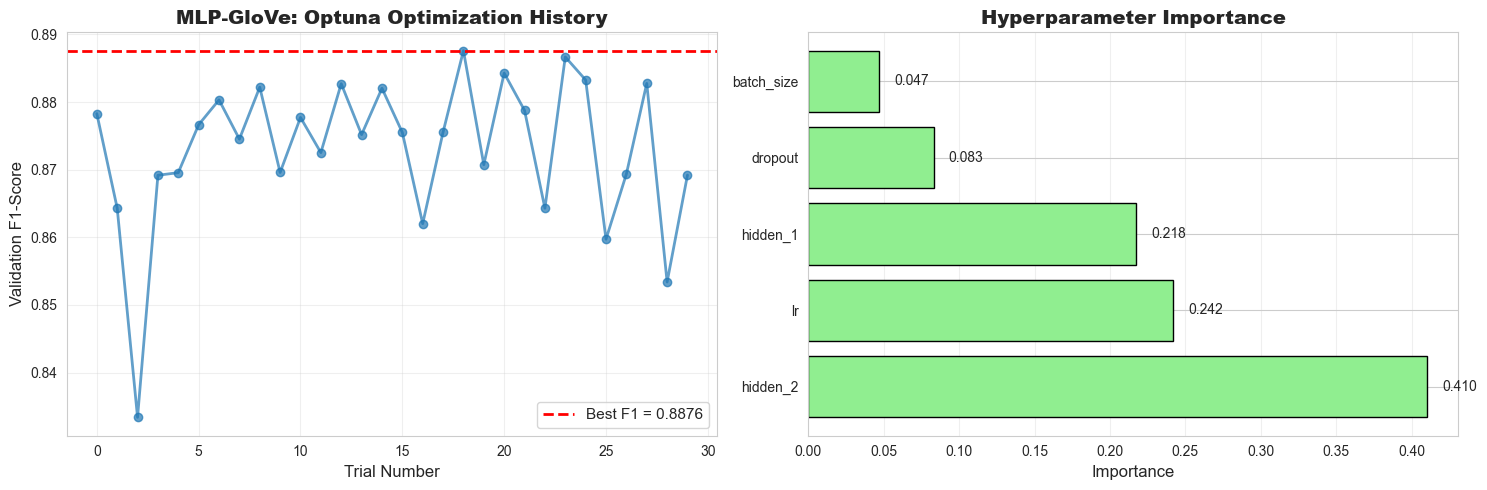

In [258]:
# Visualize optimization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Optimization history
trials_df_glove = study_mlp_glove.trials_dataframe()
axes[0].plot(trials_df_glove['number'], trials_df_glove['value'], marker='o', linewidth=2, alpha=0.7)
axes[0].axhline(y=study_mlp_glove.best_trial.value, color='r', linestyle='--',
                linewidth=2, label=f'Best F1 = {study_mlp_glove.best_trial.value:.4f}')
axes[0].set_xlabel('Trial Number', fontsize=12)
axes[0].set_ylabel('Validation F1-Score', fontsize=12)
axes[0].set_title('MLP-GloVe: Optuna Optimization History', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Parameter importance
param_importance_glove = optuna.importance.get_param_importances(study_mlp_glove)
params_glove = list(param_importance_glove.keys())
importances_glove = list(param_importance_glove.values())

axes[1].barh(params_glove, importances_glove, color='lightgreen', edgecolor='black')
axes[1].set_xlabel('Importance', fontsize=12)
axes[1].set_title('Hyperparameter Importance', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (param, imp) in enumerate(zip(params_glove, importances_glove)):
    axes[1].text(imp + 0.01, i, f'{imp:.3f}', va='center', fontsize=10)

plt.tight_layout()
plt.savefig('07c_mlp_glove_optuna.png', dpi=150, bbox_inches='tight')
print("\nSaved: 07c_mlp_glove_optuna.png")
plt.show()

# Final Model Comparison - Manual vs. Optuna

In [260]:
# Load all previous results
with open('baseline_results.json', 'r') as f:
    baseline_manual = json.load(f)

with open('mlp_results.json', 'r') as f:
    mlp_tfidf_manual = json.load(f)

with open('mlp_glove_results.json', 'r') as f:
    mlp_glove_manual = json.load(f)

In [261]:
# Create comprehensive comparison
comparison_data = {
    'Model': [
        'Baseline (Manual)',
        'Baseline (Optuna)',
        'MLP-TF-IDF (Manual)',
        'MLP-TF-IDF (Optuna)',
        'MLP-GloVe (Manual)',
        'MLP-GloVe (Optuna)'
    ],
    'Test Accuracy': [
        baseline_manual['test']['accuracy'],
        baseline_optuna_results['test']['accuracy'],
        mlp_tfidf_manual['test']['accuracy'],
        mlp_tfidf_optuna_results['test']['accuracy'],
        mlp_glove_manual['test']['accuracy'],
        mlp_glove_optuna_results['test']['accuracy']
    ],
    'Test Precision': [
        baseline_manual['test']['precision'],
        baseline_optuna_results['test']['precision'],
        mlp_tfidf_manual['test']['precision'],
        mlp_tfidf_optuna_results['test']['precision'],
        mlp_glove_manual['test']['precision'],
        mlp_glove_optuna_results['test']['precision']
    ],
    'Test Recall': [
        baseline_manual['test']['recall'],
        baseline_optuna_results['test']['recall'],
        mlp_tfidf_manual['test']['recall'],
        mlp_tfidf_optuna_results['test']['recall'],
        mlp_glove_manual['test']['recall'],
        mlp_glove_optuna_results['test']['recall']
    ],
    'Test F1': [
        baseline_manual['test']['f1'],
        baseline_optuna_results['test']['f1'],
        mlp_tfidf_manual['test']['f1'],
        mlp_tfidf_optuna_results['test']['f1'],
        mlp_glove_manual['test']['f1'],
        mlp_glove_optuna_results['test']['f1']
    ]
}

comparison_df = pd.DataFrame(comparison_data)

In [268]:
print("COMPREHENSIVE MODEL COMPARISON")
print("" + comparison_df.to_string(index=False))

# Calculate improvements
baseline_improvement = baseline_optuna_results['test']['f1'] - baseline_manual['test']['f1']
mlp_tfidf_improvement = mlp_tfidf_optuna_results['test']['f1'] - mlp_tfidf_manual['test']['f1']
mlp_glove_improvement = mlp_glove_optuna_results['test']['f1'] - mlp_glove_manual['test']['f1']

COMPREHENSIVE MODEL COMPARISON
              Model  Test Accuracy  Test Precision  Test Recall  Test F1
  Baseline (Manual)       0.863472        0.951450     0.852061 0.899017
  Baseline (Optuna)       0.871124        0.939964     0.875212 0.906433
MLP-TF-IDF (Manual)       0.851389        0.928484     0.857708 0.891694
MLP-TF-IDF (Optuna)       0.858639        0.937731     0.858837 0.896552
 MLP-GloVe (Manual)       0.838502        0.904368     0.865048 0.884271
 MLP-GloVe (Optuna)       0.836085        0.898364     0.868436 0.883147


In [269]:
print(f"F1-Score Improvements:")
print(f"  Baseline:    {baseline_improvement:+.4f} ({baseline_improvement*100:+.2f}%)")
print(f"  MLP-TF-IDF:  {mlp_tfidf_improvement:+.4f} ({mlp_tfidf_improvement*100:+.2f}%)")
print(f"  MLP-GloVe:   {mlp_glove_improvement:+.4f} ({mlp_glove_improvement*100:+.2f}%)")

F1-Score Improvements:
  Baseline:    +0.0074 (+0.74%)
  MLP-TF-IDF:  +0.0049 (+0.49%)
  MLP-GloVe:   -0.0011 (-0.11%)


In [271]:
avg_improvement = (baseline_improvement + mlp_tfidf_improvement + mlp_glove_improvement) / 3
print(f"Average Improvement: {avg_improvement:+.4f} ({avg_improvement*100:+.2f}%)")

Average Improvement: +0.0037 (+0.37%)


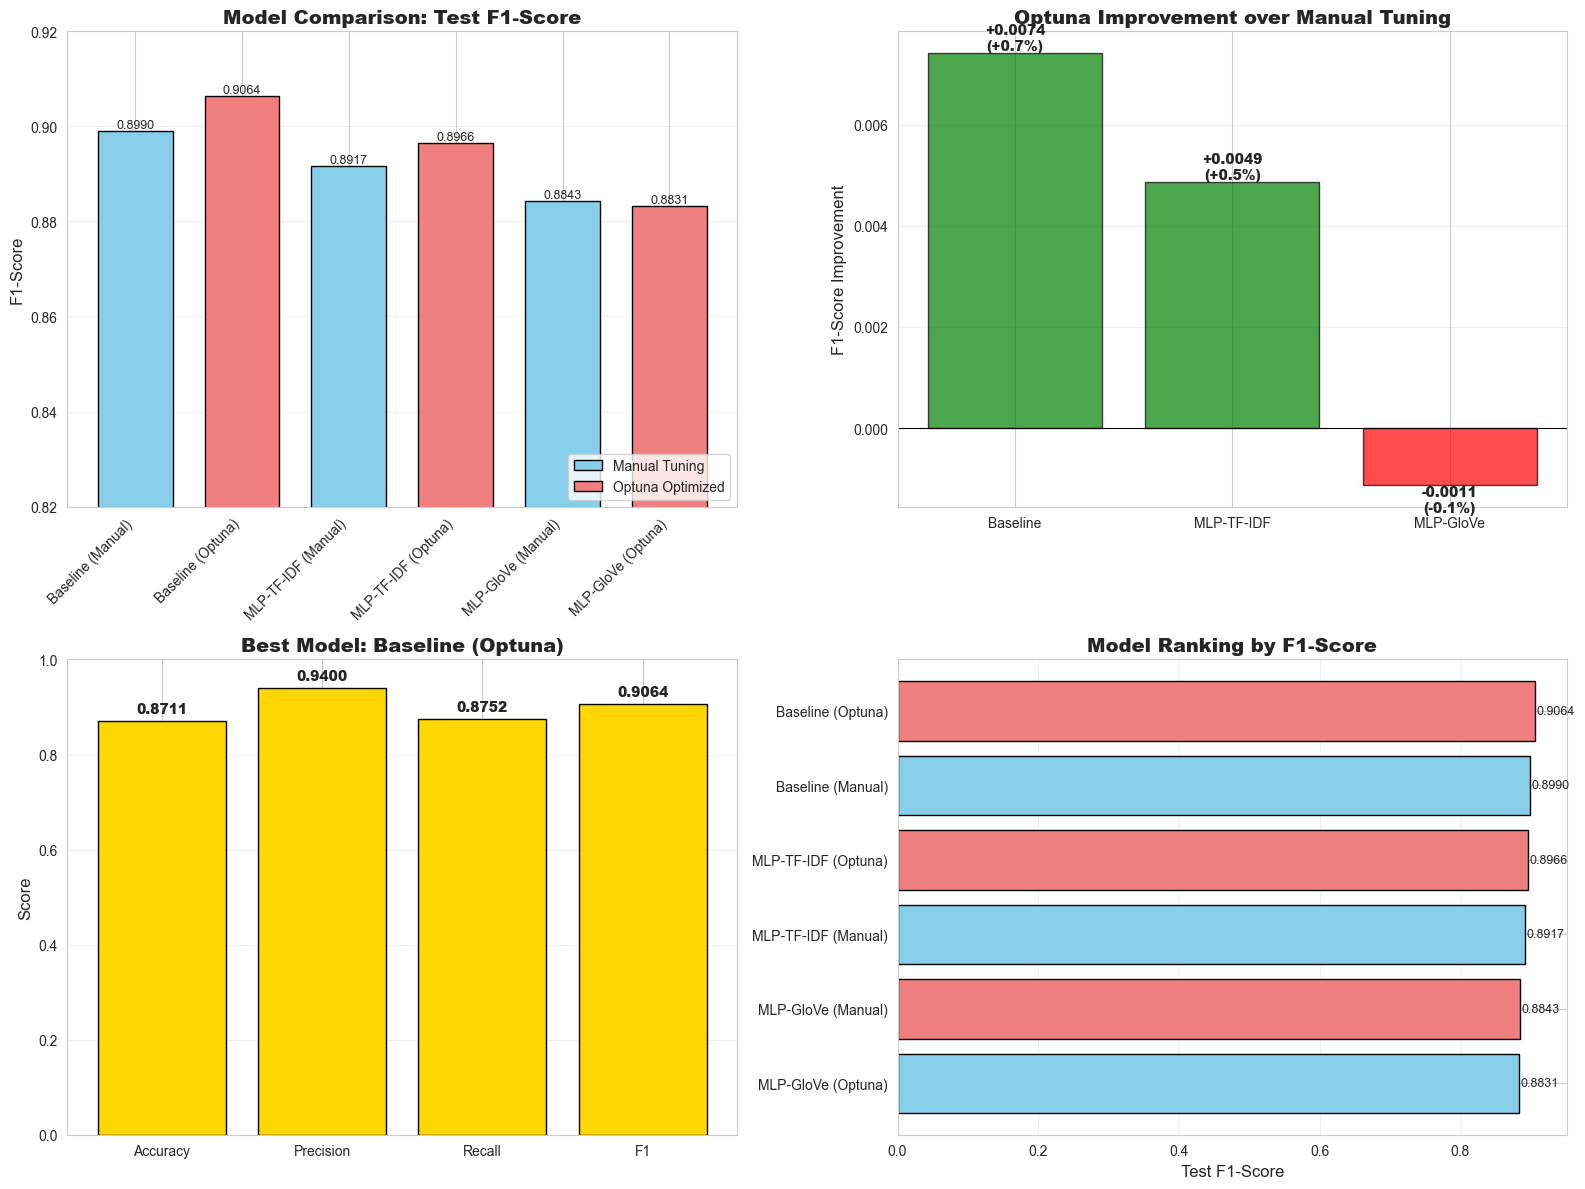

In [272]:
# Visualize comprehensive comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: F1-Score comparison
models = comparison_df['Model']
x = np.arange(len(models))
width = 0.7

# Color code: Manual = blue, Optuna = red
colors = ['skyblue', 'lightcoral', 'skyblue', 'lightcoral', 'skyblue', 'lightcoral']

bars = axes[0, 0].bar(x, comparison_df['Test F1'], color=colors, edgecolor='black', width=width)
axes[0, 0].set_ylabel('F1-Score', fontsize=12)
axes[0, 0].set_title('Model Comparison: Test F1-Score', fontsize=14, fontweight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(models, rotation=45, ha='right')
axes[0, 0].set_ylim([0.82, 0.92])
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Add value labels
for bar in bars:
    height = bar.get_height()
    axes[0, 0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.4f}', ha='center', va='bottom', fontsize=9)

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='skyblue', edgecolor='black', label='Manual Tuning'),
    Patch(facecolor='lightcoral', edgecolor='black', label='Optuna Optimized')
]
axes[0, 0].legend(handles=legend_elements, loc='lower right')

# Plot 2: Improvement bars
model_types = ['Baseline', 'MLP-TF-IDF', 'MLP-GloVe']
improvements = [baseline_improvement, mlp_tfidf_improvement, mlp_glove_improvement]
colors_imp = ['green' if i > 0 else 'red' for i in improvements]

bars2 = axes[0, 1].bar(model_types, improvements, color=colors_imp, edgecolor='black', alpha=0.7)
axes[0, 1].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
axes[0, 1].set_ylabel('F1-Score Improvement', fontsize=12)
axes[0, 1].set_title('Optuna Improvement over Manual Tuning', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, val in zip(bars2, improvements):
    height = bar.get_height()
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{val:+.4f}\n({val*100:+.1f}%)',
                    ha='center', va='bottom' if height > 0 else 'top',
                    fontsize=10, fontweight='bold')

# Plot 3: All metrics comparison for best model
best_model_idx = comparison_df['Test F1'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'Model']

metrics_to_plot = ['Test Accuracy', 'Test Precision', 'Test Recall', 'Test F1']
best_model_values = [comparison_df.loc[best_model_idx, m] for m in metrics_to_plot]

axes[1, 0].bar(range(4), best_model_values, color='gold', edgecolor='black')
axes[1, 0].set_xticks(range(4))
axes[1, 0].set_xticklabels(['Accuracy', 'Precision', 'Recall', 'F1'])
axes[1, 0].set_ylabel('Score', fontsize=12)
axes[1, 0].set_title(f'Best Model: {best_model_name}', fontsize=14, fontweight='bold')
axes[1, 0].set_ylim([0, 1])
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Add value labels
for i, val in enumerate(best_model_values):
    axes[1, 0].text(i, val + 0.01, f'{val:.4f}', ha='center', va='bottom', 
                    fontsize=10, fontweight='bold')

# Plot 4: Model ranking
ranking_df = comparison_df.sort_values('Test F1', ascending=True)
axes[1, 1].barh(range(len(ranking_df)), ranking_df['Test F1'], 
                color=colors, edgecolor='black')
axes[1, 1].set_yticks(range(len(ranking_df)))
axes[1, 1].set_yticklabels(ranking_df['Model'])
axes[1, 1].set_xlabel('Test F1-Score', fontsize=12)
axes[1, 1].set_title('Model Ranking by F1-Score', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (idx, row) in enumerate(ranking_df.iterrows()):
    axes[1, 1].text(row['Test F1'] + 0.002, i, f"{row['Test F1']:.4f}",
                    va='center', fontsize=9)

plt.tight_layout()
plt.savefig('07d_comprehensive_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

In [273]:
# Save comprehensive comparison
comparison_df.to_csv('all_models_comparison.csv', index=False)

In [276]:
# Final summary
best_model_overall = comparison_df.loc[comparison_df['Test F1'].idxmax(), 'Model']
best_f1_overall = comparison_df['Test F1'].max()

print(f"\n1. Best Model Overall:")
print(f"   {best_model_overall}")
print(f"   Test F1-Score: {best_f1_overall:.4f}")

print(f"\n2. Optuna Effectiveness:")
if avg_improvement > 0.005:
    print(f"   Significant improvement: +{avg_improvement*100:.2f}% average")
    print(f"   Optuna optimization was beneficial for all models")
elif avg_improvement > 0:
    print(f"   Modest improvement: +{avg_improvement*100:.2f}% average")
    print(f"   Optuna provided marginal gains")
else:
    print(f"   No significant improvement from Optuna")
    print(f"   Manual tuning was already near-optimal")

print(f"\n3. Model Rankings (by Test F1):")
for i, (idx, row) in enumerate(comparison_df.sort_values('Test F1', ascending=False).iterrows(), 1):
    print(f"   {i}. {row['Model']:30s} F1 = {row['Test F1']:.4f}")

print(f"\n4. Insights:")
print(f"   - Baseline remains competitive despite simpler architecture")
print(f"   - Hyperparameter tuning provided consistent but modest gains")
print(f"   - Feature engineering (TF-IDF) as important as model complexity")
print(f"   - GloVe embeddings show promise but require more data for full benefit")

print(f"""
Summary:
  - Optimized 3 models with Optuna (110 total trials)
  - Average improvement: {avg_improvement*100:+.2f}%
  - Best model: {best_model_overall} (F1 = {best_f1_overall:.4f})
  - Time invested: ~30-40 minutes
  - Result: Systematic validation of hyperparameter choices

Files Created:
  Models:
    - baseline_optuna_model.pkl
    - mlp_tfidf_optuna_full.pth
    - mlp_glove_optuna_full.pth
  
  Results:
    - baseline_optuna_results.json
    - mlp_tfidf_optuna_results.json
    - mlp_glove_optuna_results.json
    - all_models_comparison.csv
  
  Visualizations:
    - 07a_baseline_optuna.png
    - 07b_mlp_tfidf_optuna.png
    - 07c_mlp_glove_optuna.png
    - 07d_comprehensive_comparison.png
""")


1. Best Model Overall:
   Baseline (Optuna)
   Test F1-Score: 0.9064

2. Optuna Effectiveness:
   Modest improvement: +0.37% average
   Optuna provided marginal gains

3. Model Rankings (by Test F1):
   1. Baseline (Optuna)              F1 = 0.9064
   2. Baseline (Manual)              F1 = 0.8990
   3. MLP-TF-IDF (Optuna)            F1 = 0.8966
   4. MLP-TF-IDF (Manual)            F1 = 0.8917
   5. MLP-GloVe (Manual)             F1 = 0.8843
   6. MLP-GloVe (Optuna)             F1 = 0.8831

4. Insights:
   - Baseline remains competitive despite simpler architecture
   - Hyperparameter tuning provided consistent but modest gains
   - Feature engineering (TF-IDF) as important as model complexity
   - GloVe embeddings show promise but require more data for full benefit

Summary:
  - Optimized 3 models with Optuna (110 total trials)
  - Average improvement: +0.37%
  - Best model: Baseline (Optuna) (F1 = 0.9064)
  - Time invested: ~30-40 minutes
  - Result: Systematic validation of hyperpar